# Camera sensor profiling with NN
### www.datosimagensonido.com
[Calibración de cámara digital con redes neuronales](https://www.datosimagensonido.com/)

## Libraries needed

In [7]:
import os
# from skimage import io  # read/write image formats (incl. 16-bit TIFF)
import imageio  # read/write image formats (incl. 16-bit TIFF)
import pickle  # to save/load model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor  # our MLP!

## Reading IT8 card white balanced RAW data

In [114]:
# RAW extraction with WB
# dcraw -v -r 2.299 1 1.805 1 -t 0 -o 0 -4 -T IT8.NEF

# Read image
# img = io.imread('IT8.tiff')
img = imageio.imread('IT8.tiff');

In [115]:
# Crop IT8 (6016 x 4016 pixels)
X1, X2 = 1201, 4810
Y1, Y2 = 832, 3240

img = img[Y1:Y2, X1:X2]

In [116]:
print(type(img))
print("RGB values range from", np.min(img), "to", np.max(img))
img.shape  # 24 x 16 squares -> 22 * 12 = 264 colour patches + 24 gray patches -> total: 288 examples

<class 'imageio.core.util.Array'>
RGB values range from 614 to 49076


(2408, 3609, 3)

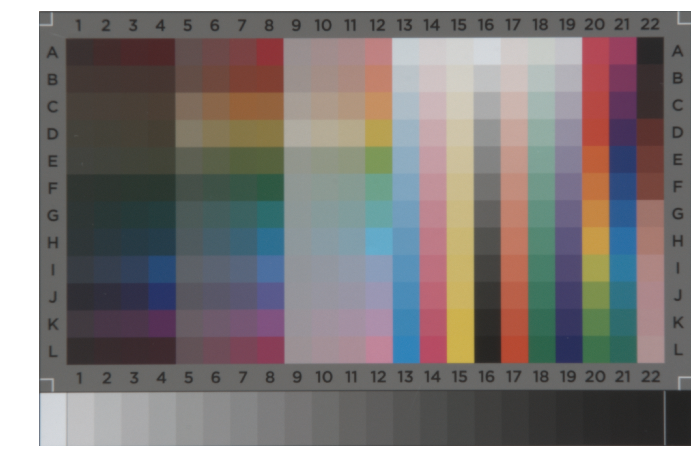

In [83]:
# Show IT8 chart
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow((img / 65535) ** (1 / 2.2))
plt.axis('off');

In [84]:
# Calculate median RGB values over each patch
width = img.shape[1] / 24
height = img.shape[0] / 16
dX, dY = width / 7, height / 7  # safety margin

colours = np.zeros((22 * 12, 3))
grays = np.zeros((24, 3))

# Colour patches
k = 0
for j in range(12):
    Y1, Y2 = round((j + 1) * height + dY), round((j + 2) * height - dY)
    for i in range(22):
        X1, X2 = round((i + 1) * width + dX), round((i + 2) * width - dX)
        for c in range(3):
            colours[k, c] = np.median(img[Y1:Y2, X1:X2, c])        
            img[(Y1 - 2):(Y2 + 2), (X1 - 2):(X2 + 2), c] = 0
            img[Y1:Y2, X1:X2, c] = colours[k, c]
        k = k + 1

# Gray patches
Y1, Y2 = round(14 * height + dY), round(16 * height - dY)
for i in range(24):
    X1, X2 = round((i + 0) * width + dX), round((i + 1) * width - dX)
    for c in range(3):
        grays[i, c] = np.median(img[Y1:Y2, X1:X2, c])
        img[(Y1 - 2):(Y2 + 2), (X1 - 2):(X2 + 2), c] = 0
        img[Y1:Y2, X1:X2, c] = grays[i, c]

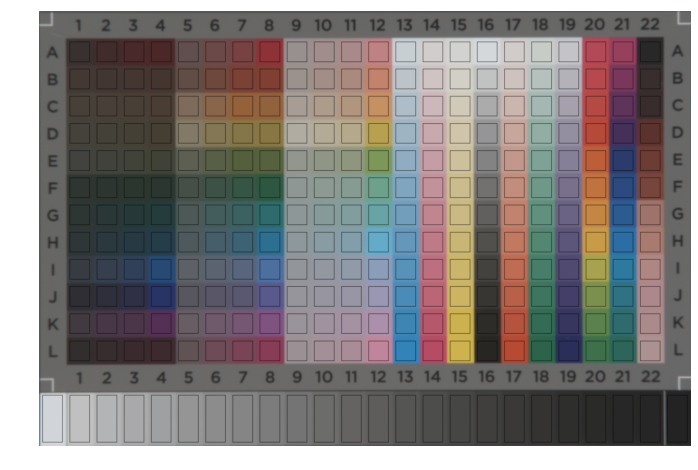

In [85]:
# Show used patches
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow((img / 65535) ** (1 / 2.2), interpolation='bilinear')
plt.axis('off');

In [86]:
# Save image
# io.imsave('IT8_crop_median.tif', img)
imageio.imwrite('IT8_crop_median.tif', img)

## Reading IT8 card XYZ/Lab theoretical output values

In [87]:
# 288 patches: 264 (0..263 = A1..L22) colour + 24 (264..287 = GS0..GS23) gray

In [117]:
# Features: X
R1 = colours[:, 0].flatten()
G1 = colours[:, 1].flatten()
B1 = colours[:, 2].flatten()

R2 = grays[:, 0].flatten()
G2 = grays[:, 1].flatten()
B2 = grays[:, 2].flatten()

X = np.concatenate((np.column_stack((R1, G1, B1)),
                    np.column_stack((R2, G2, B2)))) / 65535  # WB-RAW RGB in 0..1 range

In [118]:
# Target: Y
IT8 = pd.read_csv('IT8.txt', sep='\t', decimal=',')
IT8.head()

Patch          X          Y         Z        L        a        b
0    A1   3.273115   2.815129  1.956762  19.2878   9.7909   3.3837
1    A2   3.998580   2.721619  1.417480  18.8926  22.6662   8.5572
2    A3   4.991359   2.802497  1.360139  19.2349  34.4691   9.8527
3    A4   5.137458   2.693988  1.131962  18.7742  38.2558  12.0804
4    A5  12.086800  10.629437  7.330434  38.9492  13.3835   5.5036

In [119]:
Y_XYZ = IT8[['X', 'Y', 'Z']].values / 100  # XYZ in the 0..1 range
Y_Lab = IT8[['L', 'a', 'b']].values        # Lab in the Lab range

## Training the neural network

### XYZ output NN

In [93]:
# Define and train MLP with XYZ output
Y = Y_XYZ

for nn in [(), (200, 200)]:  # matrix and dense NN
    regr = MLPRegressor(solver='adam', # solver algorithm ('sgd', 'lbfgs', 'adam')
                        alpha=0,        # no L2 (ridge regression) regularization
                        hidden_layer_sizes=nn,  # tuple defining layers and nodes
                        # early_stopping=True,
                        # validation_fraction=0.05,
                        activation='relu',      # hidden layers activation function (default 'relu') 
                                                # 'logistic' (sigmoid) works better than 'relu' and 'tanh'
                        max_iter=20800,  # max_iter=20800,         # max epochs
                        tol=0.000000000001,     # tolerance for early stopping
                        n_iter_no_change=10000,  # number of epochs to check tol
                        random_state=42,        # guarantee reproducible training
                        verbose=True)           # tell me a story
    regr.out_activation_ = 'identity'  # output layer activation function (default 'identity')
                                       # 'identity' is adequate for regression
    regr.fit(X, Y)
    
    # Save MLP
    with open('MLP_XYZ_' + str(nn) + '_' + regr.activation + '_' + regr.out_activation_ + '.pkl', 'wb') as f:
        pickle.dump(regr, f)
    

Iteration 1, loss = 0.28753977
Iteration 2, loss = 0.28549278
Iteration 3, loss = 0.28349485
Iteration 4, loss = 0.28149392
Iteration 5, loss = 0.27947990
Iteration 6, loss = 0.27751543
Iteration 7, loss = 0.27554270
Iteration 8, loss = 0.27360458
Iteration 9, loss = 0.27165420
Iteration 10, loss = 0.26973784
Iteration 11, loss = 0.26781958
Iteration 12, loss = 0.26591847
Iteration 13, loss = 0.26404318
Iteration 14, loss = 0.26216048
Iteration 15, loss = 0.26031005
Iteration 16, loss = 0.25844385
Iteration 17, loss = 0.25660750
Iteration 18, loss = 0.25479082
Iteration 19, loss = 0.25298665
Iteration 20, loss = 0.25117123
Iteration 21, loss = 0.24941866
Iteration 22, loss = 0.24762611
Iteration 23, loss = 0.24585917
Iteration 24, loss = 0.24410664
Iteration 25, loss = 0.24238031
Iteration 26, loss = 0.24066366
Iteration 27, loss = 0.23893217
Iteration 28, loss = 0.23722713
Iteration 29, loss = 0.23554136
Iteration 30, loss = 0.23386291
Iteration 31, loss = 0.23218871
Iteration 32, los

Iteration 398, loss = 0.02809374
Iteration 399, loss = 0.02799599
Iteration 400, loss = 0.02790033
Iteration 401, loss = 0.02780296
Iteration 402, loss = 0.02770758
Iteration 403, loss = 0.02761385
Iteration 404, loss = 0.02751859
Iteration 405, loss = 0.02742511
Iteration 406, loss = 0.02733226
Iteration 407, loss = 0.02723834
Iteration 408, loss = 0.02714574
Iteration 409, loss = 0.02705628
Iteration 410, loss = 0.02696334
Iteration 411, loss = 0.02687337
Iteration 412, loss = 0.02678367
Iteration 413, loss = 0.02669470
Iteration 414, loss = 0.02660659
Iteration 415, loss = 0.02651861
Iteration 416, loss = 0.02643062
Iteration 417, loss = 0.02634401
Iteration 418, loss = 0.02625780
Iteration 419, loss = 0.02617052
Iteration 420, loss = 0.02608463
Iteration 421, loss = 0.02600007
Iteration 422, loss = 0.02591445
Iteration 423, loss = 0.02582776
Iteration 424, loss = 0.02574422
Iteration 425, loss = 0.02565989
Iteration 426, loss = 0.02557607
Iteration 427, loss = 0.02549232
Iteration 

Iteration 794, loss = 0.00878050
Iteration 795, loss = 0.00875425
Iteration 796, loss = 0.00872879
Iteration 797, loss = 0.00870366
Iteration 798, loss = 0.00867807
Iteration 799, loss = 0.00865327
Iteration 800, loss = 0.00862784
Iteration 801, loss = 0.00860269
Iteration 802, loss = 0.00857802
Iteration 803, loss = 0.00855269
Iteration 804, loss = 0.00852744
Iteration 805, loss = 0.00850270
Iteration 806, loss = 0.00847799
Iteration 807, loss = 0.00845290
Iteration 808, loss = 0.00842808
Iteration 809, loss = 0.00840346
Iteration 810, loss = 0.00837892
Iteration 811, loss = 0.00835444
Iteration 812, loss = 0.00832993
Iteration 813, loss = 0.00830563
Iteration 814, loss = 0.00828178
Iteration 815, loss = 0.00825705
Iteration 816, loss = 0.00823343
Iteration 817, loss = 0.00820952
Iteration 818, loss = 0.00818553
Iteration 819, loss = 0.00816165
Iteration 820, loss = 0.00813777
Iteration 821, loss = 0.00811386
Iteration 822, loss = 0.00809012
Iteration 823, loss = 0.00806665
Iteration 

Iteration 1194, loss = 0.00298817
Iteration 1195, loss = 0.00298167
Iteration 1196, loss = 0.00297506
Iteration 1197, loss = 0.00296866
Iteration 1198, loss = 0.00296235
Iteration 1199, loss = 0.00295588
Iteration 1200, loss = 0.00294958
Iteration 1201, loss = 0.00294312
Iteration 1202, loss = 0.00293693
Iteration 1203, loss = 0.00293072
Iteration 1204, loss = 0.00292441
Iteration 1205, loss = 0.00291817
Iteration 1206, loss = 0.00291179
Iteration 1207, loss = 0.00290562
Iteration 1208, loss = 0.00289948
Iteration 1209, loss = 0.00289314
Iteration 1210, loss = 0.00288701
Iteration 1211, loss = 0.00288097
Iteration 1212, loss = 0.00287483
Iteration 1213, loss = 0.00286878
Iteration 1214, loss = 0.00286273
Iteration 1215, loss = 0.00285668
Iteration 1216, loss = 0.00285069
Iteration 1217, loss = 0.00284465
Iteration 1218, loss = 0.00283886
Iteration 1219, loss = 0.00283284
Iteration 1220, loss = 0.00282700
Iteration 1221, loss = 0.00282096
Iteration 1222, loss = 0.00281510
Iteration 1223

Iteration 1620, loss = 0.00159074
Iteration 1621, loss = 0.00158920
Iteration 1622, loss = 0.00158776
Iteration 1623, loss = 0.00158636
Iteration 1624, loss = 0.00158490
Iteration 1625, loss = 0.00158343
Iteration 1626, loss = 0.00158207
Iteration 1627, loss = 0.00158066
Iteration 1628, loss = 0.00157923
Iteration 1629, loss = 0.00157776
Iteration 1630, loss = 0.00157638
Iteration 1631, loss = 0.00157492
Iteration 1632, loss = 0.00157354
Iteration 1633, loss = 0.00157202
Iteration 1634, loss = 0.00157061
Iteration 1635, loss = 0.00156922
Iteration 1636, loss = 0.00156777
Iteration 1637, loss = 0.00156648
Iteration 1638, loss = 0.00156502
Iteration 1639, loss = 0.00156373
Iteration 1640, loss = 0.00156230
Iteration 1641, loss = 0.00156089
Iteration 1642, loss = 0.00155952
Iteration 1643, loss = 0.00155808
Iteration 1644, loss = 0.00155669
Iteration 1645, loss = 0.00155533
Iteration 1646, loss = 0.00155392
Iteration 1647, loss = 0.00155259
Iteration 1648, loss = 0.00155130
Iteration 1649

Iteration 1983, loss = 0.00119535
Iteration 1984, loss = 0.00119446
Iteration 1985, loss = 0.00119360
Iteration 1986, loss = 0.00119271
Iteration 1987, loss = 0.00119175
Iteration 1988, loss = 0.00119090
Iteration 1989, loss = 0.00119004
Iteration 1990, loss = 0.00118916
Iteration 1991, loss = 0.00118823
Iteration 1992, loss = 0.00118734
Iteration 1993, loss = 0.00118648
Iteration 1994, loss = 0.00118555
Iteration 1995, loss = 0.00118473
Iteration 1996, loss = 0.00118382
Iteration 1997, loss = 0.00118296
Iteration 1998, loss = 0.00118210
Iteration 1999, loss = 0.00118117
Iteration 2000, loss = 0.00118026
Iteration 2001, loss = 0.00117945
Iteration 2002, loss = 0.00117854
Iteration 2003, loss = 0.00117770
Iteration 2004, loss = 0.00117680
Iteration 2005, loss = 0.00117588
Iteration 2006, loss = 0.00117507
Iteration 2007, loss = 0.00117410
Iteration 2008, loss = 0.00117328
Iteration 2009, loss = 0.00117237
Iteration 2010, loss = 0.00117146
Iteration 2011, loss = 0.00117061
Iteration 2012

Iteration 2410, loss = 0.00083613
Iteration 2411, loss = 0.00083529
Iteration 2412, loss = 0.00083454
Iteration 2413, loss = 0.00083372
Iteration 2414, loss = 0.00083295
Iteration 2415, loss = 0.00083211
Iteration 2416, loss = 0.00083136
Iteration 2417, loss = 0.00083052
Iteration 2418, loss = 0.00082979
Iteration 2419, loss = 0.00082897
Iteration 2420, loss = 0.00082808
Iteration 2421, loss = 0.00082745
Iteration 2422, loss = 0.00082650
Iteration 2423, loss = 0.00082571
Iteration 2424, loss = 0.00082487
Iteration 2425, loss = 0.00082406
Iteration 2426, loss = 0.00082325
Iteration 2427, loss = 0.00082245
Iteration 2428, loss = 0.00082164
Iteration 2429, loss = 0.00082081
Iteration 2430, loss = 0.00081999
Iteration 2431, loss = 0.00081917
Iteration 2432, loss = 0.00081844
Iteration 2433, loss = 0.00081766
Iteration 2434, loss = 0.00081693
Iteration 2435, loss = 0.00081607
Iteration 2436, loss = 0.00081530
Iteration 2437, loss = 0.00081448
Iteration 2438, loss = 0.00081363
Iteration 2439

Iteration 2809, loss = 0.00054343
Iteration 2810, loss = 0.00054283
Iteration 2811, loss = 0.00054214
Iteration 2812, loss = 0.00054146
Iteration 2813, loss = 0.00054080
Iteration 2814, loss = 0.00054018
Iteration 2815, loss = 0.00053952
Iteration 2816, loss = 0.00053889
Iteration 2817, loss = 0.00053822
Iteration 2818, loss = 0.00053755
Iteration 2819, loss = 0.00053694
Iteration 2820, loss = 0.00053630
Iteration 2821, loss = 0.00053564
Iteration 2822, loss = 0.00053503
Iteration 2823, loss = 0.00053442
Iteration 2824, loss = 0.00053368
Iteration 2825, loss = 0.00053302
Iteration 2826, loss = 0.00053238
Iteration 2827, loss = 0.00053176
Iteration 2828, loss = 0.00053111
Iteration 2829, loss = 0.00053049
Iteration 2830, loss = 0.00052986
Iteration 2831, loss = 0.00052930
Iteration 2832, loss = 0.00052860
Iteration 2833, loss = 0.00052798
Iteration 2834, loss = 0.00052725
Iteration 2835, loss = 0.00052663
Iteration 2836, loss = 0.00052601
Iteration 2837, loss = 0.00052539
Iteration 2838

Iteration 3177, loss = 0.00033595
Iteration 3178, loss = 0.00033543
Iteration 3179, loss = 0.00033497
Iteration 3180, loss = 0.00033449
Iteration 3181, loss = 0.00033390
Iteration 3182, loss = 0.00033351
Iteration 3183, loss = 0.00033297
Iteration 3184, loss = 0.00033250
Iteration 3185, loss = 0.00033210
Iteration 3186, loss = 0.00033163
Iteration 3187, loss = 0.00033118
Iteration 3188, loss = 0.00033066
Iteration 3189, loss = 0.00033024
Iteration 3190, loss = 0.00032973
Iteration 3191, loss = 0.00032927
Iteration 3192, loss = 0.00032884
Iteration 3193, loss = 0.00032836
Iteration 3194, loss = 0.00032791
Iteration 3195, loss = 0.00032748
Iteration 3196, loss = 0.00032704
Iteration 3197, loss = 0.00032658
Iteration 3198, loss = 0.00032615
Iteration 3199, loss = 0.00032573
Iteration 3200, loss = 0.00032521
Iteration 3201, loss = 0.00032469
Iteration 3202, loss = 0.00032438
Iteration 3203, loss = 0.00032397
Iteration 3204, loss = 0.00032366
Iteration 3205, loss = 0.00032312
Iteration 3206

Iteration 3602, loss = 0.00019104
Iteration 3603, loss = 0.00019079
Iteration 3604, loss = 0.00019063
Iteration 3605, loss = 0.00019038
Iteration 3606, loss = 0.00019017
Iteration 3607, loss = 0.00018995
Iteration 3608, loss = 0.00018971
Iteration 3609, loss = 0.00018951
Iteration 3610, loss = 0.00018928
Iteration 3611, loss = 0.00018904
Iteration 3612, loss = 0.00018885
Iteration 3613, loss = 0.00018860
Iteration 3614, loss = 0.00018844
Iteration 3615, loss = 0.00018819
Iteration 3616, loss = 0.00018794
Iteration 3617, loss = 0.00018773
Iteration 3618, loss = 0.00018753
Iteration 3619, loss = 0.00018729
Iteration 3620, loss = 0.00018709
Iteration 3621, loss = 0.00018690
Iteration 3622, loss = 0.00018673
Iteration 3623, loss = 0.00018644
Iteration 3624, loss = 0.00018617
Iteration 3625, loss = 0.00018618
Iteration 3626, loss = 0.00018575
Iteration 3627, loss = 0.00018556
Iteration 3628, loss = 0.00018536
Iteration 3629, loss = 0.00018523
Iteration 3630, loss = 0.00018503
Iteration 3631

Iteration 4021, loss = 0.00013423
Iteration 4022, loss = 0.00013417
Iteration 4023, loss = 0.00013410
Iteration 4024, loss = 0.00013403
Iteration 4025, loss = 0.00013395
Iteration 4026, loss = 0.00013389
Iteration 4027, loss = 0.00013384
Iteration 4028, loss = 0.00013391
Iteration 4029, loss = 0.00013372
Iteration 4030, loss = 0.00013365
Iteration 4031, loss = 0.00013361
Iteration 4032, loss = 0.00013356
Iteration 4033, loss = 0.00013348
Iteration 4034, loss = 0.00013342
Iteration 4035, loss = 0.00013334
Iteration 4036, loss = 0.00013332
Iteration 4037, loss = 0.00013322
Iteration 4038, loss = 0.00013322
Iteration 4039, loss = 0.00013323
Iteration 4040, loss = 0.00013313
Iteration 4041, loss = 0.00013302
Iteration 4042, loss = 0.00013291
Iteration 4043, loss = 0.00013291
Iteration 4044, loss = 0.00013290
Iteration 4045, loss = 0.00013274
Iteration 4046, loss = 0.00013296
Iteration 4047, loss = 0.00013266
Iteration 4048, loss = 0.00013252
Iteration 4049, loss = 0.00013251
Iteration 4050

Iteration 4336, loss = 0.00012312
Iteration 4337, loss = 0.00012317
Iteration 4338, loss = 0.00012301
Iteration 4339, loss = 0.00012280
Iteration 4340, loss = 0.00012313
Iteration 4341, loss = 0.00012321
Iteration 4342, loss = 0.00012312
Iteration 4343, loss = 0.00012273
Iteration 4344, loss = 0.00012268
Iteration 4345, loss = 0.00012273
Iteration 4346, loss = 0.00012279
Iteration 4347, loss = 0.00012277
Iteration 4348, loss = 0.00012259
Iteration 4349, loss = 0.00012261
Iteration 4350, loss = 0.00012285
Iteration 4351, loss = 0.00012269
Iteration 4352, loss = 0.00012274
Iteration 4353, loss = 0.00012254
Iteration 4354, loss = 0.00012268
Iteration 4355, loss = 0.00012257
Iteration 4356, loss = 0.00012250
Iteration 4357, loss = 0.00012249
Iteration 4358, loss = 0.00012249
Iteration 4359, loss = 0.00012244
Iteration 4360, loss = 0.00012253
Iteration 4361, loss = 0.00012242
Iteration 4362, loss = 0.00012241
Iteration 4363, loss = 0.00012238
Iteration 4364, loss = 0.00012236
Iteration 4365

Iteration 4692, loss = 0.00012051
Iteration 4693, loss = 0.00012053
Iteration 4694, loss = 0.00012069
Iteration 4695, loss = 0.00012053
Iteration 4696, loss = 0.00012048
Iteration 4697, loss = 0.00012061
Iteration 4698, loss = 0.00012059
Iteration 4699, loss = 0.00012060
Iteration 4700, loss = 0.00012049
Iteration 4701, loss = 0.00012050
Iteration 4702, loss = 0.00012049
Iteration 4703, loss = 0.00012052
Iteration 4704, loss = 0.00012049
Iteration 4705, loss = 0.00012058
Iteration 4706, loss = 0.00012046
Iteration 4707, loss = 0.00012063
Iteration 4708, loss = 0.00012044
Iteration 4709, loss = 0.00012043
Iteration 4710, loss = 0.00012054
Iteration 4711, loss = 0.00012072
Iteration 4712, loss = 0.00012074
Iteration 4713, loss = 0.00012065
Iteration 4714, loss = 0.00012086
Iteration 4715, loss = 0.00012058
Iteration 4716, loss = 0.00012061
Iteration 4717, loss = 0.00012060
Iteration 4718, loss = 0.00012051
Iteration 4719, loss = 0.00012047
Iteration 4720, loss = 0.00012057
Iteration 4721

Iteration 5046, loss = 0.00012032
Iteration 5047, loss = 0.00012066
Iteration 5048, loss = 0.00012029
Iteration 5049, loss = 0.00012045
Iteration 5050, loss = 0.00012047
Iteration 5051, loss = 0.00012047
Iteration 5052, loss = 0.00012057
Iteration 5053, loss = 0.00012036
Iteration 5054, loss = 0.00012035
Iteration 5055, loss = 0.00012031
Iteration 5056, loss = 0.00012032
Iteration 5057, loss = 0.00012033
Iteration 5058, loss = 0.00012041
Iteration 5059, loss = 0.00012042
Iteration 5060, loss = 0.00012043
Iteration 5061, loss = 0.00012043
Iteration 5062, loss = 0.00012037
Iteration 5063, loss = 0.00012036
Iteration 5064, loss = 0.00012033
Iteration 5065, loss = 0.00012031
Iteration 5066, loss = 0.00012046
Iteration 5067, loss = 0.00012051
Iteration 5068, loss = 0.00012042
Iteration 5069, loss = 0.00012057
Iteration 5070, loss = 0.00012052
Iteration 5071, loss = 0.00012033
Iteration 5072, loss = 0.00012038
Iteration 5073, loss = 0.00012039
Iteration 5074, loss = 0.00012042
Iteration 5075

Iteration 5364, loss = 0.00012059
Iteration 5365, loss = 0.00012042
Iteration 5366, loss = 0.00012036
Iteration 5367, loss = 0.00012035
Iteration 5368, loss = 0.00012052
Iteration 5369, loss = 0.00012052
Iteration 5370, loss = 0.00012042
Iteration 5371, loss = 0.00012040
Iteration 5372, loss = 0.00012036
Iteration 5373, loss = 0.00012037
Iteration 5374, loss = 0.00012037
Iteration 5375, loss = 0.00012037
Iteration 5376, loss = 0.00012029
Iteration 5377, loss = 0.00012057
Iteration 5378, loss = 0.00012068
Iteration 5379, loss = 0.00012050
Iteration 5380, loss = 0.00012041
Iteration 5381, loss = 0.00012035
Iteration 5382, loss = 0.00012071
Iteration 5383, loss = 0.00012055
Iteration 5384, loss = 0.00012050
Iteration 5385, loss = 0.00012036
Iteration 5386, loss = 0.00012036
Iteration 5387, loss = 0.00012040
Iteration 5388, loss = 0.00012032
Iteration 5389, loss = 0.00012066
Iteration 5390, loss = 0.00012048
Iteration 5391, loss = 0.00012040
Iteration 5392, loss = 0.00012047
Iteration 5393

Iteration 5655, loss = 0.00012036
Iteration 5656, loss = 0.00012038
Iteration 5657, loss = 0.00012055
Iteration 5658, loss = 0.00012061
Iteration 5659, loss = 0.00012053
Iteration 5660, loss = 0.00012039
Iteration 5661, loss = 0.00012051
Iteration 5662, loss = 0.00012053
Iteration 5663, loss = 0.00012041
Iteration 5664, loss = 0.00012037
Iteration 5665, loss = 0.00012035
Iteration 5666, loss = 0.00012034
Iteration 5667, loss = 0.00012051
Iteration 5668, loss = 0.00012040
Iteration 5669, loss = 0.00012035
Iteration 5670, loss = 0.00012034
Iteration 5671, loss = 0.00012037
Iteration 5672, loss = 0.00012037
Iteration 5673, loss = 0.00012034
Iteration 5674, loss = 0.00012049
Iteration 5675, loss = 0.00012058
Iteration 5676, loss = 0.00012031
Iteration 5677, loss = 0.00012045
Iteration 5678, loss = 0.00012040
Iteration 5679, loss = 0.00012035
Iteration 5680, loss = 0.00012035
Iteration 5681, loss = 0.00012032
Iteration 5682, loss = 0.00012032
Iteration 5683, loss = 0.00012036
Iteration 5684

Iteration 5969, loss = 0.00012070
Iteration 5970, loss = 0.00012068
Iteration 5971, loss = 0.00012059
Iteration 5972, loss = 0.00012025
Iteration 5973, loss = 0.00012046
Iteration 5974, loss = 0.00012089
Iteration 5975, loss = 0.00012093
Iteration 5976, loss = 0.00012053
Iteration 5977, loss = 0.00012055
Iteration 5978, loss = 0.00012044
Iteration 5979, loss = 0.00012058
Iteration 5980, loss = 0.00012062
Iteration 5981, loss = 0.00012049
Iteration 5982, loss = 0.00012039
Iteration 5983, loss = 0.00012038
Iteration 5984, loss = 0.00012035
Iteration 5985, loss = 0.00012039
Iteration 5986, loss = 0.00012038
Iteration 5987, loss = 0.00012030
Iteration 5988, loss = 0.00012037
Iteration 5989, loss = 0.00012058
Iteration 5990, loss = 0.00012067
Iteration 5991, loss = 0.00012052
Iteration 5992, loss = 0.00012045
Iteration 5993, loss = 0.00012037
Iteration 5994, loss = 0.00012049
Iteration 5995, loss = 0.00012035
Iteration 5996, loss = 0.00012079
Iteration 5997, loss = 0.00012075
Iteration 5998

Iteration 6289, loss = 0.00012041
Iteration 6290, loss = 0.00012066
Iteration 6291, loss = 0.00012083
Iteration 6292, loss = 0.00012060
Iteration 6293, loss = 0.00012056
Iteration 6294, loss = 0.00012040
Iteration 6295, loss = 0.00012032
Iteration 6296, loss = 0.00012031
Iteration 6297, loss = 0.00012035
Iteration 6298, loss = 0.00012039
Iteration 6299, loss = 0.00012042
Iteration 6300, loss = 0.00012064
Iteration 6301, loss = 0.00012044
Iteration 6302, loss = 0.00012026
Iteration 6303, loss = 0.00012041
Iteration 6304, loss = 0.00012057
Iteration 6305, loss = 0.00012040
Iteration 6306, loss = 0.00012055
Iteration 6307, loss = 0.00012045
Iteration 6308, loss = 0.00012050
Iteration 6309, loss = 0.00012040
Iteration 6310, loss = 0.00012026
Iteration 6311, loss = 0.00012029
Iteration 6312, loss = 0.00012054
Iteration 6313, loss = 0.00012070
Iteration 6314, loss = 0.00012041
Iteration 6315, loss = 0.00012016
Iteration 6316, loss = 0.00012059
Iteration 6317, loss = 0.00012101
Iteration 6318

Iteration 6619, loss = 0.00012046
Iteration 6620, loss = 0.00012081
Iteration 6621, loss = 0.00012121
Iteration 6622, loss = 0.00012117
Iteration 6623, loss = 0.00012057
Iteration 6624, loss = 0.00012032
Iteration 6625, loss = 0.00012071
Iteration 6626, loss = 0.00012117
Iteration 6627, loss = 0.00012092
Iteration 6628, loss = 0.00012089
Iteration 6629, loss = 0.00012037
Iteration 6630, loss = 0.00012023
Iteration 6631, loss = 0.00012072
Iteration 6632, loss = 0.00012078
Iteration 6633, loss = 0.00012073
Iteration 6634, loss = 0.00012037
Iteration 6635, loss = 0.00012052
Iteration 6636, loss = 0.00012036
Iteration 6637, loss = 0.00012041
Iteration 6638, loss = 0.00012037
Iteration 6639, loss = 0.00012026
Iteration 6640, loss = 0.00012033
Iteration 6641, loss = 0.00012068
Iteration 6642, loss = 0.00012067
Iteration 6643, loss = 0.00012036
Iteration 6644, loss = 0.00012027
Iteration 6645, loss = 0.00012035
Iteration 6646, loss = 0.00012048
Iteration 6647, loss = 0.00012050
Iteration 6648

Iteration 6970, loss = 0.00012045
Iteration 6971, loss = 0.00012045
Iteration 6972, loss = 0.00012052
Iteration 6973, loss = 0.00012048
Iteration 6974, loss = 0.00012027
Iteration 6975, loss = 0.00012041
Iteration 6976, loss = 0.00012060
Iteration 6977, loss = 0.00012063
Iteration 6978, loss = 0.00012033
Iteration 6979, loss = 0.00012042
Iteration 6980, loss = 0.00012063
Iteration 6981, loss = 0.00012063
Iteration 6982, loss = 0.00012038
Iteration 6983, loss = 0.00012019
Iteration 6984, loss = 0.00012070
Iteration 6985, loss = 0.00012090
Iteration 6986, loss = 0.00012110
Iteration 6987, loss = 0.00012053
Iteration 6988, loss = 0.00012057
Iteration 6989, loss = 0.00012068
Iteration 6990, loss = 0.00012038
Iteration 6991, loss = 0.00012038
Iteration 6992, loss = 0.00012041
Iteration 6993, loss = 0.00012031
Iteration 6994, loss = 0.00012040
Iteration 6995, loss = 0.00012079
Iteration 6996, loss = 0.00012049
Iteration 6997, loss = 0.00012027
Iteration 6998, loss = 0.00012073
Iteration 6999

Iteration 7274, loss = 0.00012083
Iteration 7275, loss = 0.00012048
Iteration 7276, loss = 0.00012037
Iteration 7277, loss = 0.00012056
Iteration 7278, loss = 0.00012068
Iteration 7279, loss = 0.00012052
Iteration 7280, loss = 0.00012034
Iteration 7281, loss = 0.00012054
Iteration 7282, loss = 0.00012041
Iteration 7283, loss = 0.00012033
Iteration 7284, loss = 0.00012023
Iteration 7285, loss = 0.00012035
Iteration 7286, loss = 0.00012068
Iteration 7287, loss = 0.00012101
Iteration 7288, loss = 0.00012081
Iteration 7289, loss = 0.00012031
Iteration 7290, loss = 0.00012070
Iteration 7291, loss = 0.00012111
Iteration 7292, loss = 0.00012089
Iteration 7293, loss = 0.00012033
Iteration 7294, loss = 0.00012060
Iteration 7295, loss = 0.00012083
Iteration 7296, loss = 0.00012101
Iteration 7297, loss = 0.00012089
Iteration 7298, loss = 0.00012080
Iteration 7299, loss = 0.00012028
Iteration 7300, loss = 0.00012063
Iteration 7301, loss = 0.00012043
Iteration 7302, loss = 0.00012033
Iteration 7303

Iteration 7614, loss = 0.00012037
Iteration 7615, loss = 0.00012019
Iteration 7616, loss = 0.00012087
Iteration 7617, loss = 0.00012107
Iteration 7618, loss = 0.00012092
Iteration 7619, loss = 0.00012050
Iteration 7620, loss = 0.00012028
Iteration 7621, loss = 0.00012030
Iteration 7622, loss = 0.00012040
Iteration 7623, loss = 0.00012049
Iteration 7624, loss = 0.00012043
Iteration 7625, loss = 0.00012041
Iteration 7626, loss = 0.00012049
Iteration 7627, loss = 0.00012027
Iteration 7628, loss = 0.00012037
Iteration 7629, loss = 0.00012052
Iteration 7630, loss = 0.00012037
Iteration 7631, loss = 0.00012072
Iteration 7632, loss = 0.00012041
Iteration 7633, loss = 0.00012055
Iteration 7634, loss = 0.00012040
Iteration 7635, loss = 0.00012033
Iteration 7636, loss = 0.00012037
Iteration 7637, loss = 0.00012045
Iteration 7638, loss = 0.00012035
Iteration 7639, loss = 0.00012039
Iteration 7640, loss = 0.00012038
Iteration 7641, loss = 0.00012043
Iteration 7642, loss = 0.00012042
Iteration 7643

Iteration 7948, loss = 0.00012027
Iteration 7949, loss = 0.00012088
Iteration 7950, loss = 0.00012103
Iteration 7951, loss = 0.00012072
Iteration 7952, loss = 0.00012045
Iteration 7953, loss = 0.00012034
Iteration 7954, loss = 0.00012066
Iteration 7955, loss = 0.00012073
Iteration 7956, loss = 0.00012037
Iteration 7957, loss = 0.00012048
Iteration 7958, loss = 0.00012097
Iteration 7959, loss = 0.00012120
Iteration 7960, loss = 0.00012037
Iteration 7961, loss = 0.00012032
Iteration 7962, loss = 0.00012034
Iteration 7963, loss = 0.00012051
Iteration 7964, loss = 0.00012054
Iteration 7965, loss = 0.00012050
Iteration 7966, loss = 0.00012048
Iteration 7967, loss = 0.00012060
Iteration 7968, loss = 0.00012032
Iteration 7969, loss = 0.00012040
Iteration 7970, loss = 0.00012047
Iteration 7971, loss = 0.00012053
Iteration 7972, loss = 0.00012039
Iteration 7973, loss = 0.00012038
Iteration 7974, loss = 0.00012041
Iteration 7975, loss = 0.00012048
Iteration 7976, loss = 0.00012031
Iteration 7977

Iteration 8295, loss = 0.00012038
Iteration 8296, loss = 0.00012035
Iteration 8297, loss = 0.00012034
Iteration 8298, loss = 0.00012046
Iteration 8299, loss = 0.00012029
Iteration 8300, loss = 0.00012046
Iteration 8301, loss = 0.00012039
Iteration 8302, loss = 0.00012033
Iteration 8303, loss = 0.00012071
Iteration 8304, loss = 0.00012070
Iteration 8305, loss = 0.00012050
Iteration 8306, loss = 0.00012030
Iteration 8307, loss = 0.00012033
Iteration 8308, loss = 0.00012042
Iteration 8309, loss = 0.00012048
Iteration 8310, loss = 0.00012047
Iteration 8311, loss = 0.00012024
Iteration 8312, loss = 0.00012028
Iteration 8313, loss = 0.00012068
Iteration 8314, loss = 0.00012096
Iteration 8315, loss = 0.00012078
Iteration 8316, loss = 0.00012043
Iteration 8317, loss = 0.00012031
Iteration 8318, loss = 0.00012065
Iteration 8319, loss = 0.00012064
Iteration 8320, loss = 0.00012045
Iteration 8321, loss = 0.00012039
Iteration 8322, loss = 0.00012050
Iteration 8323, loss = 0.00012057
Iteration 8324

Iteration 8602, loss = 0.00012035
Iteration 8603, loss = 0.00012031
Iteration 8604, loss = 0.00012032
Iteration 8605, loss = 0.00012042
Iteration 8606, loss = 0.00012039
Iteration 8607, loss = 0.00012051
Iteration 8608, loss = 0.00012040
Iteration 8609, loss = 0.00012032
Iteration 8610, loss = 0.00012031
Iteration 8611, loss = 0.00012042
Iteration 8612, loss = 0.00012096
Iteration 8613, loss = 0.00012076
Iteration 8614, loss = 0.00012046
Iteration 8615, loss = 0.00012029
Iteration 8616, loss = 0.00012068
Iteration 8617, loss = 0.00012063
Iteration 8618, loss = 0.00012060
Iteration 8619, loss = 0.00012031
Iteration 8620, loss = 0.00012037
Iteration 8621, loss = 0.00012042
Iteration 8622, loss = 0.00012037
Iteration 8623, loss = 0.00012014
Iteration 8624, loss = 0.00012062
Iteration 8625, loss = 0.00012119
Iteration 8626, loss = 0.00012104
Iteration 8627, loss = 0.00012066
Iteration 8628, loss = 0.00012035
Iteration 8629, loss = 0.00012066
Iteration 8630, loss = 0.00012085
Iteration 8631

Iteration 8923, loss = 0.00012041
Iteration 8924, loss = 0.00012021
Iteration 8925, loss = 0.00012066
Iteration 8926, loss = 0.00012087
Iteration 8927, loss = 0.00012085
Iteration 8928, loss = 0.00012033
Iteration 8929, loss = 0.00012028
Iteration 8930, loss = 0.00012047
Iteration 8931, loss = 0.00012072
Iteration 8932, loss = 0.00012087
Iteration 8933, loss = 0.00012046
Iteration 8934, loss = 0.00012009
Iteration 8935, loss = 0.00012068
Iteration 8936, loss = 0.00012149
Iteration 8937, loss = 0.00012186
Iteration 8938, loss = 0.00012116
Iteration 8939, loss = 0.00012049
Iteration 8940, loss = 0.00012069
Iteration 8941, loss = 0.00012086
Iteration 8942, loss = 0.00012044
Iteration 8943, loss = 0.00012073
Iteration 8944, loss = 0.00012075
Iteration 8945, loss = 0.00012076
Iteration 8946, loss = 0.00012056
Iteration 8947, loss = 0.00012038
Iteration 8948, loss = 0.00012032
Iteration 8949, loss = 0.00012050
Iteration 8950, loss = 0.00012041
Iteration 8951, loss = 0.00012078
Iteration 8952

Iteration 9241, loss = 0.00012053
Iteration 9242, loss = 0.00012052
Iteration 9243, loss = 0.00012043
Iteration 9244, loss = 0.00012033
Iteration 9245, loss = 0.00012071
Iteration 9246, loss = 0.00012036
Iteration 9247, loss = 0.00012028
Iteration 9248, loss = 0.00012071
Iteration 9249, loss = 0.00012039
Iteration 9250, loss = 0.00012022
Iteration 9251, loss = 0.00012039
Iteration 9252, loss = 0.00012066
Iteration 9253, loss = 0.00012076
Iteration 9254, loss = 0.00012070
Iteration 9255, loss = 0.00012055
Iteration 9256, loss = 0.00012035
Iteration 9257, loss = 0.00012039
Iteration 9258, loss = 0.00012055
Iteration 9259, loss = 0.00012060
Iteration 9260, loss = 0.00012056
Iteration 9261, loss = 0.00012038
Iteration 9262, loss = 0.00012029
Iteration 9263, loss = 0.00012046
Iteration 9264, loss = 0.00012047
Iteration 9265, loss = 0.00012034
Iteration 9266, loss = 0.00012028
Iteration 9267, loss = 0.00012042
Iteration 9268, loss = 0.00012061
Iteration 9269, loss = 0.00012065
Iteration 9270

Iteration 9580, loss = 0.00012076
Iteration 9581, loss = 0.00012058
Iteration 9582, loss = 0.00012030
Iteration 9583, loss = 0.00012038
Iteration 9584, loss = 0.00012050
Iteration 9585, loss = 0.00012053
Iteration 9586, loss = 0.00012035
Iteration 9587, loss = 0.00012031
Iteration 9588, loss = 0.00012041
Iteration 9589, loss = 0.00012045
Iteration 9590, loss = 0.00012040
Iteration 9591, loss = 0.00012034
Iteration 9592, loss = 0.00012025
Iteration 9593, loss = 0.00012047
Iteration 9594, loss = 0.00012062
Iteration 9595, loss = 0.00012061
Iteration 9596, loss = 0.00012052
Iteration 9597, loss = 0.00012035
Iteration 9598, loss = 0.00012078
Iteration 9599, loss = 0.00012036
Iteration 9600, loss = 0.00012038
Iteration 9601, loss = 0.00012044
Iteration 9602, loss = 0.00012045
Iteration 9603, loss = 0.00012029
Iteration 9604, loss = 0.00012031
Iteration 9605, loss = 0.00012063
Iteration 9606, loss = 0.00012102
Iteration 9607, loss = 0.00012093
Iteration 9608, loss = 0.00012049
Iteration 9609

Iteration 9896, loss = 0.00012033
Iteration 9897, loss = 0.00012053
Iteration 9898, loss = 0.00012060
Iteration 9899, loss = 0.00012026
Iteration 9900, loss = 0.00012067
Iteration 9901, loss = 0.00012069
Iteration 9902, loss = 0.00012072
Iteration 9903, loss = 0.00012049
Iteration 9904, loss = 0.00012037
Iteration 9905, loss = 0.00012057
Iteration 9906, loss = 0.00012039
Iteration 9907, loss = 0.00012033
Iteration 9908, loss = 0.00012033
Iteration 9909, loss = 0.00012047
Iteration 9910, loss = 0.00012042
Iteration 9911, loss = 0.00012034
Iteration 9912, loss = 0.00012038
Iteration 9913, loss = 0.00012077
Iteration 9914, loss = 0.00012079
Iteration 9915, loss = 0.00012027
Iteration 9916, loss = 0.00012064
Iteration 9917, loss = 0.00012107
Iteration 9918, loss = 0.00012112
Iteration 9919, loss = 0.00012063
Iteration 9920, loss = 0.00012026
Iteration 9921, loss = 0.00012050
Iteration 9922, loss = 0.00012079
Iteration 9923, loss = 0.00012043
Iteration 9924, loss = 0.00012067
Iteration 9925

Iteration 10206, loss = 0.00012071
Iteration 10207, loss = 0.00012033
Iteration 10208, loss = 0.00012043
Iteration 10209, loss = 0.00012053
Iteration 10210, loss = 0.00012056
Iteration 10211, loss = 0.00012048
Iteration 10212, loss = 0.00012022
Iteration 10213, loss = 0.00012049
Iteration 10214, loss = 0.00012084
Iteration 10215, loss = 0.00012089
Iteration 10216, loss = 0.00012064
Iteration 10217, loss = 0.00012035
Iteration 10218, loss = 0.00012030
Iteration 10219, loss = 0.00012045
Iteration 10220, loss = 0.00012058
Iteration 10221, loss = 0.00012080
Iteration 10222, loss = 0.00012045
Iteration 10223, loss = 0.00012058
Iteration 10224, loss = 0.00012061
Iteration 10225, loss = 0.00012062
Iteration 10226, loss = 0.00012062
Iteration 10227, loss = 0.00012033
Iteration 10228, loss = 0.00012037
Iteration 10229, loss = 0.00012045
Iteration 10230, loss = 0.00012033
Iteration 10231, loss = 0.00012028
Iteration 10232, loss = 0.00012083
Iteration 10233, loss = 0.00012106
Iteration 10234, los

Iteration 10525, loss = 0.00012065
Iteration 10526, loss = 0.00012041
Iteration 10527, loss = 0.00012030
Iteration 10528, loss = 0.00012085
Iteration 10529, loss = 0.00012092
Iteration 10530, loss = 0.00012078
Iteration 10531, loss = 0.00012034
Iteration 10532, loss = 0.00012034
Iteration 10533, loss = 0.00012035
Iteration 10534, loss = 0.00012040
Iteration 10535, loss = 0.00012041
Iteration 10536, loss = 0.00012040
Iteration 10537, loss = 0.00012044
Iteration 10538, loss = 0.00012044
Iteration 10539, loss = 0.00012052
Iteration 10540, loss = 0.00012030
Iteration 10541, loss = 0.00012031
Iteration 10542, loss = 0.00012046
Iteration 10543, loss = 0.00012040
Iteration 10544, loss = 0.00012034
Iteration 10545, loss = 0.00012032
Iteration 10546, loss = 0.00012037
Iteration 10547, loss = 0.00012040
Iteration 10548, loss = 0.00012053
Iteration 10549, loss = 0.00012031
Iteration 10550, loss = 0.00012026
Iteration 10551, loss = 0.00012049
Iteration 10552, loss = 0.00012079
Iteration 10553, los

Iteration 10897, loss = 0.00012050
Iteration 10898, loss = 0.00012057
Iteration 10899, loss = 0.00012052
Iteration 10900, loss = 0.00012038
Iteration 10901, loss = 0.00012041
Iteration 10902, loss = 0.00012097
Iteration 10903, loss = 0.00012047
Iteration 10904, loss = 0.00012045
Iteration 10905, loss = 0.00012032
Iteration 10906, loss = 0.00012032
Iteration 10907, loss = 0.00012037
Iteration 10908, loss = 0.00012039
Iteration 10909, loss = 0.00012067
Iteration 10910, loss = 0.00012031
Iteration 10911, loss = 0.00012048
Iteration 10912, loss = 0.00012069
Iteration 10913, loss = 0.00012103
Iteration 10914, loss = 0.00012066
Iteration 10915, loss = 0.00011997
Iteration 10916, loss = 0.00012068
Iteration 10917, loss = 0.00012199
Iteration 10918, loss = 0.00012243
Iteration 10919, loss = 0.00012093
Iteration 10920, loss = 0.00012117
Iteration 10921, loss = 0.00012123
Iteration 10922, loss = 0.00012140
Iteration 10923, loss = 0.00012082
Iteration 10924, loss = 0.00012037
Iteration 10925, los

Iteration 11247, loss = 0.00012043
Iteration 11248, loss = 0.00012054
Iteration 11249, loss = 0.00012028
Iteration 11250, loss = 0.00012040
Iteration 11251, loss = 0.00012076
Iteration 11252, loss = 0.00012080
Iteration 11253, loss = 0.00012082
Iteration 11254, loss = 0.00012045
Iteration 11255, loss = 0.00012041
Iteration 11256, loss = 0.00012044
Iteration 11257, loss = 0.00012036
Iteration 11258, loss = 0.00012047
Iteration 11259, loss = 0.00012046
Iteration 11260, loss = 0.00012045
Iteration 11261, loss = 0.00012034
Iteration 11262, loss = 0.00012038
Iteration 11263, loss = 0.00012042
Iteration 11264, loss = 0.00012042
Iteration 11265, loss = 0.00012031
Iteration 11266, loss = 0.00012031
Iteration 11267, loss = 0.00012045
Iteration 11268, loss = 0.00012070
Iteration 11269, loss = 0.00012053
Iteration 11270, loss = 0.00012037
Iteration 11271, loss = 0.00012056
Iteration 11272, loss = 0.00012061
Iteration 11273, loss = 0.00012032
Iteration 11274, loss = 0.00012036
Iteration 11275, los

Iteration 11622, loss = 0.00012032
Iteration 11623, loss = 0.00012034
Iteration 11624, loss = 0.00012044
Iteration 11625, loss = 0.00012051
Iteration 11626, loss = 0.00012050
Iteration 11627, loss = 0.00012031
Iteration 11628, loss = 0.00012037
Iteration 11629, loss = 0.00012055
Iteration 11630, loss = 0.00012034
Iteration 11631, loss = 0.00012038
Iteration 11632, loss = 0.00012065
Iteration 11633, loss = 0.00012052
Iteration 11634, loss = 0.00012028
Iteration 11635, loss = 0.00012031
Iteration 11636, loss = 0.00012070
Iteration 11637, loss = 0.00012136
Iteration 11638, loss = 0.00012116
Iteration 11639, loss = 0.00012052
Iteration 11640, loss = 0.00012054
Iteration 11641, loss = 0.00012064
Iteration 11642, loss = 0.00012075
Iteration 11643, loss = 0.00012074
Iteration 11644, loss = 0.00012047
Iteration 11645, loss = 0.00012043
Iteration 11646, loss = 0.00012037
Iteration 11647, loss = 0.00012028
Iteration 11648, loss = 0.00012037
Iteration 11649, loss = 0.00012067
Iteration 11650, los

Iteration 11992, loss = 0.00012035
Iteration 11993, loss = 0.00012042
Iteration 11994, loss = 0.00012029
Iteration 11995, loss = 0.00012070
Iteration 11996, loss = 0.00012046
Iteration 11997, loss = 0.00012061
Iteration 11998, loss = 0.00012067
Iteration 11999, loss = 0.00012037
Iteration 12000, loss = 0.00012059
Iteration 12001, loss = 0.00012027
Iteration 12002, loss = 0.00012039
Iteration 12003, loss = 0.00012049
Iteration 12004, loss = 0.00012056
Iteration 12005, loss = 0.00012024
Iteration 12006, loss = 0.00012034
Iteration 12007, loss = 0.00012106
Iteration 12008, loss = 0.00012119
Iteration 12009, loss = 0.00012072
Iteration 12010, loss = 0.00012045
Iteration 12011, loss = 0.00012040
Iteration 12012, loss = 0.00012035
Iteration 12013, loss = 0.00012071
Iteration 12014, loss = 0.00012045
Iteration 12015, loss = 0.00012036
Iteration 12016, loss = 0.00012034
Iteration 12017, loss = 0.00012055
Iteration 12018, loss = 0.00012061
Iteration 12019, loss = 0.00012026
Iteration 12020, los

Iteration 12407, loss = 0.00012041
Iteration 12408, loss = 0.00012036
Iteration 12409, loss = 0.00012029
Iteration 12410, loss = 0.00012048
Iteration 12411, loss = 0.00012041
Iteration 12412, loss = 0.00012037
Iteration 12413, loss = 0.00012035
Iteration 12414, loss = 0.00012037
Iteration 12415, loss = 0.00012037
Iteration 12416, loss = 0.00012053
Iteration 12417, loss = 0.00012051
Iteration 12418, loss = 0.00012047
Iteration 12419, loss = 0.00012046
Iteration 12420, loss = 0.00012033
Iteration 12421, loss = 0.00012072
Iteration 12422, loss = 0.00012056
Iteration 12423, loss = 0.00012028
Iteration 12424, loss = 0.00012036
Iteration 12425, loss = 0.00012041
Iteration 12426, loss = 0.00012041
Iteration 12427, loss = 0.00012034
Iteration 12428, loss = 0.00012024
Iteration 12429, loss = 0.00012084
Iteration 12430, loss = 0.00012061
Iteration 12431, loss = 0.00012050
Iteration 12432, loss = 0.00012036
Iteration 12433, loss = 0.00012041
Iteration 12434, loss = 0.00012034
Iteration 12435, los

Iteration 12814, loss = 0.00012018
Iteration 12815, loss = 0.00012080
Iteration 12816, loss = 0.00012101
Iteration 12817, loss = 0.00012085
Iteration 12818, loss = 0.00012038
Iteration 12819, loss = 0.00012030
Iteration 12820, loss = 0.00012062
Iteration 12821, loss = 0.00012097
Iteration 12822, loss = 0.00012083
Iteration 12823, loss = 0.00012039
Iteration 12824, loss = 0.00012085
Iteration 12825, loss = 0.00012062
Iteration 12826, loss = 0.00012058
Iteration 12827, loss = 0.00012039
Iteration 12828, loss = 0.00012069
Iteration 12829, loss = 0.00012043
Iteration 12830, loss = 0.00012044
Iteration 12831, loss = 0.00012025
Iteration 12832, loss = 0.00012063
Iteration 12833, loss = 0.00012083
Iteration 12834, loss = 0.00012078
Iteration 12835, loss = 0.00012054
Iteration 12836, loss = 0.00012037
Iteration 12837, loss = 0.00012041
Iteration 12838, loss = 0.00012052
Iteration 12839, loss = 0.00012046
Iteration 12840, loss = 0.00012061
Iteration 12841, loss = 0.00012091
Iteration 12842, los

Iteration 13173, loss = 0.00012033
Iteration 13174, loss = 0.00012040
Iteration 13175, loss = 0.00012046
Iteration 13176, loss = 0.00012031
Iteration 13177, loss = 0.00012033
Iteration 13178, loss = 0.00012074
Iteration 13179, loss = 0.00012052
Iteration 13180, loss = 0.00012036
Iteration 13181, loss = 0.00012045
Iteration 13182, loss = 0.00012038
Iteration 13183, loss = 0.00012033
Iteration 13184, loss = 0.00012032
Iteration 13185, loss = 0.00012045
Iteration 13186, loss = 0.00012037
Iteration 13187, loss = 0.00012031
Iteration 13188, loss = 0.00012035
Iteration 13189, loss = 0.00012033
Iteration 13190, loss = 0.00012031
Iteration 13191, loss = 0.00012041
Iteration 13192, loss = 0.00012040
Iteration 13193, loss = 0.00012033
Iteration 13194, loss = 0.00012039
Iteration 13195, loss = 0.00012051
Iteration 13196, loss = 0.00012064
Iteration 13197, loss = 0.00012062
Iteration 13198, loss = 0.00012040
Iteration 13199, loss = 0.00012026
Iteration 13200, loss = 0.00012048
Iteration 13201, los

Iteration 13559, loss = 0.00012057
Iteration 13560, loss = 0.00012040
Iteration 13561, loss = 0.00012045
Iteration 13562, loss = 0.00012039
Iteration 13563, loss = 0.00012046
Iteration 13564, loss = 0.00012038
Iteration 13565, loss = 0.00012035
Iteration 13566, loss = 0.00012031
Iteration 13567, loss = 0.00012032
Iteration 13568, loss = 0.00012034
Iteration 13569, loss = 0.00012039
Iteration 13570, loss = 0.00012050
Iteration 13571, loss = 0.00012028
Iteration 13572, loss = 0.00012031
Iteration 13573, loss = 0.00012062
Iteration 13574, loss = 0.00012086
Iteration 13575, loss = 0.00012059
Iteration 13576, loss = 0.00012043
Iteration 13577, loss = 0.00012053
Iteration 13578, loss = 0.00012041
Iteration 13579, loss = 0.00012046
Iteration 13580, loss = 0.00012051
Iteration 13581, loss = 0.00012064
Iteration 13582, loss = 0.00012055
Iteration 13583, loss = 0.00012078
Iteration 13584, loss = 0.00012106
Iteration 13585, loss = 0.00012100
Iteration 13586, loss = 0.00012066
Iteration 13587, los

Iteration 13988, loss = 0.00012042
Iteration 13989, loss = 0.00012035
Iteration 13990, loss = 0.00012040
Iteration 13991, loss = 0.00012033
Iteration 13992, loss = 0.00012054
Iteration 13993, loss = 0.00012028
Iteration 13994, loss = 0.00012078
Iteration 13995, loss = 0.00012070
Iteration 13996, loss = 0.00012051
Iteration 13997, loss = 0.00012031
Iteration 13998, loss = 0.00012033
Iteration 13999, loss = 0.00012042
Iteration 14000, loss = 0.00012043
Iteration 14001, loss = 0.00012043
Iteration 14002, loss = 0.00012038
Iteration 14003, loss = 0.00012032
Iteration 14004, loss = 0.00012032
Iteration 14005, loss = 0.00012067
Iteration 14006, loss = 0.00012065
Iteration 14007, loss = 0.00012044
Iteration 14008, loss = 0.00012025
Iteration 14009, loss = 0.00012085
Iteration 14010, loss = 0.00012088
Iteration 14011, loss = 0.00012063
Iteration 14012, loss = 0.00012050
Iteration 14013, loss = 0.00012052
Iteration 14014, loss = 0.00012031
Iteration 14015, loss = 0.00012051
Iteration 14016, los

Iteration 14386, loss = 0.00012041
Iteration 14387, loss = 0.00012045
Iteration 14388, loss = 0.00012033
Iteration 14389, loss = 0.00012034
Iteration 14390, loss = 0.00012042
Iteration 14391, loss = 0.00012044
Iteration 14392, loss = 0.00012059
Iteration 14393, loss = 0.00012054
Iteration 14394, loss = 0.00012031
Iteration 14395, loss = 0.00012039
Iteration 14396, loss = 0.00012055
Iteration 14397, loss = 0.00012050
Iteration 14398, loss = 0.00012055
Iteration 14399, loss = 0.00012033
Iteration 14400, loss = 0.00012037
Iteration 14401, loss = 0.00012062
Iteration 14402, loss = 0.00012053
Iteration 14403, loss = 0.00012068
Iteration 14404, loss = 0.00012032
Iteration 14405, loss = 0.00012035
Iteration 14406, loss = 0.00012040
Iteration 14407, loss = 0.00012033
Iteration 14408, loss = 0.00012052
Iteration 14409, loss = 0.00012034
Iteration 14410, loss = 0.00012039
Iteration 14411, loss = 0.00012043
Iteration 14412, loss = 0.00012034
Iteration 14413, loss = 0.00012031
Iteration 14414, los

Iteration 14791, loss = 0.00012055
Iteration 14792, loss = 0.00012058
Iteration 14793, loss = 0.00012028
Iteration 14794, loss = 0.00012047
Iteration 14795, loss = 0.00012066
Iteration 14796, loss = 0.00012078
Iteration 14797, loss = 0.00012044
Iteration 14798, loss = 0.00012067
Iteration 14799, loss = 0.00012050
Iteration 14800, loss = 0.00012047
Iteration 14801, loss = 0.00012063
Iteration 14802, loss = 0.00012037
Iteration 14803, loss = 0.00012032
Iteration 14804, loss = 0.00012029
Iteration 14805, loss = 0.00012036
Iteration 14806, loss = 0.00012048
Iteration 14807, loss = 0.00012034
Iteration 14808, loss = 0.00012048
Iteration 14809, loss = 0.00012049
Iteration 14810, loss = 0.00012057
Iteration 14811, loss = 0.00012071
Iteration 14812, loss = 0.00012035
Iteration 14813, loss = 0.00012032
Iteration 14814, loss = 0.00012039
Iteration 14815, loss = 0.00012033
Iteration 14816, loss = 0.00012031
Iteration 14817, loss = 0.00012063
Iteration 14818, loss = 0.00012051
Iteration 14819, los

Iteration 15226, loss = 0.00012041
Iteration 15227, loss = 0.00012064
Iteration 15228, loss = 0.00012065
Iteration 15229, loss = 0.00012038
Iteration 15230, loss = 0.00012035
Iteration 15231, loss = 0.00012032
Iteration 15232, loss = 0.00012034
Iteration 15233, loss = 0.00012035
Iteration 15234, loss = 0.00012033
Iteration 15235, loss = 0.00012035
Iteration 15236, loss = 0.00012034
Iteration 15237, loss = 0.00012055
Iteration 15238, loss = 0.00012035
Iteration 15239, loss = 0.00012047
Iteration 15240, loss = 0.00012057
Iteration 15241, loss = 0.00012061
Iteration 15242, loss = 0.00012057
Iteration 15243, loss = 0.00012061
Iteration 15244, loss = 0.00012033
Iteration 15245, loss = 0.00012050
Iteration 15246, loss = 0.00012037
Iteration 15247, loss = 0.00012034
Iteration 15248, loss = 0.00012073
Iteration 15249, loss = 0.00012026
Iteration 15250, loss = 0.00012030
Iteration 15251, loss = 0.00012064
Iteration 15252, loss = 0.00012068
Iteration 15253, loss = 0.00012082
Iteration 15254, los

Iteration 15610, loss = 0.00012037
Iteration 15611, loss = 0.00012058
Iteration 15612, loss = 0.00012055
Iteration 15613, loss = 0.00012051
Iteration 15614, loss = 0.00012042
Iteration 15615, loss = 0.00012044
Iteration 15616, loss = 0.00012029
Iteration 15617, loss = 0.00012039
Iteration 15618, loss = 0.00012060
Iteration 15619, loss = 0.00012076
Iteration 15620, loss = 0.00012063
Iteration 15621, loss = 0.00012047
Iteration 15622, loss = 0.00012044
Iteration 15623, loss = 0.00012031
Iteration 15624, loss = 0.00012047
Iteration 15625, loss = 0.00012054
Iteration 15626, loss = 0.00012044
Iteration 15627, loss = 0.00012045
Iteration 15628, loss = 0.00012049
Iteration 15629, loss = 0.00012034
Iteration 15630, loss = 0.00012027
Iteration 15631, loss = 0.00012078
Iteration 15632, loss = 0.00012074
Iteration 15633, loss = 0.00012093
Iteration 15634, loss = 0.00012039
Iteration 15635, loss = 0.00012037
Iteration 15636, loss = 0.00012037
Iteration 15637, loss = 0.00012048
Iteration 15638, los

Iteration 16014, loss = 0.00012031
Iteration 16015, loss = 0.00012030
Iteration 16016, loss = 0.00012054
Iteration 16017, loss = 0.00012048
Iteration 16018, loss = 0.00012040
Iteration 16019, loss = 0.00012040
Iteration 16020, loss = 0.00012087
Iteration 16021, loss = 0.00012087
Iteration 16022, loss = 0.00012076
Iteration 16023, loss = 0.00012037
Iteration 16024, loss = 0.00012033
Iteration 16025, loss = 0.00012036
Iteration 16026, loss = 0.00012048
Iteration 16027, loss = 0.00012057
Iteration 16028, loss = 0.00012072
Iteration 16029, loss = 0.00012054
Iteration 16030, loss = 0.00012038
Iteration 16031, loss = 0.00012031
Iteration 16032, loss = 0.00012056
Iteration 16033, loss = 0.00012040
Iteration 16034, loss = 0.00012026
Iteration 16035, loss = 0.00012046
Iteration 16036, loss = 0.00012079
Iteration 16037, loss = 0.00012071
Iteration 16038, loss = 0.00012043
Iteration 16039, loss = 0.00012041
Iteration 16040, loss = 0.00012071
Iteration 16041, loss = 0.00012066
Iteration 16042, los

Iteration 16408, loss = 0.00012121
Iteration 16409, loss = 0.00012034
Iteration 16410, loss = 0.00012028
Iteration 16411, loss = 0.00012031
Iteration 16412, loss = 0.00012061
Iteration 16413, loss = 0.00012102
Iteration 16414, loss = 0.00012087
Iteration 16415, loss = 0.00012063
Iteration 16416, loss = 0.00012029
Iteration 16417, loss = 0.00012066
Iteration 16418, loss = 0.00012055
Iteration 16419, loss = 0.00012040
Iteration 16420, loss = 0.00012038
Iteration 16421, loss = 0.00012039
Iteration 16422, loss = 0.00012049
Iteration 16423, loss = 0.00012044
Iteration 16424, loss = 0.00012042
Iteration 16425, loss = 0.00012050
Iteration 16426, loss = 0.00012047
Iteration 16427, loss = 0.00012039
Iteration 16428, loss = 0.00012033
Iteration 16429, loss = 0.00012049
Iteration 16430, loss = 0.00012030
Iteration 16431, loss = 0.00012058
Iteration 16432, loss = 0.00012036
Iteration 16433, loss = 0.00012038
Iteration 16434, loss = 0.00012041
Iteration 16435, loss = 0.00012028
Iteration 16436, los

Iteration 16806, loss = 0.00012045
Iteration 16807, loss = 0.00012039
Iteration 16808, loss = 0.00012040
Iteration 16809, loss = 0.00012039
Iteration 16810, loss = 0.00012028
Iteration 16811, loss = 0.00012044
Iteration 16812, loss = 0.00012058
Iteration 16813, loss = 0.00012052
Iteration 16814, loss = 0.00012058
Iteration 16815, loss = 0.00012038
Iteration 16816, loss = 0.00012031
Iteration 16817, loss = 0.00012037
Iteration 16818, loss = 0.00012064
Iteration 16819, loss = 0.00012118
Iteration 16820, loss = 0.00012062
Iteration 16821, loss = 0.00012032
Iteration 16822, loss = 0.00012115
Iteration 16823, loss = 0.00012121
Iteration 16824, loss = 0.00012067
Iteration 16825, loss = 0.00012022
Iteration 16826, loss = 0.00012077
Iteration 16827, loss = 0.00012117
Iteration 16828, loss = 0.00012097
Iteration 16829, loss = 0.00012054
Iteration 16830, loss = 0.00012058
Iteration 16831, loss = 0.00012040
Iteration 16832, loss = 0.00012047
Iteration 16833, loss = 0.00012034
Iteration 16834, los

Iteration 17157, loss = 0.00012046
Iteration 17158, loss = 0.00012039
Iteration 17159, loss = 0.00012064
Iteration 17160, loss = 0.00012036
Iteration 17161, loss = 0.00012034
Iteration 17162, loss = 0.00012036
Iteration 17163, loss = 0.00012041
Iteration 17164, loss = 0.00012049
Iteration 17165, loss = 0.00012038
Iteration 17166, loss = 0.00012040
Iteration 17167, loss = 0.00012050
Iteration 17168, loss = 0.00012061
Iteration 17169, loss = 0.00012059
Iteration 17170, loss = 0.00012043
Iteration 17171, loss = 0.00012035
Iteration 17172, loss = 0.00012032
Iteration 17173, loss = 0.00012032
Iteration 17174, loss = 0.00012036
Iteration 17175, loss = 0.00012031
Iteration 17176, loss = 0.00012033
Iteration 17177, loss = 0.00012033
Iteration 17178, loss = 0.00012035
Iteration 17179, loss = 0.00012033
Iteration 17180, loss = 0.00012031
Iteration 17181, loss = 0.00012035
Iteration 17182, loss = 0.00012050
Iteration 17183, loss = 0.00012036
Iteration 17184, loss = 0.00012022
Iteration 17185, los

Iteration 2, loss = 0.02780679
Iteration 3, loss = 0.01734564
Iteration 4, loss = 0.01375389
Iteration 5, loss = 0.01391937
Iteration 6, loss = 0.01386688
Iteration 7, loss = 0.01208061
Iteration 8, loss = 0.00915706
Iteration 9, loss = 0.00640129
Iteration 10, loss = 0.00449866
Iteration 11, loss = 0.00358091
Iteration 12, loss = 0.00311792
Iteration 13, loss = 0.00267713
Iteration 14, loss = 0.00204996
Iteration 15, loss = 0.00147355
Iteration 16, loss = 0.00115055
Iteration 17, loss = 0.00120111
Iteration 18, loss = 0.00132988
Iteration 19, loss = 0.00126866
Iteration 20, loss = 0.00106569
Iteration 21, loss = 0.00088400
Iteration 22, loss = 0.00079626
Iteration 23, loss = 0.00077282
Iteration 24, loss = 0.00072109
Iteration 25, loss = 0.00063837
Iteration 26, loss = 0.00056932
Iteration 27, loss = 0.00055519
Iteration 28, loss = 0.00055404
Iteration 29, loss = 0.00051947
Iteration 30, loss = 0.00045754
Iteration 31, loss = 0.00041198
Iteration 32, loss = 0.00038824
Iteration 33, lo

Iteration 287, loss = 0.00008021
Iteration 288, loss = 0.00007845
Iteration 289, loss = 0.00007913
Iteration 290, loss = 0.00007880
Iteration 291, loss = 0.00007932
Iteration 292, loss = 0.00007864
Iteration 293, loss = 0.00007855
Iteration 294, loss = 0.00007855
Iteration 295, loss = 0.00007852
Iteration 296, loss = 0.00007843
Iteration 297, loss = 0.00007966
Iteration 298, loss = 0.00008016
Iteration 299, loss = 0.00007807
Iteration 300, loss = 0.00008050
Iteration 301, loss = 0.00007891
Iteration 302, loss = 0.00007904
Iteration 303, loss = 0.00007861
Iteration 304, loss = 0.00007840
Iteration 305, loss = 0.00007986
Iteration 306, loss = 0.00007792
Iteration 307, loss = 0.00007936
Iteration 308, loss = 0.00007920
Iteration 309, loss = 0.00007900
Iteration 310, loss = 0.00007933
Iteration 311, loss = 0.00007849
Iteration 312, loss = 0.00007771
Iteration 313, loss = 0.00007894
Iteration 314, loss = 0.00007830
Iteration 315, loss = 0.00007936
Iteration 316, loss = 0.00007876
Iteration 

Iteration 586, loss = 0.00007491
Iteration 587, loss = 0.00007388
Iteration 588, loss = 0.00007173
Iteration 589, loss = 0.00007381
Iteration 590, loss = 0.00007472
Iteration 591, loss = 0.00007149
Iteration 592, loss = 0.00007281
Iteration 593, loss = 0.00007679
Iteration 594, loss = 0.00007532
Iteration 595, loss = 0.00007294
Iteration 596, loss = 0.00007432
Iteration 597, loss = 0.00007504
Iteration 598, loss = 0.00007241
Iteration 599, loss = 0.00007459
Iteration 600, loss = 0.00007424
Iteration 601, loss = 0.00007144
Iteration 602, loss = 0.00007384
Iteration 603, loss = 0.00007280
Iteration 604, loss = 0.00007134
Iteration 605, loss = 0.00007178
Iteration 606, loss = 0.00007143
Iteration 607, loss = 0.00007122
Iteration 608, loss = 0.00007268
Iteration 609, loss = 0.00006993
Iteration 610, loss = 0.00007366
Iteration 611, loss = 0.00007318
Iteration 612, loss = 0.00007313
Iteration 613, loss = 0.00007134
Iteration 614, loss = 0.00007368
Iteration 615, loss = 0.00007180
Iteration 

Iteration 884, loss = 0.00008012
Iteration 885, loss = 0.00007700
Iteration 886, loss = 0.00006823
Iteration 887, loss = 0.00007741
Iteration 888, loss = 0.00007992
Iteration 889, loss = 0.00007398
Iteration 890, loss = 0.00006848
Iteration 891, loss = 0.00006933
Iteration 892, loss = 0.00007045
Iteration 893, loss = 0.00007051
Iteration 894, loss = 0.00006990
Iteration 895, loss = 0.00007025
Iteration 896, loss = 0.00006872
Iteration 897, loss = 0.00006994
Iteration 898, loss = 0.00006849
Iteration 899, loss = 0.00006773
Iteration 900, loss = 0.00006784
Iteration 901, loss = 0.00006925
Iteration 902, loss = 0.00006739
Iteration 903, loss = 0.00006738
Iteration 904, loss = 0.00006890
Iteration 905, loss = 0.00006759
Iteration 906, loss = 0.00006753
Iteration 907, loss = 0.00006730
Iteration 908, loss = 0.00006937
Iteration 909, loss = 0.00006953
Iteration 910, loss = 0.00006760
Iteration 911, loss = 0.00007002
Iteration 912, loss = 0.00006867
Iteration 913, loss = 0.00006825
Iteration 

Iteration 1140, loss = 0.00007111
Iteration 1141, loss = 0.00007718
Iteration 1142, loss = 0.00007493
Iteration 1143, loss = 0.00008305
Iteration 1144, loss = 0.00007867
Iteration 1145, loss = 0.00007010
Iteration 1146, loss = 0.00007287
Iteration 1147, loss = 0.00007312
Iteration 1148, loss = 0.00007158
Iteration 1149, loss = 0.00006669
Iteration 1150, loss = 0.00006826
Iteration 1151, loss = 0.00006613
Iteration 1152, loss = 0.00006441
Iteration 1153, loss = 0.00007071
Iteration 1154, loss = 0.00007992
Iteration 1155, loss = 0.00007299
Iteration 1156, loss = 0.00007138
Iteration 1157, loss = 0.00006780
Iteration 1158, loss = 0.00006940
Iteration 1159, loss = 0.00007064
Iteration 1160, loss = 0.00006867
Iteration 1161, loss = 0.00006884
Iteration 1162, loss = 0.00006983
Iteration 1163, loss = 0.00006864
Iteration 1164, loss = 0.00007016
Iteration 1165, loss = 0.00006802
Iteration 1166, loss = 0.00006518
Iteration 1167, loss = 0.00006829
Iteration 1168, loss = 0.00006331
Iteration 1169

Iteration 1390, loss = 0.00006869
Iteration 1391, loss = 0.00006868
Iteration 1392, loss = 0.00006697
Iteration 1393, loss = 0.00006501
Iteration 1394, loss = 0.00006437
Iteration 1395, loss = 0.00006497
Iteration 1396, loss = 0.00006328
Iteration 1397, loss = 0.00006150
Iteration 1398, loss = 0.00006375
Iteration 1399, loss = 0.00006456
Iteration 1400, loss = 0.00006150
Iteration 1401, loss = 0.00006573
Iteration 1402, loss = 0.00006612
Iteration 1403, loss = 0.00006212
Iteration 1404, loss = 0.00006513
Iteration 1405, loss = 0.00006777
Iteration 1406, loss = 0.00006563
Iteration 1407, loss = 0.00006369
Iteration 1408, loss = 0.00006281
Iteration 1409, loss = 0.00006173
Iteration 1410, loss = 0.00006239
Iteration 1411, loss = 0.00006177
Iteration 1412, loss = 0.00006114
Iteration 1413, loss = 0.00006138
Iteration 1414, loss = 0.00006204
Iteration 1415, loss = 0.00006185
Iteration 1416, loss = 0.00006113
Iteration 1417, loss = 0.00006353
Iteration 1418, loss = 0.00006223
Iteration 1419

Iteration 1642, loss = 0.00006309
Iteration 1643, loss = 0.00007137
Iteration 1644, loss = 0.00006764
Iteration 1645, loss = 0.00006834
Iteration 1646, loss = 0.00006881
Iteration 1647, loss = 0.00006715
Iteration 1648, loss = 0.00007041
Iteration 1649, loss = 0.00006278
Iteration 1650, loss = 0.00006764
Iteration 1651, loss = 0.00006446
Iteration 1652, loss = 0.00006417
Iteration 1653, loss = 0.00006294
Iteration 1654, loss = 0.00006412
Iteration 1655, loss = 0.00006802
Iteration 1656, loss = 0.00006478
Iteration 1657, loss = 0.00006453
Iteration 1658, loss = 0.00006465
Iteration 1659, loss = 0.00006471
Iteration 1660, loss = 0.00006427
Iteration 1661, loss = 0.00006106
Iteration 1662, loss = 0.00006007
Iteration 1663, loss = 0.00006311
Iteration 1664, loss = 0.00006864
Iteration 1665, loss = 0.00006825
Iteration 1666, loss = 0.00006334
Iteration 1667, loss = 0.00006422
Iteration 1668, loss = 0.00006122
Iteration 1669, loss = 0.00006523
Iteration 1670, loss = 0.00006177
Iteration 1671

Iteration 1889, loss = 0.00005957
Iteration 1890, loss = 0.00005976
Iteration 1891, loss = 0.00005622
Iteration 1892, loss = 0.00005697
Iteration 1893, loss = 0.00005786
Iteration 1894, loss = 0.00005913
Iteration 1895, loss = 0.00005635
Iteration 1896, loss = 0.00005629
Iteration 1897, loss = 0.00005706
Iteration 1898, loss = 0.00005723
Iteration 1899, loss = 0.00005925
Iteration 1900, loss = 0.00005581
Iteration 1901, loss = 0.00005754
Iteration 1902, loss = 0.00005827
Iteration 1903, loss = 0.00006323
Iteration 1904, loss = 0.00005954
Iteration 1905, loss = 0.00005879
Iteration 1906, loss = 0.00005906
Iteration 1907, loss = 0.00006079
Iteration 1908, loss = 0.00006092
Iteration 1909, loss = 0.00005914
Iteration 1910, loss = 0.00005946
Iteration 1911, loss = 0.00005694
Iteration 1912, loss = 0.00006173
Iteration 1913, loss = 0.00005746
Iteration 1914, loss = 0.00005613
Iteration 1915, loss = 0.00005638
Iteration 1916, loss = 0.00005915
Iteration 1917, loss = 0.00005648
Iteration 1918

Iteration 2136, loss = 0.00005811
Iteration 2137, loss = 0.00005675
Iteration 2138, loss = 0.00005328
Iteration 2139, loss = 0.00006065
Iteration 2140, loss = 0.00005366
Iteration 2141, loss = 0.00005777
Iteration 2142, loss = 0.00006120
Iteration 2143, loss = 0.00006681
Iteration 2144, loss = 0.00005729
Iteration 2145, loss = 0.00005767
Iteration 2146, loss = 0.00005634
Iteration 2147, loss = 0.00005572
Iteration 2148, loss = 0.00005996
Iteration 2149, loss = 0.00006203
Iteration 2150, loss = 0.00007295
Iteration 2151, loss = 0.00006555
Iteration 2152, loss = 0.00006281
Iteration 2153, loss = 0.00006452
Iteration 2154, loss = 0.00006701
Iteration 2155, loss = 0.00006189
Iteration 2156, loss = 0.00005935
Iteration 2157, loss = 0.00005814
Iteration 2158, loss = 0.00005650
Iteration 2159, loss = 0.00005966
Iteration 2160, loss = 0.00005872
Iteration 2161, loss = 0.00005888
Iteration 2162, loss = 0.00005633
Iteration 2163, loss = 0.00005772
Iteration 2164, loss = 0.00005651
Iteration 2165

Iteration 2383, loss = 0.00005391
Iteration 2384, loss = 0.00005457
Iteration 2385, loss = 0.00005780
Iteration 2386, loss = 0.00005481
Iteration 2387, loss = 0.00005182
Iteration 2388, loss = 0.00005296
Iteration 2389, loss = 0.00005180
Iteration 2390, loss = 0.00005173
Iteration 2391, loss = 0.00005242
Iteration 2392, loss = 0.00005391
Iteration 2393, loss = 0.00005578
Iteration 2394, loss = 0.00005781
Iteration 2395, loss = 0.00006142
Iteration 2396, loss = 0.00005840
Iteration 2397, loss = 0.00005244
Iteration 2398, loss = 0.00005540
Iteration 2399, loss = 0.00005529
Iteration 2400, loss = 0.00005406
Iteration 2401, loss = 0.00005931
Iteration 2402, loss = 0.00006764
Iteration 2403, loss = 0.00006291
Iteration 2404, loss = 0.00005745
Iteration 2405, loss = 0.00005514
Iteration 2406, loss = 0.00005663
Iteration 2407, loss = 0.00005579
Iteration 2408, loss = 0.00005335
Iteration 2409, loss = 0.00005273
Iteration 2410, loss = 0.00005667
Iteration 2411, loss = 0.00005589
Iteration 2412

Iteration 2634, loss = 0.00004945
Iteration 2635, loss = 0.00004964
Iteration 2636, loss = 0.00005348
Iteration 2637, loss = 0.00005154
Iteration 2638, loss = 0.00005531
Iteration 2639, loss = 0.00005267
Iteration 2640, loss = 0.00004929
Iteration 2641, loss = 0.00004963
Iteration 2642, loss = 0.00005301
Iteration 2643, loss = 0.00005330
Iteration 2644, loss = 0.00005211
Iteration 2645, loss = 0.00005123
Iteration 2646, loss = 0.00005005
Iteration 2647, loss = 0.00004950
Iteration 2648, loss = 0.00005184
Iteration 2649, loss = 0.00005027
Iteration 2650, loss = 0.00004941
Iteration 2651, loss = 0.00005113
Iteration 2652, loss = 0.00005447
Iteration 2653, loss = 0.00006394
Iteration 2654, loss = 0.00006634
Iteration 2655, loss = 0.00007025
Iteration 2656, loss = 0.00008287
Iteration 2657, loss = 0.00007240
Iteration 2658, loss = 0.00006691
Iteration 2659, loss = 0.00006668
Iteration 2660, loss = 0.00007108
Iteration 2661, loss = 0.00007885
Iteration 2662, loss = 0.00005921
Iteration 2663

Iteration 2892, loss = 0.00004866
Iteration 2893, loss = 0.00005054
Iteration 2894, loss = 0.00005096
Iteration 2895, loss = 0.00004930
Iteration 2896, loss = 0.00005011
Iteration 2897, loss = 0.00004865
Iteration 2898, loss = 0.00004712
Iteration 2899, loss = 0.00005503
Iteration 2900, loss = 0.00005070
Iteration 2901, loss = 0.00005836
Iteration 2902, loss = 0.00005702
Iteration 2903, loss = 0.00006081
Iteration 2904, loss = 0.00005943
Iteration 2905, loss = 0.00005967
Iteration 2906, loss = 0.00006534
Iteration 2907, loss = 0.00006231
Iteration 2908, loss = 0.00005933
Iteration 2909, loss = 0.00005489
Iteration 2910, loss = 0.00005170
Iteration 2911, loss = 0.00006336
Iteration 2912, loss = 0.00005174
Iteration 2913, loss = 0.00005082
Iteration 2914, loss = 0.00005268
Iteration 2915, loss = 0.00005238
Iteration 2916, loss = 0.00005074
Iteration 2917, loss = 0.00004856
Iteration 2918, loss = 0.00005630
Iteration 2919, loss = 0.00005342
Iteration 2920, loss = 0.00005444
Iteration 2921

Iteration 3144, loss = 0.00004867
Iteration 3145, loss = 0.00004737
Iteration 3146, loss = 0.00004780
Iteration 3147, loss = 0.00004664
Iteration 3148, loss = 0.00004967
Iteration 3149, loss = 0.00004840
Iteration 3150, loss = 0.00005262
Iteration 3151, loss = 0.00005601
Iteration 3152, loss = 0.00005508
Iteration 3153, loss = 0.00005360
Iteration 3154, loss = 0.00005205
Iteration 3155, loss = 0.00005436
Iteration 3156, loss = 0.00005584
Iteration 3157, loss = 0.00005723
Iteration 3158, loss = 0.00005705
Iteration 3159, loss = 0.00005548
Iteration 3160, loss = 0.00005079
Iteration 3161, loss = 0.00005277
Iteration 3162, loss = 0.00005105
Iteration 3163, loss = 0.00005009
Iteration 3164, loss = 0.00005003
Iteration 3165, loss = 0.00004783
Iteration 3166, loss = 0.00004705
Iteration 3167, loss = 0.00005119
Iteration 3168, loss = 0.00004961
Iteration 3169, loss = 0.00005043
Iteration 3170, loss = 0.00004746
Iteration 3171, loss = 0.00004584
Iteration 3172, loss = 0.00004691
Iteration 3173

Iteration 3419, loss = 0.00004662
Iteration 3420, loss = 0.00005020
Iteration 3421, loss = 0.00004751
Iteration 3422, loss = 0.00005668
Iteration 3423, loss = 0.00006150
Iteration 3424, loss = 0.00005911
Iteration 3425, loss = 0.00005670
Iteration 3426, loss = 0.00005142
Iteration 3427, loss = 0.00004658
Iteration 3428, loss = 0.00004610
Iteration 3429, loss = 0.00005730
Iteration 3430, loss = 0.00004807
Iteration 3431, loss = 0.00005735
Iteration 3432, loss = 0.00006079
Iteration 3433, loss = 0.00005705
Iteration 3434, loss = 0.00004748
Iteration 3435, loss = 0.00004989
Iteration 3436, loss = 0.00005143
Iteration 3437, loss = 0.00005180
Iteration 3438, loss = 0.00004615
Iteration 3439, loss = 0.00004632
Iteration 3440, loss = 0.00005589
Iteration 3441, loss = 0.00004659
Iteration 3442, loss = 0.00004443
Iteration 3443, loss = 0.00004685
Iteration 3444, loss = 0.00004639
Iteration 3445, loss = 0.00004774
Iteration 3446, loss = 0.00004614
Iteration 3447, loss = 0.00004716
Iteration 3448

Iteration 3669, loss = 0.00004805
Iteration 3670, loss = 0.00004346
Iteration 3671, loss = 0.00005275
Iteration 3672, loss = 0.00005548
Iteration 3673, loss = 0.00004870
Iteration 3674, loss = 0.00004476
Iteration 3675, loss = 0.00004654
Iteration 3676, loss = 0.00004776
Iteration 3677, loss = 0.00004837
Iteration 3678, loss = 0.00004895
Iteration 3679, loss = 0.00004560
Iteration 3680, loss = 0.00004678
Iteration 3681, loss = 0.00004564
Iteration 3682, loss = 0.00004611
Iteration 3683, loss = 0.00004791
Iteration 3684, loss = 0.00004724
Iteration 3685, loss = 0.00004411
Iteration 3686, loss = 0.00004414
Iteration 3687, loss = 0.00004385
Iteration 3688, loss = 0.00004478
Iteration 3689, loss = 0.00004531
Iteration 3690, loss = 0.00005338
Iteration 3691, loss = 0.00005954
Iteration 3692, loss = 0.00004589
Iteration 3693, loss = 0.00004595
Iteration 3694, loss = 0.00004437
Iteration 3695, loss = 0.00004735
Iteration 3696, loss = 0.00004771
Iteration 3697, loss = 0.00004858
Iteration 3698

Iteration 3924, loss = 0.00004677
Iteration 3925, loss = 0.00004578
Iteration 3926, loss = 0.00004568
Iteration 3927, loss = 0.00004842
Iteration 3928, loss = 0.00004489
Iteration 3929, loss = 0.00004701
Iteration 3930, loss = 0.00004381
Iteration 3931, loss = 0.00004304
Iteration 3932, loss = 0.00004301
Iteration 3933, loss = 0.00004244
Iteration 3934, loss = 0.00004285
Iteration 3935, loss = 0.00004310
Iteration 3936, loss = 0.00004337
Iteration 3937, loss = 0.00004235
Iteration 3938, loss = 0.00004402
Iteration 3939, loss = 0.00004289
Iteration 3940, loss = 0.00004289
Iteration 3941, loss = 0.00004486
Iteration 3942, loss = 0.00004690
Iteration 3943, loss = 0.00004653
Iteration 3944, loss = 0.00004586
Iteration 3945, loss = 0.00004324
Iteration 3946, loss = 0.00004282
Iteration 3947, loss = 0.00004813
Iteration 3948, loss = 0.00004173
Iteration 3949, loss = 0.00004512
Iteration 3950, loss = 0.00004396
Iteration 3951, loss = 0.00004311
Iteration 3952, loss = 0.00004379
Iteration 3953

Iteration 4172, loss = 0.00004348
Iteration 4173, loss = 0.00004272
Iteration 4174, loss = 0.00004330
Iteration 4175, loss = 0.00005046
Iteration 4176, loss = 0.00006215
Iteration 4177, loss = 0.00006165
Iteration 4178, loss = 0.00005288
Iteration 4179, loss = 0.00005357
Iteration 4180, loss = 0.00004312
Iteration 4181, loss = 0.00005156
Iteration 4182, loss = 0.00005421
Iteration 4183, loss = 0.00004770
Iteration 4184, loss = 0.00005206
Iteration 4185, loss = 0.00005584
Iteration 4186, loss = 0.00005173
Iteration 4187, loss = 0.00004819
Iteration 4188, loss = 0.00004686
Iteration 4189, loss = 0.00005045
Iteration 4190, loss = 0.00004808
Iteration 4191, loss = 0.00004582
Iteration 4192, loss = 0.00004700
Iteration 4193, loss = 0.00004466
Iteration 4194, loss = 0.00004397
Iteration 4195, loss = 0.00004448
Iteration 4196, loss = 0.00004700
Iteration 4197, loss = 0.00004457
Iteration 4198, loss = 0.00004497
Iteration 4199, loss = 0.00004484
Iteration 4200, loss = 0.00004082
Iteration 4201

Iteration 4426, loss = 0.00004302
Iteration 4427, loss = 0.00004180
Iteration 4428, loss = 0.00004600
Iteration 4429, loss = 0.00004276
Iteration 4430, loss = 0.00004331
Iteration 4431, loss = 0.00004169
Iteration 4432, loss = 0.00004018
Iteration 4433, loss = 0.00004079
Iteration 4434, loss = 0.00004272
Iteration 4435, loss = 0.00003974
Iteration 4436, loss = 0.00004099
Iteration 4437, loss = 0.00004083
Iteration 4438, loss = 0.00004051
Iteration 4439, loss = 0.00004058
Iteration 4440, loss = 0.00004201
Iteration 4441, loss = 0.00004233
Iteration 4442, loss = 0.00004200
Iteration 4443, loss = 0.00004184
Iteration 4444, loss = 0.00004125
Iteration 4445, loss = 0.00003986
Iteration 4446, loss = 0.00004846
Iteration 4447, loss = 0.00004196
Iteration 4448, loss = 0.00004095
Iteration 4449, loss = 0.00004087
Iteration 4450, loss = 0.00004321
Iteration 4451, loss = 0.00004617
Iteration 4452, loss = 0.00004520
Iteration 4453, loss = 0.00004585
Iteration 4454, loss = 0.00004807
Iteration 4455

Iteration 4689, loss = 0.00003885
Iteration 4690, loss = 0.00003933
Iteration 4691, loss = 0.00004038
Iteration 4692, loss = 0.00004093
Iteration 4693, loss = 0.00004063
Iteration 4694, loss = 0.00003949
Iteration 4695, loss = 0.00004123
Iteration 4696, loss = 0.00003987
Iteration 4697, loss = 0.00004062
Iteration 4698, loss = 0.00004064
Iteration 4699, loss = 0.00004045
Iteration 4700, loss = 0.00004040
Iteration 4701, loss = 0.00004162
Iteration 4702, loss = 0.00004497
Iteration 4703, loss = 0.00004460
Iteration 4704, loss = 0.00004463
Iteration 4705, loss = 0.00004557
Iteration 4706, loss = 0.00004876
Iteration 4707, loss = 0.00004436
Iteration 4708, loss = 0.00004082
Iteration 4709, loss = 0.00004653
Iteration 4710, loss = 0.00004971
Iteration 4711, loss = 0.00004549
Iteration 4712, loss = 0.00004436
Iteration 4713, loss = 0.00004361
Iteration 4714, loss = 0.00004082
Iteration 4715, loss = 0.00004210
Iteration 4716, loss = 0.00003912
Iteration 4717, loss = 0.00004447
Iteration 4718

Iteration 4948, loss = 0.00005465
Iteration 4949, loss = 0.00005166
Iteration 4950, loss = 0.00004458
Iteration 4951, loss = 0.00004955
Iteration 4952, loss = 0.00004802
Iteration 4953, loss = 0.00004214
Iteration 4954, loss = 0.00004305
Iteration 4955, loss = 0.00004542
Iteration 4956, loss = 0.00004550
Iteration 4957, loss = 0.00004138
Iteration 4958, loss = 0.00004292
Iteration 4959, loss = 0.00004322
Iteration 4960, loss = 0.00005098
Iteration 4961, loss = 0.00005301
Iteration 4962, loss = 0.00005153
Iteration 4963, loss = 0.00004504
Iteration 4964, loss = 0.00005704
Iteration 4965, loss = 0.00004114
Iteration 4966, loss = 0.00005124
Iteration 4967, loss = 0.00006170
Iteration 4968, loss = 0.00006028
Iteration 4969, loss = 0.00005108
Iteration 4970, loss = 0.00004909
Iteration 4971, loss = 0.00005215
Iteration 4972, loss = 0.00005107
Iteration 4973, loss = 0.00004903
Iteration 4974, loss = 0.00004229
Iteration 4975, loss = 0.00004641
Iteration 4976, loss = 0.00004696
Iteration 4977

Iteration 5211, loss = 0.00004119
Iteration 5212, loss = 0.00004394
Iteration 5213, loss = 0.00003858
Iteration 5214, loss = 0.00003854
Iteration 5215, loss = 0.00003976
Iteration 5216, loss = 0.00003942
Iteration 5217, loss = 0.00003878
Iteration 5218, loss = 0.00003756
Iteration 5219, loss = 0.00003766
Iteration 5220, loss = 0.00003823
Iteration 5221, loss = 0.00003817
Iteration 5222, loss = 0.00003832
Iteration 5223, loss = 0.00003789
Iteration 5224, loss = 0.00003973
Iteration 5225, loss = 0.00003922
Iteration 5226, loss = 0.00003953
Iteration 5227, loss = 0.00004193
Iteration 5228, loss = 0.00004508
Iteration 5229, loss = 0.00004387
Iteration 5230, loss = 0.00004510
Iteration 5231, loss = 0.00004564
Iteration 5232, loss = 0.00004583
Iteration 5233, loss = 0.00005234
Iteration 5234, loss = 0.00005009
Iteration 5235, loss = 0.00004715
Iteration 5236, loss = 0.00004170
Iteration 5237, loss = 0.00005228
Iteration 5238, loss = 0.00004927
Iteration 5239, loss = 0.00003813
Iteration 5240

Iteration 5465, loss = 0.00005229
Iteration 5466, loss = 0.00005008
Iteration 5467, loss = 0.00004430
Iteration 5468, loss = 0.00004968
Iteration 5469, loss = 0.00005940
Iteration 5470, loss = 0.00004596
Iteration 5471, loss = 0.00004442
Iteration 5472, loss = 0.00004697
Iteration 5473, loss = 0.00004948
Iteration 5474, loss = 0.00004926
Iteration 5475, loss = 0.00004804
Iteration 5476, loss = 0.00005423
Iteration 5477, loss = 0.00005555
Iteration 5478, loss = 0.00005623
Iteration 5479, loss = 0.00005434
Iteration 5480, loss = 0.00005095
Iteration 5481, loss = 0.00005038
Iteration 5482, loss = 0.00004654
Iteration 5483, loss = 0.00004789
Iteration 5484, loss = 0.00004315
Iteration 5485, loss = 0.00004546
Iteration 5486, loss = 0.00004470
Iteration 5487, loss = 0.00003903
Iteration 5488, loss = 0.00004109
Iteration 5489, loss = 0.00004390
Iteration 5490, loss = 0.00004060
Iteration 5491, loss = 0.00003987
Iteration 5492, loss = 0.00004260
Iteration 5493, loss = 0.00003986
Iteration 5494

Iteration 5725, loss = 0.00004013
Iteration 5726, loss = 0.00004360
Iteration 5727, loss = 0.00004807
Iteration 5728, loss = 0.00004838
Iteration 5729, loss = 0.00005311
Iteration 5730, loss = 0.00004706
Iteration 5731, loss = 0.00004578
Iteration 5732, loss = 0.00005000
Iteration 5733, loss = 0.00004572
Iteration 5734, loss = 0.00004445
Iteration 5735, loss = 0.00004500
Iteration 5736, loss = 0.00004538
Iteration 5737, loss = 0.00004352
Iteration 5738, loss = 0.00004440
Iteration 5739, loss = 0.00004816
Iteration 5740, loss = 0.00005121
Iteration 5741, loss = 0.00004156
Iteration 5742, loss = 0.00004766
Iteration 5743, loss = 0.00004408
Iteration 5744, loss = 0.00004793
Iteration 5745, loss = 0.00004858
Iteration 5746, loss = 0.00004186
Iteration 5747, loss = 0.00003848
Iteration 5748, loss = 0.00003831
Iteration 5749, loss = 0.00003759
Iteration 5750, loss = 0.00003746
Iteration 5751, loss = 0.00003694
Iteration 5752, loss = 0.00003745
Iteration 5753, loss = 0.00003718
Iteration 5754

Iteration 6005, loss = 0.00004178
Iteration 6006, loss = 0.00003928
Iteration 6007, loss = 0.00003818
Iteration 6008, loss = 0.00003689
Iteration 6009, loss = 0.00003594
Iteration 6010, loss = 0.00003877
Iteration 6011, loss = 0.00003855
Iteration 6012, loss = 0.00003541
Iteration 6013, loss = 0.00003814
Iteration 6014, loss = 0.00004420
Iteration 6015, loss = 0.00004348
Iteration 6016, loss = 0.00004054
Iteration 6017, loss = 0.00003568
Iteration 6018, loss = 0.00004103
Iteration 6019, loss = 0.00003871
Iteration 6020, loss = 0.00004002
Iteration 6021, loss = 0.00003666
Iteration 6022, loss = 0.00003716
Iteration 6023, loss = 0.00003923
Iteration 6024, loss = 0.00003923
Iteration 6025, loss = 0.00003861
Iteration 6026, loss = 0.00003792
Iteration 6027, loss = 0.00003722
Iteration 6028, loss = 0.00003651
Iteration 6029, loss = 0.00003743
Iteration 6030, loss = 0.00003523
Iteration 6031, loss = 0.00003832
Iteration 6032, loss = 0.00004073
Iteration 6033, loss = 0.00005180
Iteration 6034

Iteration 6276, loss = 0.00004084
Iteration 6277, loss = 0.00003951
Iteration 6278, loss = 0.00003669
Iteration 6279, loss = 0.00003555
Iteration 6280, loss = 0.00003578
Iteration 6281, loss = 0.00003507
Iteration 6282, loss = 0.00003733
Iteration 6283, loss = 0.00004136
Iteration 6284, loss = 0.00003919
Iteration 6285, loss = 0.00004049
Iteration 6286, loss = 0.00004184
Iteration 6287, loss = 0.00003752
Iteration 6288, loss = 0.00003882
Iteration 6289, loss = 0.00003665
Iteration 6290, loss = 0.00003899
Iteration 6291, loss = 0.00003683
Iteration 6292, loss = 0.00003684
Iteration 6293, loss = 0.00003544
Iteration 6294, loss = 0.00004011
Iteration 6295, loss = 0.00004552
Iteration 6296, loss = 0.00003921
Iteration 6297, loss = 0.00003850
Iteration 6298, loss = 0.00003728
Iteration 6299, loss = 0.00004017
Iteration 6300, loss = 0.00004478
Iteration 6301, loss = 0.00004247
Iteration 6302, loss = 0.00003692
Iteration 6303, loss = 0.00003714
Iteration 6304, loss = 0.00003868
Iteration 6305

Iteration 6537, loss = 0.00003739
Iteration 6538, loss = 0.00003771
Iteration 6539, loss = 0.00003506
Iteration 6540, loss = 0.00003575
Iteration 6541, loss = 0.00003546
Iteration 6542, loss = 0.00003496
Iteration 6543, loss = 0.00003587
Iteration 6544, loss = 0.00003727
Iteration 6545, loss = 0.00003920
Iteration 6546, loss = 0.00003612
Iteration 6547, loss = 0.00003756
Iteration 6548, loss = 0.00003498
Iteration 6549, loss = 0.00003534
Iteration 6550, loss = 0.00003416
Iteration 6551, loss = 0.00003603
Iteration 6552, loss = 0.00003664
Iteration 6553, loss = 0.00003509
Iteration 6554, loss = 0.00003651
Iteration 6555, loss = 0.00003623
Iteration 6556, loss = 0.00003643
Iteration 6557, loss = 0.00003509
Iteration 6558, loss = 0.00003685
Iteration 6559, loss = 0.00003693
Iteration 6560, loss = 0.00003642
Iteration 6561, loss = 0.00003753
Iteration 6562, loss = 0.00003756
Iteration 6563, loss = 0.00003839
Iteration 6564, loss = 0.00004087
Iteration 6565, loss = 0.00004359
Iteration 6566

Iteration 6804, loss = 0.00003817
Iteration 6805, loss = 0.00003632
Iteration 6806, loss = 0.00003467
Iteration 6807, loss = 0.00003721
Iteration 6808, loss = 0.00004300
Iteration 6809, loss = 0.00004516
Iteration 6810, loss = 0.00005445
Iteration 6811, loss = 0.00004024
Iteration 6812, loss = 0.00004422
Iteration 6813, loss = 0.00003987
Iteration 6814, loss = 0.00003913
Iteration 6815, loss = 0.00003570
Iteration 6816, loss = 0.00004390
Iteration 6817, loss = 0.00003659
Iteration 6818, loss = 0.00003603
Iteration 6819, loss = 0.00004243
Iteration 6820, loss = 0.00003674
Iteration 6821, loss = 0.00004059
Iteration 6822, loss = 0.00004152
Iteration 6823, loss = 0.00004962
Iteration 6824, loss = 0.00004759
Iteration 6825, loss = 0.00004294
Iteration 6826, loss = 0.00004612
Iteration 6827, loss = 0.00004143
Iteration 6828, loss = 0.00003968
Iteration 6829, loss = 0.00003950
Iteration 6830, loss = 0.00003680
Iteration 6831, loss = 0.00004063
Iteration 6832, loss = 0.00004103
Iteration 6833

Iteration 7072, loss = 0.00003428
Iteration 7073, loss = 0.00003428
Iteration 7074, loss = 0.00003450
Iteration 7075, loss = 0.00003672
Iteration 7076, loss = 0.00003741
Iteration 7077, loss = 0.00003826
Iteration 7078, loss = 0.00003509
Iteration 7079, loss = 0.00003390
Iteration 7080, loss = 0.00003583
Iteration 7081, loss = 0.00003383
Iteration 7082, loss = 0.00003698
Iteration 7083, loss = 0.00003397
Iteration 7084, loss = 0.00003487
Iteration 7085, loss = 0.00003592
Iteration 7086, loss = 0.00004308
Iteration 7087, loss = 0.00003296
Iteration 7088, loss = 0.00003636
Iteration 7089, loss = 0.00003869
Iteration 7090, loss = 0.00003809
Iteration 7091, loss = 0.00003349
Iteration 7092, loss = 0.00003619
Iteration 7093, loss = 0.00003254
Iteration 7094, loss = 0.00003666
Iteration 7095, loss = 0.00003368
Iteration 7096, loss = 0.00003453
Iteration 7097, loss = 0.00003392
Iteration 7098, loss = 0.00003629
Iteration 7099, loss = 0.00003605
Iteration 7100, loss = 0.00003432
Iteration 7101

Iteration 7335, loss = 0.00003279
Iteration 7336, loss = 0.00003358
Iteration 7337, loss = 0.00003246
Iteration 7338, loss = 0.00003321
Iteration 7339, loss = 0.00003349
Iteration 7340, loss = 0.00003307
Iteration 7341, loss = 0.00003250
Iteration 7342, loss = 0.00003301
Iteration 7343, loss = 0.00003255
Iteration 7344, loss = 0.00003290
Iteration 7345, loss = 0.00003501
Iteration 7346, loss = 0.00003774
Iteration 7347, loss = 0.00003293
Iteration 7348, loss = 0.00003335
Iteration 7349, loss = 0.00003351
Iteration 7350, loss = 0.00003404
Iteration 7351, loss = 0.00003231
Iteration 7352, loss = 0.00003286
Iteration 7353, loss = 0.00003511
Iteration 7354, loss = 0.00003769
Iteration 7355, loss = 0.00003971
Iteration 7356, loss = 0.00003915
Iteration 7357, loss = 0.00004104
Iteration 7358, loss = 0.00003674
Iteration 7359, loss = 0.00004146
Iteration 7360, loss = 0.00003650
Iteration 7361, loss = 0.00004041
Iteration 7362, loss = 0.00003913
Iteration 7363, loss = 0.00003654
Iteration 7364

Iteration 7603, loss = 0.00003393
Iteration 7604, loss = 0.00004503
Iteration 7605, loss = 0.00004203
Iteration 7606, loss = 0.00004239
Iteration 7607, loss = 0.00004020
Iteration 7608, loss = 0.00003789
Iteration 7609, loss = 0.00003845
Iteration 7610, loss = 0.00003524
Iteration 7611, loss = 0.00003849
Iteration 7612, loss = 0.00003477
Iteration 7613, loss = 0.00003438
Iteration 7614, loss = 0.00003682
Iteration 7615, loss = 0.00003620
Iteration 7616, loss = 0.00003332
Iteration 7617, loss = 0.00003386
Iteration 7618, loss = 0.00003554
Iteration 7619, loss = 0.00003737
Iteration 7620, loss = 0.00003557
Iteration 7621, loss = 0.00003363
Iteration 7622, loss = 0.00003713
Iteration 7623, loss = 0.00003279
Iteration 7624, loss = 0.00003429
Iteration 7625, loss = 0.00003319
Iteration 7626, loss = 0.00003401
Iteration 7627, loss = 0.00003855
Iteration 7628, loss = 0.00004283
Iteration 7629, loss = 0.00004612
Iteration 7630, loss = 0.00004165
Iteration 7631, loss = 0.00004154
Iteration 7632

Iteration 7869, loss = 0.00003646
Iteration 7870, loss = 0.00003261
Iteration 7871, loss = 0.00003647
Iteration 7872, loss = 0.00004222
Iteration 7873, loss = 0.00004435
Iteration 7874, loss = 0.00004879
Iteration 7875, loss = 0.00004572
Iteration 7876, loss = 0.00004221
Iteration 7877, loss = 0.00004165
Iteration 7878, loss = 0.00004389
Iteration 7879, loss = 0.00003575
Iteration 7880, loss = 0.00003644
Iteration 7881, loss = 0.00004039
Iteration 7882, loss = 0.00004894
Iteration 7883, loss = 0.00004858
Iteration 7884, loss = 0.00005222
Iteration 7885, loss = 0.00004874
Iteration 7886, loss = 0.00003943
Iteration 7887, loss = 0.00003955
Iteration 7888, loss = 0.00003988
Iteration 7889, loss = 0.00004059
Iteration 7890, loss = 0.00003627
Iteration 7891, loss = 0.00004164
Iteration 7892, loss = 0.00003624
Iteration 7893, loss = 0.00003525
Iteration 7894, loss = 0.00003424
Iteration 7895, loss = 0.00003424
Iteration 7896, loss = 0.00003926
Iteration 7897, loss = 0.00003458
Iteration 7898

Iteration 8130, loss = 0.00005671
Iteration 8131, loss = 0.00007292
Iteration 8132, loss = 0.00005975
Iteration 8133, loss = 0.00005484
Iteration 8134, loss = 0.00004445
Iteration 8135, loss = 0.00005020
Iteration 8136, loss = 0.00005817
Iteration 8137, loss = 0.00005642
Iteration 8138, loss = 0.00005618
Iteration 8139, loss = 0.00005510
Iteration 8140, loss = 0.00004521
Iteration 8141, loss = 0.00003757
Iteration 8142, loss = 0.00005007
Iteration 8143, loss = 0.00005304
Iteration 8144, loss = 0.00005058
Iteration 8145, loss = 0.00003761
Iteration 8146, loss = 0.00003484
Iteration 8147, loss = 0.00003779
Iteration 8148, loss = 0.00003853
Iteration 8149, loss = 0.00003450
Iteration 8150, loss = 0.00003336
Iteration 8151, loss = 0.00003435
Iteration 8152, loss = 0.00003413
Iteration 8153, loss = 0.00003416
Iteration 8154, loss = 0.00003126
Iteration 8155, loss = 0.00003396
Iteration 8156, loss = 0.00003525
Iteration 8157, loss = 0.00003596
Iteration 8158, loss = 0.00003677
Iteration 8159

Iteration 8394, loss = 0.00003102
Iteration 8395, loss = 0.00003148
Iteration 8396, loss = 0.00003194
Iteration 8397, loss = 0.00003345
Iteration 8398, loss = 0.00003389
Iteration 8399, loss = 0.00003371
Iteration 8400, loss = 0.00003331
Iteration 8401, loss = 0.00003217
Iteration 8402, loss = 0.00003472
Iteration 8403, loss = 0.00003170
Iteration 8404, loss = 0.00003994
Iteration 8405, loss = 0.00003314
Iteration 8406, loss = 0.00003864
Iteration 8407, loss = 0.00003476
Iteration 8408, loss = 0.00004223
Iteration 8409, loss = 0.00003459
Iteration 8410, loss = 0.00003810
Iteration 8411, loss = 0.00003174
Iteration 8412, loss = 0.00003270
Iteration 8413, loss = 0.00003302
Iteration 8414, loss = 0.00003167
Iteration 8415, loss = 0.00003179
Iteration 8416, loss = 0.00003207
Iteration 8417, loss = 0.00003388
Iteration 8418, loss = 0.00003224
Iteration 8419, loss = 0.00003105
Iteration 8420, loss = 0.00003264
Iteration 8421, loss = 0.00003159
Iteration 8422, loss = 0.00003403
Iteration 8423

Iteration 8665, loss = 0.00003374
Iteration 8666, loss = 0.00003214
Iteration 8667, loss = 0.00003063
Iteration 8668, loss = 0.00002955
Iteration 8669, loss = 0.00003247
Iteration 8670, loss = 0.00003208
Iteration 8671, loss = 0.00003044
Iteration 8672, loss = 0.00003082
Iteration 8673, loss = 0.00003559
Iteration 8674, loss = 0.00004184
Iteration 8675, loss = 0.00004376
Iteration 8676, loss = 0.00003157
Iteration 8677, loss = 0.00003147
Iteration 8678, loss = 0.00003115
Iteration 8679, loss = 0.00003491
Iteration 8680, loss = 0.00003335
Iteration 8681, loss = 0.00003183
Iteration 8682, loss = 0.00002997
Iteration 8683, loss = 0.00002978
Iteration 8684, loss = 0.00003131
Iteration 8685, loss = 0.00003145
Iteration 8686, loss = 0.00003091
Iteration 8687, loss = 0.00003067
Iteration 8688, loss = 0.00002979
Iteration 8689, loss = 0.00003184
Iteration 8690, loss = 0.00003054
Iteration 8691, loss = 0.00003065
Iteration 8692, loss = 0.00003107
Iteration 8693, loss = 0.00003206
Iteration 8694

Iteration 8936, loss = 0.00003315
Iteration 8937, loss = 0.00003324
Iteration 8938, loss = 0.00003668
Iteration 8939, loss = 0.00003805
Iteration 8940, loss = 0.00003602
Iteration 8941, loss = 0.00003195
Iteration 8942, loss = 0.00003009
Iteration 8943, loss = 0.00003409
Iteration 8944, loss = 0.00003119
Iteration 8945, loss = 0.00002967
Iteration 8946, loss = 0.00003605
Iteration 8947, loss = 0.00003667
Iteration 8948, loss = 0.00003367
Iteration 8949, loss = 0.00003150
Iteration 8950, loss = 0.00003052
Iteration 8951, loss = 0.00003053
Iteration 8952, loss = 0.00003352
Iteration 8953, loss = 0.00003586
Iteration 8954, loss = 0.00003887
Iteration 8955, loss = 0.00003277
Iteration 8956, loss = 0.00003019
Iteration 8957, loss = 0.00003104
Iteration 8958, loss = 0.00002918
Iteration 8959, loss = 0.00003294
Iteration 8960, loss = 0.00003257
Iteration 8961, loss = 0.00003329
Iteration 8962, loss = 0.00003380
Iteration 8963, loss = 0.00003393
Iteration 8964, loss = 0.00003448
Iteration 8965

Iteration 9207, loss = 0.00003919
Iteration 9208, loss = 0.00003560
Iteration 9209, loss = 0.00003259
Iteration 9210, loss = 0.00003044
Iteration 9211, loss = 0.00004306
Iteration 9212, loss = 0.00003443
Iteration 9213, loss = 0.00002979
Iteration 9214, loss = 0.00003075
Iteration 9215, loss = 0.00003586
Iteration 9216, loss = 0.00004187
Iteration 9217, loss = 0.00004995
Iteration 9218, loss = 0.00004601
Iteration 9219, loss = 0.00003531
Iteration 9220, loss = 0.00003199
Iteration 9221, loss = 0.00003440
Iteration 9222, loss = 0.00003165
Iteration 9223, loss = 0.00003584
Iteration 9224, loss = 0.00004513
Iteration 9225, loss = 0.00004399
Iteration 9226, loss = 0.00004132
Iteration 9227, loss = 0.00004170
Iteration 9228, loss = 0.00004556
Iteration 9229, loss = 0.00004111
Iteration 9230, loss = 0.00004198
Iteration 9231, loss = 0.00003700
Iteration 9232, loss = 0.00004272
Iteration 9233, loss = 0.00003433
Iteration 9234, loss = 0.00004455
Iteration 9235, loss = 0.00003772
Iteration 9236

Iteration 9454, loss = 0.00002869
Iteration 9455, loss = 0.00002823
Iteration 9456, loss = 0.00003020
Iteration 9457, loss = 0.00003338
Iteration 9458, loss = 0.00002900
Iteration 9459, loss = 0.00002982
Iteration 9460, loss = 0.00003015
Iteration 9461, loss = 0.00003627
Iteration 9462, loss = 0.00003361
Iteration 9463, loss = 0.00003989
Iteration 9464, loss = 0.00003303
Iteration 9465, loss = 0.00002914
Iteration 9466, loss = 0.00003560
Iteration 9467, loss = 0.00003032
Iteration 9468, loss = 0.00003473
Iteration 9469, loss = 0.00004018
Iteration 9470, loss = 0.00004077
Iteration 9471, loss = 0.00004232
Iteration 9472, loss = 0.00004478
Iteration 9473, loss = 0.00004616
Iteration 9474, loss = 0.00003929
Iteration 9475, loss = 0.00004386
Iteration 9476, loss = 0.00004508
Iteration 9477, loss = 0.00005037
Iteration 9478, loss = 0.00004764
Iteration 9479, loss = 0.00003937
Iteration 9480, loss = 0.00003290
Iteration 9481, loss = 0.00003275
Iteration 9482, loss = 0.00003561
Iteration 9483

Iteration 9703, loss = 0.00003348
Iteration 9704, loss = 0.00003348
Iteration 9705, loss = 0.00003079
Iteration 9706, loss = 0.00003037
Iteration 9707, loss = 0.00002896
Iteration 9708, loss = 0.00003132
Iteration 9709, loss = 0.00003312
Iteration 9710, loss = 0.00003530
Iteration 9711, loss = 0.00003238
Iteration 9712, loss = 0.00002961
Iteration 9713, loss = 0.00003459
Iteration 9714, loss = 0.00002704
Iteration 9715, loss = 0.00003428
Iteration 9716, loss = 0.00003848
Iteration 9717, loss = 0.00004610
Iteration 9718, loss = 0.00003850
Iteration 9719, loss = 0.00003658
Iteration 9720, loss = 0.00003301
Iteration 9721, loss = 0.00004097
Iteration 9722, loss = 0.00003335
Iteration 9723, loss = 0.00003077
Iteration 9724, loss = 0.00003164
Iteration 9725, loss = 0.00003755
Iteration 9726, loss = 0.00003848
Iteration 9727, loss = 0.00003835
Iteration 9728, loss = 0.00003275
Iteration 9729, loss = 0.00003287
Iteration 9730, loss = 0.00002847
Iteration 9731, loss = 0.00003433
Iteration 9732

Iteration 9958, loss = 0.00003786
Iteration 9959, loss = 0.00003279
Iteration 9960, loss = 0.00003127
Iteration 9961, loss = 0.00002981
Iteration 9962, loss = 0.00003019
Iteration 9963, loss = 0.00003154
Iteration 9964, loss = 0.00003171
Iteration 9965, loss = 0.00003384
Iteration 9966, loss = 0.00003123
Iteration 9967, loss = 0.00003001
Iteration 9968, loss = 0.00002855
Iteration 9969, loss = 0.00002976
Iteration 9970, loss = 0.00003141
Iteration 9971, loss = 0.00003239
Iteration 9972, loss = 0.00002860
Iteration 9973, loss = 0.00002785
Iteration 9974, loss = 0.00002751
Iteration 9975, loss = 0.00003213
Iteration 9976, loss = 0.00002801
Iteration 9977, loss = 0.00002826
Iteration 9978, loss = 0.00002935
Iteration 9979, loss = 0.00003109
Iteration 9980, loss = 0.00002934
Iteration 9981, loss = 0.00003083
Iteration 9982, loss = 0.00002985
Iteration 9983, loss = 0.00002878
Iteration 9984, loss = 0.00003108
Iteration 9985, loss = 0.00002745
Iteration 9986, loss = 0.00002835
Iteration 9987

Iteration 10216, loss = 0.00003259
Iteration 10217, loss = 0.00002844
Iteration 10218, loss = 0.00002969
Iteration 10219, loss = 0.00003546
Iteration 10220, loss = 0.00003602
Iteration 10221, loss = 0.00004282
Iteration 10222, loss = 0.00004426
Iteration 10223, loss = 0.00003556
Iteration 10224, loss = 0.00003449
Iteration 10225, loss = 0.00003612
Iteration 10226, loss = 0.00003071
Iteration 10227, loss = 0.00004271
Iteration 10228, loss = 0.00004412
Iteration 10229, loss = 0.00003444
Iteration 10230, loss = 0.00003134
Iteration 10231, loss = 0.00003053
Iteration 10232, loss = 0.00003885
Iteration 10233, loss = 0.00002685
Iteration 10234, loss = 0.00003207
Iteration 10235, loss = 0.00003480
Iteration 10236, loss = 0.00003066
Iteration 10237, loss = 0.00004065
Iteration 10238, loss = 0.00004347
Iteration 10239, loss = 0.00003286
Iteration 10240, loss = 0.00003215
Iteration 10241, loss = 0.00003758
Iteration 10242, loss = 0.00002941
Iteration 10243, loss = 0.00003834
Iteration 10244, los

Iteration 10474, loss = 0.00002945
Iteration 10475, loss = 0.00003583
Iteration 10476, loss = 0.00003071
Iteration 10477, loss = 0.00002887
Iteration 10478, loss = 0.00002771
Iteration 10479, loss = 0.00002939
Iteration 10480, loss = 0.00002867
Iteration 10481, loss = 0.00002599
Iteration 10482, loss = 0.00002710
Iteration 10483, loss = 0.00002791
Iteration 10484, loss = 0.00003011
Iteration 10485, loss = 0.00002956
Iteration 10486, loss = 0.00002748
Iteration 10487, loss = 0.00002685
Iteration 10488, loss = 0.00003177
Iteration 10489, loss = 0.00003501
Iteration 10490, loss = 0.00003863
Iteration 10491, loss = 0.00003401
Iteration 10492, loss = 0.00003152
Iteration 10493, loss = 0.00002897
Iteration 10494, loss = 0.00003594
Iteration 10495, loss = 0.00003055
Iteration 10496, loss = 0.00003895
Iteration 10497, loss = 0.00004267
Iteration 10498, loss = 0.00003075
Iteration 10499, loss = 0.00003288
Iteration 10500, loss = 0.00002897
Iteration 10501, loss = 0.00003558
Iteration 10502, los

Iteration 10734, loss = 0.00002890
Iteration 10735, loss = 0.00003341
Iteration 10736, loss = 0.00003740
Iteration 10737, loss = 0.00003460
Iteration 10738, loss = 0.00003027
Iteration 10739, loss = 0.00002842
Iteration 10740, loss = 0.00002812
Iteration 10741, loss = 0.00002929
Iteration 10742, loss = 0.00003451
Iteration 10743, loss = 0.00003664
Iteration 10744, loss = 0.00002867
Iteration 10745, loss = 0.00003358
Iteration 10746, loss = 0.00003935
Iteration 10747, loss = 0.00003691
Iteration 10748, loss = 0.00002770
Iteration 10749, loss = 0.00002949
Iteration 10750, loss = 0.00003345
Iteration 10751, loss = 0.00002923
Iteration 10752, loss = 0.00002725
Iteration 10753, loss = 0.00002601
Iteration 10754, loss = 0.00002793
Iteration 10755, loss = 0.00002657
Iteration 10756, loss = 0.00002635
Iteration 10757, loss = 0.00002502
Iteration 10758, loss = 0.00002533
Iteration 10759, loss = 0.00002616
Iteration 10760, loss = 0.00002615
Iteration 10761, loss = 0.00002622
Iteration 10762, los

Iteration 10986, loss = 0.00002775
Iteration 10987, loss = 0.00002452
Iteration 10988, loss = 0.00002716
Iteration 10989, loss = 0.00002791
Iteration 10990, loss = 0.00002692
Iteration 10991, loss = 0.00002545
Iteration 10992, loss = 0.00002408
Iteration 10993, loss = 0.00002433
Iteration 10994, loss = 0.00002492
Iteration 10995, loss = 0.00002502
Iteration 10996, loss = 0.00002531
Iteration 10997, loss = 0.00002537
Iteration 10998, loss = 0.00002393
Iteration 10999, loss = 0.00002436
Iteration 11000, loss = 0.00002393
Iteration 11001, loss = 0.00002569
Iteration 11002, loss = 0.00002598
Iteration 11003, loss = 0.00002508
Iteration 11004, loss = 0.00002348
Iteration 11005, loss = 0.00002427
Iteration 11006, loss = 0.00002469
Iteration 11007, loss = 0.00002363
Iteration 11008, loss = 0.00002438
Iteration 11009, loss = 0.00002583
Iteration 11010, loss = 0.00002720
Iteration 11011, loss = 0.00002888
Iteration 11012, loss = 0.00002655
Iteration 11013, loss = 0.00002633
Iteration 11014, los

Iteration 11246, loss = 0.00002684
Iteration 11247, loss = 0.00002787
Iteration 11248, loss = 0.00002973
Iteration 11249, loss = 0.00002651
Iteration 11250, loss = 0.00002358
Iteration 11251, loss = 0.00002400
Iteration 11252, loss = 0.00002831
Iteration 11253, loss = 0.00002767
Iteration 11254, loss = 0.00003093
Iteration 11255, loss = 0.00002824
Iteration 11256, loss = 0.00002661
Iteration 11257, loss = 0.00002471
Iteration 11258, loss = 0.00003132
Iteration 11259, loss = 0.00003238
Iteration 11260, loss = 0.00002400
Iteration 11261, loss = 0.00002597
Iteration 11262, loss = 0.00002425
Iteration 11263, loss = 0.00002670
Iteration 11264, loss = 0.00002717
Iteration 11265, loss = 0.00002746
Iteration 11266, loss = 0.00002414
Iteration 11267, loss = 0.00002771
Iteration 11268, loss = 0.00002621
Iteration 11269, loss = 0.00002931
Iteration 11270, loss = 0.00002577
Iteration 11271, loss = 0.00002454
Iteration 11272, loss = 0.00002414
Iteration 11273, loss = 0.00002420
Iteration 11274, los

Iteration 11506, loss = 0.00002522
Iteration 11507, loss = 0.00002616
Iteration 11508, loss = 0.00002453
Iteration 11509, loss = 0.00002629
Iteration 11510, loss = 0.00002525
Iteration 11511, loss = 0.00002339
Iteration 11512, loss = 0.00002580
Iteration 11513, loss = 0.00002327
Iteration 11514, loss = 0.00002309
Iteration 11515, loss = 0.00002518
Iteration 11516, loss = 0.00002839
Iteration 11517, loss = 0.00002922
Iteration 11518, loss = 0.00002906
Iteration 11519, loss = 0.00002964
Iteration 11520, loss = 0.00002786
Iteration 11521, loss = 0.00002465
Iteration 11522, loss = 0.00003615
Iteration 11523, loss = 0.00003429
Iteration 11524, loss = 0.00003437
Iteration 11525, loss = 0.00002791
Iteration 11526, loss = 0.00002984
Iteration 11527, loss = 0.00002895
Iteration 11528, loss = 0.00002729
Iteration 11529, loss = 0.00002955
Iteration 11530, loss = 0.00003593
Iteration 11531, loss = 0.00002756
Iteration 11532, loss = 0.00004070
Iteration 11533, loss = 0.00003962
Iteration 11534, los

Iteration 11764, loss = 0.00003360
Iteration 11765, loss = 0.00003420
Iteration 11766, loss = 0.00002655
Iteration 11767, loss = 0.00002633
Iteration 11768, loss = 0.00003311
Iteration 11769, loss = 0.00002234
Iteration 11770, loss = 0.00002861
Iteration 11771, loss = 0.00002710
Iteration 11772, loss = 0.00002850
Iteration 11773, loss = 0.00002448
Iteration 11774, loss = 0.00002611
Iteration 11775, loss = 0.00002470
Iteration 11776, loss = 0.00002244
Iteration 11777, loss = 0.00002629
Iteration 11778, loss = 0.00002751
Iteration 11779, loss = 0.00002740
Iteration 11780, loss = 0.00002728
Iteration 11781, loss = 0.00002731
Iteration 11782, loss = 0.00002781
Iteration 11783, loss = 0.00002834
Iteration 11784, loss = 0.00003103
Iteration 11785, loss = 0.00002502
Iteration 11786, loss = 0.00002966
Iteration 11787, loss = 0.00003099
Iteration 11788, loss = 0.00003314
Iteration 11789, loss = 0.00003528
Iteration 11790, loss = 0.00002836
Iteration 11791, loss = 0.00002591
Iteration 11792, los

Iteration 12026, loss = 0.00003731
Iteration 12027, loss = 0.00002954
Iteration 12028, loss = 0.00004720
Iteration 12029, loss = 0.00003752
Iteration 12030, loss = 0.00003696
Iteration 12031, loss = 0.00004037
Iteration 12032, loss = 0.00003631
Iteration 12033, loss = 0.00004826
Iteration 12034, loss = 0.00005968
Iteration 12035, loss = 0.00004444
Iteration 12036, loss = 0.00003548
Iteration 12037, loss = 0.00003838
Iteration 12038, loss = 0.00005155
Iteration 12039, loss = 0.00003987
Iteration 12040, loss = 0.00003352
Iteration 12041, loss = 0.00003277
Iteration 12042, loss = 0.00002820
Iteration 12043, loss = 0.00002407
Iteration 12044, loss = 0.00002906
Iteration 12045, loss = 0.00002592
Iteration 12046, loss = 0.00002604
Iteration 12047, loss = 0.00002544
Iteration 12048, loss = 0.00002363
Iteration 12049, loss = 0.00002602
Iteration 12050, loss = 0.00002468
Iteration 12051, loss = 0.00002603
Iteration 12052, loss = 0.00002324
Iteration 12053, loss = 0.00002437
Iteration 12054, los

Iteration 12279, loss = 0.00002279
Iteration 12280, loss = 0.00002345
Iteration 12281, loss = 0.00002424
Iteration 12282, loss = 0.00002535
Iteration 12283, loss = 0.00002943
Iteration 12284, loss = 0.00002911
Iteration 12285, loss = 0.00002607
Iteration 12286, loss = 0.00002229
Iteration 12287, loss = 0.00002423
Iteration 12288, loss = 0.00002244
Iteration 12289, loss = 0.00002153
Iteration 12290, loss = 0.00002124
Iteration 12291, loss = 0.00002203
Iteration 12292, loss = 0.00002298
Iteration 12293, loss = 0.00002636
Iteration 12294, loss = 0.00002240
Iteration 12295, loss = 0.00002161
Iteration 12296, loss = 0.00002091
Iteration 12297, loss = 0.00002077
Iteration 12298, loss = 0.00002077
Iteration 12299, loss = 0.00002060
Iteration 12300, loss = 0.00002104
Iteration 12301, loss = 0.00002085
Iteration 12302, loss = 0.00002216
Iteration 12303, loss = 0.00002333
Iteration 12304, loss = 0.00002465
Iteration 12305, loss = 0.00002239
Iteration 12306, loss = 0.00002147
Iteration 12307, los

Iteration 12522, loss = 0.00002587
Iteration 12523, loss = 0.00002465
Iteration 12524, loss = 0.00002797
Iteration 12525, loss = 0.00003533
Iteration 12526, loss = 0.00002823
Iteration 12527, loss = 0.00002715
Iteration 12528, loss = 0.00002755
Iteration 12529, loss = 0.00002344
Iteration 12530, loss = 0.00002506
Iteration 12531, loss = 0.00002200
Iteration 12532, loss = 0.00002365
Iteration 12533, loss = 0.00002616
Iteration 12534, loss = 0.00002319
Iteration 12535, loss = 0.00002114
Iteration 12536, loss = 0.00002094
Iteration 12537, loss = 0.00002034
Iteration 12538, loss = 0.00002205
Iteration 12539, loss = 0.00002026
Iteration 12540, loss = 0.00002096
Iteration 12541, loss = 0.00002245
Iteration 12542, loss = 0.00001967
Iteration 12543, loss = 0.00002276
Iteration 12544, loss = 0.00002190
Iteration 12545, loss = 0.00002454
Iteration 12546, loss = 0.00002171
Iteration 12547, loss = 0.00002036
Iteration 12548, loss = 0.00002387
Iteration 12549, loss = 0.00002720
Iteration 12550, los

Iteration 12770, loss = 0.00002499
Iteration 12771, loss = 0.00002968
Iteration 12772, loss = 0.00003050
Iteration 12773, loss = 0.00002921
Iteration 12774, loss = 0.00002288
Iteration 12775, loss = 0.00002567
Iteration 12776, loss = 0.00003124
Iteration 12777, loss = 0.00004137
Iteration 12778, loss = 0.00002818
Iteration 12779, loss = 0.00002400
Iteration 12780, loss = 0.00002287
Iteration 12781, loss = 0.00002534
Iteration 12782, loss = 0.00002173
Iteration 12783, loss = 0.00002234
Iteration 12784, loss = 0.00002695
Iteration 12785, loss = 0.00002975
Iteration 12786, loss = 0.00002288
Iteration 12787, loss = 0.00002597
Iteration 12788, loss = 0.00002559
Iteration 12789, loss = 0.00002767
Iteration 12790, loss = 0.00002247
Iteration 12791, loss = 0.00002821
Iteration 12792, loss = 0.00002354
Iteration 12793, loss = 0.00002561
Iteration 12794, loss = 0.00002088
Iteration 12795, loss = 0.00002085
Iteration 12796, loss = 0.00002000
Iteration 12797, loss = 0.00002077
Iteration 12798, los

Iteration 13018, loss = 0.00002695
Iteration 13019, loss = 0.00002755
Iteration 13020, loss = 0.00002511
Iteration 13021, loss = 0.00002627
Iteration 13022, loss = 0.00002257
Iteration 13023, loss = 0.00002740
Iteration 13024, loss = 0.00003248
Iteration 13025, loss = 0.00003520
Iteration 13026, loss = 0.00003562
Iteration 13027, loss = 0.00002649
Iteration 13028, loss = 0.00002459
Iteration 13029, loss = 0.00002161
Iteration 13030, loss = 0.00002420
Iteration 13031, loss = 0.00002172
Iteration 13032, loss = 0.00003050
Iteration 13033, loss = 0.00003084
Iteration 13034, loss = 0.00002893
Iteration 13035, loss = 0.00002447
Iteration 13036, loss = 0.00002367
Iteration 13037, loss = 0.00001999
Iteration 13038, loss = 0.00002866
Iteration 13039, loss = 0.00002791
Iteration 13040, loss = 0.00002697
Iteration 13041, loss = 0.00002974
Iteration 13042, loss = 0.00002421
Iteration 13043, loss = 0.00002241
Iteration 13044, loss = 0.00002186
Iteration 13045, loss = 0.00002340
Iteration 13046, los

Iteration 13266, loss = 0.00002319
Iteration 13267, loss = 0.00001941
Iteration 13268, loss = 0.00001868
Iteration 13269, loss = 0.00001875
Iteration 13270, loss = 0.00001920
Iteration 13271, loss = 0.00002153
Iteration 13272, loss = 0.00002045
Iteration 13273, loss = 0.00001972
Iteration 13274, loss = 0.00001737
Iteration 13275, loss = 0.00001877
Iteration 13276, loss = 0.00002037
Iteration 13277, loss = 0.00002239
Iteration 13278, loss = 0.00002264
Iteration 13279, loss = 0.00002191
Iteration 13280, loss = 0.00001882
Iteration 13281, loss = 0.00001849
Iteration 13282, loss = 0.00001905
Iteration 13283, loss = 0.00002468
Iteration 13284, loss = 0.00002002
Iteration 13285, loss = 0.00001993
Iteration 13286, loss = 0.00001985
Iteration 13287, loss = 0.00001809
Iteration 13288, loss = 0.00001877
Iteration 13289, loss = 0.00001820
Iteration 13290, loss = 0.00001877
Iteration 13291, loss = 0.00001820
Iteration 13292, loss = 0.00001842
Iteration 13293, loss = 0.00001837
Iteration 13294, los

Iteration 13522, loss = 0.00001856
Iteration 13523, loss = 0.00001793
Iteration 13524, loss = 0.00002090
Iteration 13525, loss = 0.00002037
Iteration 13526, loss = 0.00001851
Iteration 13527, loss = 0.00001719
Iteration 13528, loss = 0.00001840
Iteration 13529, loss = 0.00001902
Iteration 13530, loss = 0.00001995
Iteration 13531, loss = 0.00001750
Iteration 13532, loss = 0.00001719
Iteration 13533, loss = 0.00001895
Iteration 13534, loss = 0.00001832
Iteration 13535, loss = 0.00001744
Iteration 13536, loss = 0.00001855
Iteration 13537, loss = 0.00001930
Iteration 13538, loss = 0.00002013
Iteration 13539, loss = 0.00002032
Iteration 13540, loss = 0.00001764
Iteration 13541, loss = 0.00001876
Iteration 13542, loss = 0.00001846
Iteration 13543, loss = 0.00001868
Iteration 13544, loss = 0.00001837
Iteration 13545, loss = 0.00002025
Iteration 13546, loss = 0.00002656
Iteration 13547, loss = 0.00002344
Iteration 13548, loss = 0.00001955
Iteration 13549, loss = 0.00001944
Iteration 13550, los

Iteration 13786, loss = 0.00001735
Iteration 13787, loss = 0.00001633
Iteration 13788, loss = 0.00001638
Iteration 13789, loss = 0.00001970
Iteration 13790, loss = 0.00001740
Iteration 13791, loss = 0.00001687
Iteration 13792, loss = 0.00001596
Iteration 13793, loss = 0.00001656
Iteration 13794, loss = 0.00001878
Iteration 13795, loss = 0.00001796
Iteration 13796, loss = 0.00001808
Iteration 13797, loss = 0.00001674
Iteration 13798, loss = 0.00001701
Iteration 13799, loss = 0.00001593
Iteration 13800, loss = 0.00001631
Iteration 13801, loss = 0.00001588
Iteration 13802, loss = 0.00001653
Iteration 13803, loss = 0.00001588
Iteration 13804, loss = 0.00001732
Iteration 13805, loss = 0.00001829
Iteration 13806, loss = 0.00001853
Iteration 13807, loss = 0.00001783
Iteration 13808, loss = 0.00001885
Iteration 13809, loss = 0.00002896
Iteration 13810, loss = 0.00003776
Iteration 13811, loss = 0.00004169
Iteration 13812, loss = 0.00004883
Iteration 13813, loss = 0.00004246
Iteration 13814, los

Iteration 14040, loss = 0.00001624
Iteration 14041, loss = 0.00001602
Iteration 14042, loss = 0.00001755
Iteration 14043, loss = 0.00001791
Iteration 14044, loss = 0.00002484
Iteration 14045, loss = 0.00003033
Iteration 14046, loss = 0.00003605
Iteration 14047, loss = 0.00002287
Iteration 14048, loss = 0.00002677
Iteration 14049, loss = 0.00002822
Iteration 14050, loss = 0.00002495
Iteration 14051, loss = 0.00002455
Iteration 14052, loss = 0.00002258
Iteration 14053, loss = 0.00002108
Iteration 14054, loss = 0.00002398
Iteration 14055, loss = 0.00001992
Iteration 14056, loss = 0.00002461
Iteration 14057, loss = 0.00001862
Iteration 14058, loss = 0.00001644
Iteration 14059, loss = 0.00001711
Iteration 14060, loss = 0.00001755
Iteration 14061, loss = 0.00001615
Iteration 14062, loss = 0.00001598
Iteration 14063, loss = 0.00001679
Iteration 14064, loss = 0.00001620
Iteration 14065, loss = 0.00001543
Iteration 14066, loss = 0.00001653
Iteration 14067, loss = 0.00001712
Iteration 14068, los

Iteration 14289, loss = 0.00001667
Iteration 14290, loss = 0.00001533
Iteration 14291, loss = 0.00002082
Iteration 14292, loss = 0.00001959
Iteration 14293, loss = 0.00001842
Iteration 14294, loss = 0.00001862
Iteration 14295, loss = 0.00001608
Iteration 14296, loss = 0.00001599
Iteration 14297, loss = 0.00001577
Iteration 14298, loss = 0.00001545
Iteration 14299, loss = 0.00001647
Iteration 14300, loss = 0.00001803
Iteration 14301, loss = 0.00002073
Iteration 14302, loss = 0.00002003
Iteration 14303, loss = 0.00001903
Iteration 14304, loss = 0.00001890
Iteration 14305, loss = 0.00002004
Iteration 14306, loss = 0.00001906
Iteration 14307, loss = 0.00001789
Iteration 14308, loss = 0.00001723
Iteration 14309, loss = 0.00001637
Iteration 14310, loss = 0.00001465
Iteration 14311, loss = 0.00002486
Iteration 14312, loss = 0.00002120
Iteration 14313, loss = 0.00001554
Iteration 14314, loss = 0.00001689
Iteration 14315, loss = 0.00001780
Iteration 14316, loss = 0.00001731
Iteration 14317, los

Iteration 14541, loss = 0.00001420
Iteration 14542, loss = 0.00001849
Iteration 14543, loss = 0.00001427
Iteration 14544, loss = 0.00001992
Iteration 14545, loss = 0.00001977
Iteration 14546, loss = 0.00001929
Iteration 14547, loss = 0.00001551
Iteration 14548, loss = 0.00001704
Iteration 14549, loss = 0.00001563
Iteration 14550, loss = 0.00001832
Iteration 14551, loss = 0.00001627
Iteration 14552, loss = 0.00001510
Iteration 14553, loss = 0.00001660
Iteration 14554, loss = 0.00001505
Iteration 14555, loss = 0.00001697
Iteration 14556, loss = 0.00001590
Iteration 14557, loss = 0.00001848
Iteration 14558, loss = 0.00001821
Iteration 14559, loss = 0.00002278
Iteration 14560, loss = 0.00002433
Iteration 14561, loss = 0.00001815
Iteration 14562, loss = 0.00002175
Iteration 14563, loss = 0.00002059
Iteration 14564, loss = 0.00002171
Iteration 14565, loss = 0.00001874
Iteration 14566, loss = 0.00001890
Iteration 14567, loss = 0.00001897
Iteration 14568, loss = 0.00001802
Iteration 14569, los

Iteration 14795, loss = 0.00002380
Iteration 14796, loss = 0.00002676
Iteration 14797, loss = 0.00001947
Iteration 14798, loss = 0.00001821
Iteration 14799, loss = 0.00001385
Iteration 14800, loss = 0.00001457
Iteration 14801, loss = 0.00001387
Iteration 14802, loss = 0.00001421
Iteration 14803, loss = 0.00001451
Iteration 14804, loss = 0.00001393
Iteration 14805, loss = 0.00001418
Iteration 14806, loss = 0.00001437
Iteration 14807, loss = 0.00001452
Iteration 14808, loss = 0.00001521
Iteration 14809, loss = 0.00001634
Iteration 14810, loss = 0.00001520
Iteration 14811, loss = 0.00001506
Iteration 14812, loss = 0.00001595
Iteration 14813, loss = 0.00001765
Iteration 14814, loss = 0.00001646
Iteration 14815, loss = 0.00001592
Iteration 14816, loss = 0.00001819
Iteration 14817, loss = 0.00003027
Iteration 14818, loss = 0.00002530
Iteration 14819, loss = 0.00002456
Iteration 14820, loss = 0.00001911
Iteration 14821, loss = 0.00002348
Iteration 14822, loss = 0.00001724
Iteration 14823, los

Iteration 15052, loss = 0.00001821
Iteration 15053, loss = 0.00001722
Iteration 15054, loss = 0.00001625
Iteration 15055, loss = 0.00001442
Iteration 15056, loss = 0.00001545
Iteration 15057, loss = 0.00001520
Iteration 15058, loss = 0.00001624
Iteration 15059, loss = 0.00001785
Iteration 15060, loss = 0.00001947
Iteration 15061, loss = 0.00001814
Iteration 15062, loss = 0.00001586
Iteration 15063, loss = 0.00001466
Iteration 15064, loss = 0.00001665
Iteration 15065, loss = 0.00001692
Iteration 15066, loss = 0.00001888
Iteration 15067, loss = 0.00002361
Iteration 15068, loss = 0.00002045
Iteration 15069, loss = 0.00002473
Iteration 15070, loss = 0.00002387
Iteration 15071, loss = 0.00001790
Iteration 15072, loss = 0.00001567
Iteration 15073, loss = 0.00001607
Iteration 15074, loss = 0.00001654
Iteration 15075, loss = 0.00001768
Iteration 15076, loss = 0.00001778
Iteration 15077, loss = 0.00001512
Iteration 15078, loss = 0.00001419
Iteration 15079, loss = 0.00001410
Iteration 15080, los

Iteration 15307, loss = 0.00001495
Iteration 15308, loss = 0.00001472
Iteration 15309, loss = 0.00001371
Iteration 15310, loss = 0.00001388
Iteration 15311, loss = 0.00001598
Iteration 15312, loss = 0.00001552
Iteration 15313, loss = 0.00001515
Iteration 15314, loss = 0.00001554
Iteration 15315, loss = 0.00001721
Iteration 15316, loss = 0.00002210
Iteration 15317, loss = 0.00002133
Iteration 15318, loss = 0.00002116
Iteration 15319, loss = 0.00001833
Iteration 15320, loss = 0.00001514
Iteration 15321, loss = 0.00001402
Iteration 15322, loss = 0.00001774
Iteration 15323, loss = 0.00001743
Iteration 15324, loss = 0.00001845
Iteration 15325, loss = 0.00002571
Iteration 15326, loss = 0.00002030
Iteration 15327, loss = 0.00001899
Iteration 15328, loss = 0.00001368
Iteration 15329, loss = 0.00002089
Iteration 15330, loss = 0.00001784
Iteration 15331, loss = 0.00002051
Iteration 15332, loss = 0.00002329
Iteration 15333, loss = 0.00003073
Iteration 15334, loss = 0.00003781
Iteration 15335, los

Iteration 15549, loss = 0.00001234
Iteration 15550, loss = 0.00001187
Iteration 15551, loss = 0.00001170
Iteration 15552, loss = 0.00001203
Iteration 15553, loss = 0.00001205
Iteration 15554, loss = 0.00001309
Iteration 15555, loss = 0.00001254
Iteration 15556, loss = 0.00001397
Iteration 15557, loss = 0.00001400
Iteration 15558, loss = 0.00001271
Iteration 15559, loss = 0.00001314
Iteration 15560, loss = 0.00001640
Iteration 15561, loss = 0.00001320
Iteration 15562, loss = 0.00001264
Iteration 15563, loss = 0.00001217
Iteration 15564, loss = 0.00001201
Iteration 15565, loss = 0.00001413
Iteration 15566, loss = 0.00001445
Iteration 15567, loss = 0.00001248
Iteration 15568, loss = 0.00001329
Iteration 15569, loss = 0.00001338
Iteration 15570, loss = 0.00001246
Iteration 15571, loss = 0.00001359
Iteration 15572, loss = 0.00001346
Iteration 15573, loss = 0.00001191
Iteration 15574, loss = 0.00001365
Iteration 15575, loss = 0.00001369
Iteration 15576, loss = 0.00001493
Iteration 15577, los

Iteration 15802, loss = 0.00001312
Iteration 15803, loss = 0.00001668
Iteration 15804, loss = 0.00001881
Iteration 15805, loss = 0.00001827
Iteration 15806, loss = 0.00001320
Iteration 15807, loss = 0.00001258
Iteration 15808, loss = 0.00001205
Iteration 15809, loss = 0.00001135
Iteration 15810, loss = 0.00001176
Iteration 15811, loss = 0.00001141
Iteration 15812, loss = 0.00001218
Iteration 15813, loss = 0.00001234
Iteration 15814, loss = 0.00001250
Iteration 15815, loss = 0.00001308
Iteration 15816, loss = 0.00001839
Iteration 15817, loss = 0.00001505
Iteration 15818, loss = 0.00001196
Iteration 15819, loss = 0.00001220
Iteration 15820, loss = 0.00001424
Iteration 15821, loss = 0.00001201
Iteration 15822, loss = 0.00001260
Iteration 15823, loss = 0.00001430
Iteration 15824, loss = 0.00001294
Iteration 15825, loss = 0.00001444
Iteration 15826, loss = 0.00001710
Iteration 15827, loss = 0.00001793
Iteration 15828, loss = 0.00001478
Iteration 15829, loss = 0.00001161
Iteration 15830, los

Iteration 16050, loss = 0.00001183
Iteration 16051, loss = 0.00001187
Iteration 16052, loss = 0.00001305
Iteration 16053, loss = 0.00001129
Iteration 16054, loss = 0.00001203
Iteration 16055, loss = 0.00001214
Iteration 16056, loss = 0.00001126
Iteration 16057, loss = 0.00001174
Iteration 16058, loss = 0.00001177
Iteration 16059, loss = 0.00001147
Iteration 16060, loss = 0.00001229
Iteration 16061, loss = 0.00001252
Iteration 16062, loss = 0.00001628
Iteration 16063, loss = 0.00001673
Iteration 16064, loss = 0.00001487
Iteration 16065, loss = 0.00001249
Iteration 16066, loss = 0.00001328
Iteration 16067, loss = 0.00001212
Iteration 16068, loss = 0.00001121
Iteration 16069, loss = 0.00001107
Iteration 16070, loss = 0.00001163
Iteration 16071, loss = 0.00001293
Iteration 16072, loss = 0.00001301
Iteration 16073, loss = 0.00001356
Iteration 16074, loss = 0.00001556
Iteration 16075, loss = 0.00001308
Iteration 16076, loss = 0.00001138
Iteration 16077, loss = 0.00001164
Iteration 16078, los

Iteration 16300, loss = 0.00001146
Iteration 16301, loss = 0.00001126
Iteration 16302, loss = 0.00001188
Iteration 16303, loss = 0.00001159
Iteration 16304, loss = 0.00001119
Iteration 16305, loss = 0.00001178
Iteration 16306, loss = 0.00001062
Iteration 16307, loss = 0.00001208
Iteration 16308, loss = 0.00001128
Iteration 16309, loss = 0.00001146
Iteration 16310, loss = 0.00001271
Iteration 16311, loss = 0.00001290
Iteration 16312, loss = 0.00001184
Iteration 16313, loss = 0.00001201
Iteration 16314, loss = 0.00001237
Iteration 16315, loss = 0.00001200
Iteration 16316, loss = 0.00001126
Iteration 16317, loss = 0.00001154
Iteration 16318, loss = 0.00001188
Iteration 16319, loss = 0.00001184
Iteration 16320, loss = 0.00001069
Iteration 16321, loss = 0.00001197
Iteration 16322, loss = 0.00001312
Iteration 16323, loss = 0.00001079
Iteration 16324, loss = 0.00001077
Iteration 16325, loss = 0.00001164
Iteration 16326, loss = 0.00001068
Iteration 16327, loss = 0.00001092
Iteration 16328, los

Iteration 16557, loss = 0.00001173
Iteration 16558, loss = 0.00001300
Iteration 16559, loss = 0.00001474
Iteration 16560, loss = 0.00001628
Iteration 16561, loss = 0.00001633
Iteration 16562, loss = 0.00001582
Iteration 16563, loss = 0.00001648
Iteration 16564, loss = 0.00001600
Iteration 16565, loss = 0.00001350
Iteration 16566, loss = 0.00001524
Iteration 16567, loss = 0.00001539
Iteration 16568, loss = 0.00001171
Iteration 16569, loss = 0.00001184
Iteration 16570, loss = 0.00001216
Iteration 16571, loss = 0.00001186
Iteration 16572, loss = 0.00001221
Iteration 16573, loss = 0.00001322
Iteration 16574, loss = 0.00001381
Iteration 16575, loss = 0.00001191
Iteration 16576, loss = 0.00001206
Iteration 16577, loss = 0.00001234
Iteration 16578, loss = 0.00001051
Iteration 16579, loss = 0.00001128
Iteration 16580, loss = 0.00001106
Iteration 16581, loss = 0.00001118
Iteration 16582, loss = 0.00001296
Iteration 16583, loss = 0.00001801
Iteration 16584, loss = 0.00001985
Iteration 16585, los

Iteration 16807, loss = 0.00001367
Iteration 16808, loss = 0.00001712
Iteration 16809, loss = 0.00001815
Iteration 16810, loss = 0.00001541
Iteration 16811, loss = 0.00001729
Iteration 16812, loss = 0.00001392
Iteration 16813, loss = 0.00001293
Iteration 16814, loss = 0.00001300
Iteration 16815, loss = 0.00001282
Iteration 16816, loss = 0.00001536
Iteration 16817, loss = 0.00001583
Iteration 16818, loss = 0.00001543
Iteration 16819, loss = 0.00001246
Iteration 16820, loss = 0.00001178
Iteration 16821, loss = 0.00001177
Iteration 16822, loss = 0.00001145
Iteration 16823, loss = 0.00001168
Iteration 16824, loss = 0.00001295
Iteration 16825, loss = 0.00001536
Iteration 16826, loss = 0.00001057
Iteration 16827, loss = 0.00001155
Iteration 16828, loss = 0.00001111
Iteration 16829, loss = 0.00001026
Iteration 16830, loss = 0.00001088
Iteration 16831, loss = 0.00001060
Iteration 16832, loss = 0.00001033
Iteration 16833, loss = 0.00001074
Iteration 16834, loss = 0.00001191
Iteration 16835, los

Iteration 17049, loss = 0.00001528
Iteration 17050, loss = 0.00001457
Iteration 17051, loss = 0.00001078
Iteration 17052, loss = 0.00001049
Iteration 17053, loss = 0.00001032
Iteration 17054, loss = 0.00001209
Iteration 17055, loss = 0.00001300
Iteration 17056, loss = 0.00001798
Iteration 17057, loss = 0.00001456
Iteration 17058, loss = 0.00001561
Iteration 17059, loss = 0.00001521
Iteration 17060, loss = 0.00001212
Iteration 17061, loss = 0.00001151
Iteration 17062, loss = 0.00001078
Iteration 17063, loss = 0.00001173
Iteration 17064, loss = 0.00001304
Iteration 17065, loss = 0.00001360
Iteration 17066, loss = 0.00001165
Iteration 17067, loss = 0.00001075
Iteration 17068, loss = 0.00001105
Iteration 17069, loss = 0.00001330
Iteration 17070, loss = 0.00001190
Iteration 17071, loss = 0.00001126
Iteration 17072, loss = 0.00001113
Iteration 17073, loss = 0.00001066
Iteration 17074, loss = 0.00001057
Iteration 17075, loss = 0.00001134
Iteration 17076, loss = 0.00001292
Iteration 17077, los

Iteration 17299, loss = 0.00001231
Iteration 17300, loss = 0.00001180
Iteration 17301, loss = 0.00001083
Iteration 17302, loss = 0.00001025
Iteration 17303, loss = 0.00000953
Iteration 17304, loss = 0.00001015
Iteration 17305, loss = 0.00000961
Iteration 17306, loss = 0.00001005
Iteration 17307, loss = 0.00000978
Iteration 17308, loss = 0.00001052
Iteration 17309, loss = 0.00001103
Iteration 17310, loss = 0.00000982
Iteration 17311, loss = 0.00001075
Iteration 17312, loss = 0.00001042
Iteration 17313, loss = 0.00001123
Iteration 17314, loss = 0.00000960
Iteration 17315, loss = 0.00001100
Iteration 17316, loss = 0.00001160
Iteration 17317, loss = 0.00001255
Iteration 17318, loss = 0.00001134
Iteration 17319, loss = 0.00001393
Iteration 17320, loss = 0.00001193
Iteration 17321, loss = 0.00001179
Iteration 17322, loss = 0.00001119
Iteration 17323, loss = 0.00001416
Iteration 17324, loss = 0.00001665
Iteration 17325, loss = 0.00001486
Iteration 17326, loss = 0.00001282
Iteration 17327, los

Iteration 17541, loss = 0.00001653
Iteration 17542, loss = 0.00001131
Iteration 17543, loss = 0.00001306
Iteration 17544, loss = 0.00001208
Iteration 17545, loss = 0.00001213
Iteration 17546, loss = 0.00000998
Iteration 17547, loss = 0.00001004
Iteration 17548, loss = 0.00000972
Iteration 17549, loss = 0.00001094
Iteration 17550, loss = 0.00001044
Iteration 17551, loss = 0.00000983
Iteration 17552, loss = 0.00000997
Iteration 17553, loss = 0.00001060
Iteration 17554, loss = 0.00000987
Iteration 17555, loss = 0.00001140
Iteration 17556, loss = 0.00001101
Iteration 17557, loss = 0.00001140
Iteration 17558, loss = 0.00001279
Iteration 17559, loss = 0.00001775
Iteration 17560, loss = 0.00001644
Iteration 17561, loss = 0.00001655
Iteration 17562, loss = 0.00001291
Iteration 17563, loss = 0.00001207
Iteration 17564, loss = 0.00000933
Iteration 17565, loss = 0.00001044
Iteration 17566, loss = 0.00001065
Iteration 17567, loss = 0.00001127
Iteration 17568, loss = 0.00000950
Iteration 17569, los

Iteration 17782, loss = 0.00001348
Iteration 17783, loss = 0.00001634
Iteration 17784, loss = 0.00001400
Iteration 17785, loss = 0.00001828
Iteration 17786, loss = 0.00001584
Iteration 17787, loss = 0.00001592
Iteration 17788, loss = 0.00001303
Iteration 17789, loss = 0.00001175
Iteration 17790, loss = 0.00000975
Iteration 17791, loss = 0.00000996
Iteration 17792, loss = 0.00001019
Iteration 17793, loss = 0.00001168
Iteration 17794, loss = 0.00001173
Iteration 17795, loss = 0.00001123
Iteration 17796, loss = 0.00001006
Iteration 17797, loss = 0.00000988
Iteration 17798, loss = 0.00000928
Iteration 17799, loss = 0.00001012
Iteration 17800, loss = 0.00000969
Iteration 17801, loss = 0.00000915
Iteration 17802, loss = 0.00000965
Iteration 17803, loss = 0.00000917
Iteration 17804, loss = 0.00000991
Iteration 17805, loss = 0.00000990
Iteration 17806, loss = 0.00001033
Iteration 17807, loss = 0.00001081
Iteration 17808, loss = 0.00001021
Iteration 17809, loss = 0.00000965
Iteration 17810, los

Iteration 18029, loss = 0.00001272
Iteration 18030, loss = 0.00001174
Iteration 18031, loss = 0.00000979
Iteration 18032, loss = 0.00000980
Iteration 18033, loss = 0.00001009
Iteration 18034, loss = 0.00000962
Iteration 18035, loss = 0.00000916
Iteration 18036, loss = 0.00000941
Iteration 18037, loss = 0.00000969
Iteration 18038, loss = 0.00000961
Iteration 18039, loss = 0.00000963
Iteration 18040, loss = 0.00000948
Iteration 18041, loss = 0.00001077
Iteration 18042, loss = 0.00000993
Iteration 18043, loss = 0.00001146
Iteration 18044, loss = 0.00000946
Iteration 18045, loss = 0.00000941
Iteration 18046, loss = 0.00000997
Iteration 18047, loss = 0.00000982
Iteration 18048, loss = 0.00000976
Iteration 18049, loss = 0.00000898
Iteration 18050, loss = 0.00000972
Iteration 18051, loss = 0.00000902
Iteration 18052, loss = 0.00000923
Iteration 18053, loss = 0.00000899
Iteration 18054, loss = 0.00000981
Iteration 18055, loss = 0.00001075
Iteration 18056, loss = 0.00001028
Iteration 18057, los

Iteration 18279, loss = 0.00001061
Iteration 18280, loss = 0.00001185
Iteration 18281, loss = 0.00001228
Iteration 18282, loss = 0.00001432
Iteration 18283, loss = 0.00001050
Iteration 18284, loss = 0.00001034
Iteration 18285, loss = 0.00001145
Iteration 18286, loss = 0.00001115
Iteration 18287, loss = 0.00001183
Iteration 18288, loss = 0.00001157
Iteration 18289, loss = 0.00000958
Iteration 18290, loss = 0.00001136
Iteration 18291, loss = 0.00001007
Iteration 18292, loss = 0.00001170
Iteration 18293, loss = 0.00001198
Iteration 18294, loss = 0.00000930
Iteration 18295, loss = 0.00000979
Iteration 18296, loss = 0.00001185
Iteration 18297, loss = 0.00001009
Iteration 18298, loss = 0.00001079
Iteration 18299, loss = 0.00000972
Iteration 18300, loss = 0.00000967
Iteration 18301, loss = 0.00001028
Iteration 18302, loss = 0.00000986
Iteration 18303, loss = 0.00001175
Iteration 18304, loss = 0.00000888
Iteration 18305, loss = 0.00000877
Iteration 18306, loss = 0.00000915
Iteration 18307, los

Iteration 18523, loss = 0.00003898
Iteration 18524, loss = 0.00004497
Iteration 18525, loss = 0.00004530
Iteration 18526, loss = 0.00004154
Iteration 18527, loss = 0.00003281
Iteration 18528, loss = 0.00003004
Iteration 18529, loss = 0.00002553
Iteration 18530, loss = 0.00002504
Iteration 18531, loss = 0.00002207
Iteration 18532, loss = 0.00002362
Iteration 18533, loss = 0.00003147
Iteration 18534, loss = 0.00002436
Iteration 18535, loss = 0.00002061
Iteration 18536, loss = 0.00001756
Iteration 18537, loss = 0.00001762
Iteration 18538, loss = 0.00002004
Iteration 18539, loss = 0.00001923
Iteration 18540, loss = 0.00001658
Iteration 18541, loss = 0.00001628
Iteration 18542, loss = 0.00001301
Iteration 18543, loss = 0.00001225
Iteration 18544, loss = 0.00001369
Iteration 18545, loss = 0.00001162
Iteration 18546, loss = 0.00001113
Iteration 18547, loss = 0.00001195
Iteration 18548, loss = 0.00001085
Iteration 18549, loss = 0.00001124
Iteration 18550, loss = 0.00001119
Iteration 18551, los

Iteration 18775, loss = 0.00000966
Iteration 18776, loss = 0.00000943
Iteration 18777, loss = 0.00000968
Iteration 18778, loss = 0.00000904
Iteration 18779, loss = 0.00000923
Iteration 18780, loss = 0.00000923
Iteration 18781, loss = 0.00000959
Iteration 18782, loss = 0.00001175
Iteration 18783, loss = 0.00001213
Iteration 18784, loss = 0.00001362
Iteration 18785, loss = 0.00001170
Iteration 18786, loss = 0.00001110
Iteration 18787, loss = 0.00001035
Iteration 18788, loss = 0.00001200
Iteration 18789, loss = 0.00000995
Iteration 18790, loss = 0.00001070
Iteration 18791, loss = 0.00001012
Iteration 18792, loss = 0.00000959
Iteration 18793, loss = 0.00000960
Iteration 18794, loss = 0.00000992
Iteration 18795, loss = 0.00001121
Iteration 18796, loss = 0.00001230
Iteration 18797, loss = 0.00001586
Iteration 18798, loss = 0.00001959
Iteration 18799, loss = 0.00001093
Iteration 18800, loss = 0.00001100
Iteration 18801, loss = 0.00000974
Iteration 18802, loss = 0.00001014
Iteration 18803, los

Iteration 19024, loss = 0.00001424
Iteration 19025, loss = 0.00002465
Iteration 19026, loss = 0.00004515
Iteration 19027, loss = 0.00003388
Iteration 19028, loss = 0.00003212
Iteration 19029, loss = 0.00004035
Iteration 19030, loss = 0.00005257
Iteration 19031, loss = 0.00004735
Iteration 19032, loss = 0.00002213
Iteration 19033, loss = 0.00002311
Iteration 19034, loss = 0.00002097
Iteration 19035, loss = 0.00001783
Iteration 19036, loss = 0.00001455
Iteration 19037, loss = 0.00001189
Iteration 19038, loss = 0.00001143
Iteration 19039, loss = 0.00001139
Iteration 19040, loss = 0.00001115
Iteration 19041, loss = 0.00001076
Iteration 19042, loss = 0.00001087
Iteration 19043, loss = 0.00001090
Iteration 19044, loss = 0.00001125
Iteration 19045, loss = 0.00001108
Iteration 19046, loss = 0.00000984
Iteration 19047, loss = 0.00000888
Iteration 19048, loss = 0.00001021
Iteration 19049, loss = 0.00001025
Iteration 19050, loss = 0.00001006
Iteration 19051, loss = 0.00000887
Iteration 19052, los

Iteration 19269, loss = 0.00000927
Iteration 19270, loss = 0.00001159
Iteration 19271, loss = 0.00000952
Iteration 19272, loss = 0.00001030
Iteration 19273, loss = 0.00000956
Iteration 19274, loss = 0.00001769
Iteration 19275, loss = 0.00001982
Iteration 19276, loss = 0.00003485
Iteration 19277, loss = 0.00002437
Iteration 19278, loss = 0.00001893
Iteration 19279, loss = 0.00002202
Iteration 19280, loss = 0.00002160
Iteration 19281, loss = 0.00002891
Iteration 19282, loss = 0.00002587
Iteration 19283, loss = 0.00002308
Iteration 19284, loss = 0.00001917
Iteration 19285, loss = 0.00001789
Iteration 19286, loss = 0.00001703
Iteration 19287, loss = 0.00001850
Iteration 19288, loss = 0.00001807
Iteration 19289, loss = 0.00001964
Iteration 19290, loss = 0.00001581
Iteration 19291, loss = 0.00001855
Iteration 19292, loss = 0.00001798
Iteration 19293, loss = 0.00002878
Iteration 19294, loss = 0.00001915
Iteration 19295, loss = 0.00001637
Iteration 19296, loss = 0.00001599
Iteration 19297, los

Iteration 19515, loss = 0.00001289
Iteration 19516, loss = 0.00001185
Iteration 19517, loss = 0.00001290
Iteration 19518, loss = 0.00001098
Iteration 19519, loss = 0.00001199
Iteration 19520, loss = 0.00001320
Iteration 19521, loss = 0.00001352
Iteration 19522, loss = 0.00001317
Iteration 19523, loss = 0.00001165
Iteration 19524, loss = 0.00001093
Iteration 19525, loss = 0.00001173
Iteration 19526, loss = 0.00001042
Iteration 19527, loss = 0.00001159
Iteration 19528, loss = 0.00001232
Iteration 19529, loss = 0.00001576
Iteration 19530, loss = 0.00001588
Iteration 19531, loss = 0.00001460
Iteration 19532, loss = 0.00001728
Iteration 19533, loss = 0.00001583
Iteration 19534, loss = 0.00001277
Iteration 19535, loss = 0.00001448
Iteration 19536, loss = 0.00001380
Iteration 19537, loss = 0.00001453
Iteration 19538, loss = 0.00001340
Iteration 19539, loss = 0.00001434
Iteration 19540, loss = 0.00001723
Iteration 19541, loss = 0.00002174
Iteration 19542, loss = 0.00002764
Iteration 19543, los

Iteration 19763, loss = 0.00001590
Iteration 19764, loss = 0.00001502
Iteration 19765, loss = 0.00001095
Iteration 19766, loss = 0.00001211
Iteration 19767, loss = 0.00001156
Iteration 19768, loss = 0.00001230
Iteration 19769, loss = 0.00001042
Iteration 19770, loss = 0.00001055
Iteration 19771, loss = 0.00001163
Iteration 19772, loss = 0.00001019
Iteration 19773, loss = 0.00001117
Iteration 19774, loss = 0.00001065
Iteration 19775, loss = 0.00001039
Iteration 19776, loss = 0.00001065
Iteration 19777, loss = 0.00001085
Iteration 19778, loss = 0.00001098
Iteration 19779, loss = 0.00001175
Iteration 19780, loss = 0.00001380
Iteration 19781, loss = 0.00001714
Iteration 19782, loss = 0.00001926
Iteration 19783, loss = 0.00002063
Iteration 19784, loss = 0.00002963
Iteration 19785, loss = 0.00003675
Iteration 19786, loss = 0.00005615
Iteration 19787, loss = 0.00007425
Iteration 19788, loss = 0.00005905
Iteration 19789, loss = 0.00004282
Iteration 19790, loss = 0.00002849
Iteration 19791, los

Iteration 20004, loss = 0.00000998
Iteration 20005, loss = 0.00001043
Iteration 20006, loss = 0.00001011
Iteration 20007, loss = 0.00001036
Iteration 20008, loss = 0.00001139
Iteration 20009, loss = 0.00001158
Iteration 20010, loss = 0.00000983
Iteration 20011, loss = 0.00001019
Iteration 20012, loss = 0.00001069
Iteration 20013, loss = 0.00001134
Iteration 20014, loss = 0.00001051
Iteration 20015, loss = 0.00001063
Iteration 20016, loss = 0.00001023
Iteration 20017, loss = 0.00001028
Iteration 20018, loss = 0.00001018
Iteration 20019, loss = 0.00001013
Iteration 20020, loss = 0.00001012
Iteration 20021, loss = 0.00000994
Iteration 20022, loss = 0.00001036
Iteration 20023, loss = 0.00001033
Iteration 20024, loss = 0.00001016
Iteration 20025, loss = 0.00001002
Iteration 20026, loss = 0.00001178
Iteration 20027, loss = 0.00000995
Iteration 20028, loss = 0.00001028
Iteration 20029, loss = 0.00001058
Iteration 20030, loss = 0.00001129
Iteration 20031, loss = 0.00001056
Iteration 20032, los

Iteration 20246, loss = 0.00001192
Iteration 20247, loss = 0.00001013
Iteration 20248, loss = 0.00001204
Iteration 20249, loss = 0.00001344
Iteration 20250, loss = 0.00001215
Iteration 20251, loss = 0.00001305
Iteration 20252, loss = 0.00001090
Iteration 20253, loss = 0.00001066
Iteration 20254, loss = 0.00001209
Iteration 20255, loss = 0.00001125
Iteration 20256, loss = 0.00001036
Iteration 20257, loss = 0.00001168
Iteration 20258, loss = 0.00000998
Iteration 20259, loss = 0.00001147
Iteration 20260, loss = 0.00001129
Iteration 20261, loss = 0.00001058
Iteration 20262, loss = 0.00000980
Iteration 20263, loss = 0.00001005
Iteration 20264, loss = 0.00001011
Iteration 20265, loss = 0.00000997
Iteration 20266, loss = 0.00001012
Iteration 20267, loss = 0.00001067
Iteration 20268, loss = 0.00001129
Iteration 20269, loss = 0.00001301
Iteration 20270, loss = 0.00001254
Iteration 20271, loss = 0.00001249
Iteration 20272, loss = 0.00001153
Iteration 20273, loss = 0.00001032
Iteration 20274, los

Iteration 20486, loss = 0.00001034
Iteration 20487, loss = 0.00000994
Iteration 20488, loss = 0.00001033
Iteration 20489, loss = 0.00001033
Iteration 20490, loss = 0.00001021
Iteration 20491, loss = 0.00001013
Iteration 20492, loss = 0.00001139
Iteration 20493, loss = 0.00001122
Iteration 20494, loss = 0.00001064
Iteration 20495, loss = 0.00000961
Iteration 20496, loss = 0.00001008
Iteration 20497, loss = 0.00000972
Iteration 20498, loss = 0.00000966
Iteration 20499, loss = 0.00000969
Iteration 20500, loss = 0.00001032
Iteration 20501, loss = 0.00001015
Iteration 20502, loss = 0.00001103
Iteration 20503, loss = 0.00001263
Iteration 20504, loss = 0.00001218
Iteration 20505, loss = 0.00001536
Iteration 20506, loss = 0.00001109
Iteration 20507, loss = 0.00001190
Iteration 20508, loss = 0.00001292
Iteration 20509, loss = 0.00001278
Iteration 20510, loss = 0.00001303
Iteration 20511, loss = 0.00001121
Iteration 20512, loss = 0.00001302
Iteration 20513, loss = 0.00001121
Iteration 20514, los

Iteration 20734, loss = 0.00000946
Iteration 20735, loss = 0.00001019
Iteration 20736, loss = 0.00001029
Iteration 20737, loss = 0.00001014
Iteration 20738, loss = 0.00001077
Iteration 20739, loss = 0.00001060
Iteration 20740, loss = 0.00001104
Iteration 20741, loss = 0.00001070
Iteration 20742, loss = 0.00001085
Iteration 20743, loss = 0.00001163
Iteration 20744, loss = 0.00000988
Iteration 20745, loss = 0.00001149
Iteration 20746, loss = 0.00001173
Iteration 20747, loss = 0.00001254
Iteration 20748, loss = 0.00001047
Iteration 20749, loss = 0.00001115
Iteration 20750, loss = 0.00001156
Iteration 20751, loss = 0.00001153
Iteration 20752, loss = 0.00001182
Iteration 20753, loss = 0.00001085
Iteration 20754, loss = 0.00001027
Iteration 20755, loss = 0.00000975
Iteration 20756, loss = 0.00001023
Iteration 20757, loss = 0.00001114
Iteration 20758, loss = 0.00001400
Iteration 20759, loss = 0.00001098
Iteration 20760, loss = 0.00001372
Iteration 20761, loss = 0.00001192
Iteration 20762, los

C:\Users\gluij\Anaconda3\envs\py36env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Lab output NN

In [94]:
# Define and train MLP with Lab output
Y = Y_Lab

for nn in [(), (200, 200)]:  # matrix and dense NN
    regr = MLPRegressor(solver='adam', # solver algorithm ('sgd', 'lbfgs', 'adam')
                        alpha=0,        # no L2 (ridge regression) regularization
                        hidden_layer_sizes=nn,  # tuple defining layers and nodes
                        # early_stopping=True,
                        # validation_fraction=0.05,
                        activation='logistic',      # hidden layers activation function (default 'relu') 
                                                # 'logistic' (sigmoid) works better than 'relu' and 'tanh'
                        max_iter=20800,  # max_iter=20800,         # max epochs
                        tol=0.000000000001,     # tolerance for early stopping
                        n_iter_no_change=10000,  # number of epochs to check tol
                        random_state=42,        # guarantee reproducible training
                        verbose=True)           # tell me a story
    regr.out_activation_ = 'identity'  # output layer activation function (default 'identity')
                                       # 'identity' is adequate for regression
    regr.fit(X, Y)

    # Save MLP
    with open('MLP_Lab_' + str(nn) + '_' + regr.activation + '_' + regr.out_activation_ + '.pkl', 'wb') as f:
        pickle.dump(regr, f)

Iteration 1, loss = 792.10139572
Iteration 2, loss = 792.02558052
Iteration 3, loss = 791.95208873
Iteration 4, loss = 791.87824776
Iteration 5, loss = 791.80235873
Iteration 6, loss = 791.72868993
Iteration 7, loss = 791.65365668
Iteration 8, loss = 791.58079363
Iteration 9, loss = 791.50554859
Iteration 10, loss = 791.43123761
Iteration 11, loss = 791.35646485
Iteration 12, loss = 791.28221838
Iteration 13, loss = 791.20842729
Iteration 14, loss = 791.13337934
Iteration 15, loss = 791.05970084
Iteration 16, loss = 790.98367828
Iteration 17, loss = 790.90961615
Iteration 18, loss = 790.83574221
Iteration 19, loss = 790.76209146
Iteration 20, loss = 790.68545659
Iteration 21, loss = 790.61422390
Iteration 22, loss = 790.53832917
Iteration 23, loss = 790.46396072
Iteration 24, loss = 790.38939600
Iteration 25, loss = 790.31569954
Iteration 26, loss = 790.24323055
Iteration 27, loss = 790.16678039
Iteration 28, loss = 790.09246650
Iteration 29, loss = 790.01860973
Iteration 30, loss = 78

Iteration 388, loss = 764.24587299
Iteration 389, loss = 764.17702711
Iteration 390, loss = 764.10820678
Iteration 391, loss = 764.03728345
Iteration 392, loss = 763.96823059
Iteration 393, loss = 763.89882193
Iteration 394, loss = 763.83028116
Iteration 395, loss = 763.76003576
Iteration 396, loss = 763.69095219
Iteration 397, loss = 763.62099202
Iteration 398, loss = 763.55094630
Iteration 399, loss = 763.48212565
Iteration 400, loss = 763.41300226
Iteration 401, loss = 763.34366754
Iteration 402, loss = 763.27453138
Iteration 403, loss = 763.20495780
Iteration 404, loss = 763.13614371
Iteration 405, loss = 763.06725598
Iteration 406, loss = 762.99782843
Iteration 407, loss = 762.92940441
Iteration 408, loss = 762.86022176
Iteration 409, loss = 762.79045642
Iteration 410, loss = 762.72185188
Iteration 411, loss = 762.65154653
Iteration 412, loss = 762.58211893
Iteration 413, loss = 762.51222762
Iteration 414, loss = 762.44254146
Iteration 415, loss = 762.37283487
Iteration 416, loss 

Iteration 768, loss = 738.37132050
Iteration 769, loss = 738.30523275
Iteration 770, loss = 738.23823338
Iteration 771, loss = 738.17197367
Iteration 772, loss = 738.10572602
Iteration 773, loss = 738.03911036
Iteration 774, loss = 737.97324171
Iteration 775, loss = 737.90789464
Iteration 776, loss = 737.84018199
Iteration 777, loss = 737.77445464
Iteration 778, loss = 737.70845899
Iteration 779, loss = 737.64080336
Iteration 780, loss = 737.57541031
Iteration 781, loss = 737.50939813
Iteration 782, loss = 737.44264519
Iteration 783, loss = 737.37450370
Iteration 784, loss = 737.30991755
Iteration 785, loss = 737.24348464
Iteration 786, loss = 737.17655099
Iteration 787, loss = 737.11002998
Iteration 788, loss = 737.04507355
Iteration 789, loss = 736.97655496
Iteration 790, loss = 736.91089503
Iteration 791, loss = 736.84434762
Iteration 792, loss = 736.77773094
Iteration 793, loss = 736.71077520
Iteration 794, loss = 736.64349828
Iteration 795, loss = 736.57761382
Iteration 796, loss 

Iteration 1175, loss = 711.92439099
Iteration 1176, loss = 711.86027200
Iteration 1177, loss = 711.79785753
Iteration 1178, loss = 711.73319796
Iteration 1179, loss = 711.67033909
Iteration 1180, loss = 711.60634774
Iteration 1181, loss = 711.54289461
Iteration 1182, loss = 711.47960392
Iteration 1183, loss = 711.41671302
Iteration 1184, loss = 711.35380329
Iteration 1185, loss = 711.29078402
Iteration 1186, loss = 711.22608295
Iteration 1187, loss = 711.16268480
Iteration 1188, loss = 711.10033035
Iteration 1189, loss = 711.03645110
Iteration 1190, loss = 710.97166672
Iteration 1191, loss = 710.90975552
Iteration 1192, loss = 710.84428180
Iteration 1193, loss = 710.78037422
Iteration 1194, loss = 710.71694271
Iteration 1195, loss = 710.65230347
Iteration 1196, loss = 710.58813539
Iteration 1197, loss = 710.52549622
Iteration 1198, loss = 710.46171872
Iteration 1199, loss = 710.39569182
Iteration 1200, loss = 710.33243431
Iteration 1201, loss = 710.26927921
Iteration 1202, loss = 710.2

Iteration 1585, loss = 686.33065562
Iteration 1586, loss = 686.27029756
Iteration 1587, loss = 686.20889765
Iteration 1588, loss = 686.14896550
Iteration 1589, loss = 686.08830063
Iteration 1590, loss = 686.02596018
Iteration 1591, loss = 685.96788692
Iteration 1592, loss = 685.90596771
Iteration 1593, loss = 685.84447873
Iteration 1594, loss = 685.78496766
Iteration 1595, loss = 685.72391980
Iteration 1596, loss = 685.66313681
Iteration 1597, loss = 685.60242029
Iteration 1598, loss = 685.54109250
Iteration 1599, loss = 685.47953318
Iteration 1600, loss = 685.41983291
Iteration 1601, loss = 685.35867179
Iteration 1602, loss = 685.29636341
Iteration 1603, loss = 685.23546761
Iteration 1604, loss = 685.17458059
Iteration 1605, loss = 685.11334665
Iteration 1606, loss = 685.05191824
Iteration 1607, loss = 684.99050009
Iteration 1608, loss = 684.92995975
Iteration 1609, loss = 684.86859573
Iteration 1610, loss = 684.80753983
Iteration 1611, loss = 684.74709222
Iteration 1612, loss = 684.6

Iteration 1987, loss = 662.11699274
Iteration 1988, loss = 662.05739806
Iteration 1989, loss = 661.99783966
Iteration 1990, loss = 661.93895564
Iteration 1991, loss = 661.88104949
Iteration 1992, loss = 661.82114221
Iteration 1993, loss = 661.76184049
Iteration 1994, loss = 661.70293571
Iteration 1995, loss = 661.64317852
Iteration 1996, loss = 661.58485045
Iteration 1997, loss = 661.52575332
Iteration 1998, loss = 661.46622497
Iteration 1999, loss = 661.40633661
Iteration 2000, loss = 661.34681372
Iteration 2001, loss = 661.28782385
Iteration 2002, loss = 661.22856732
Iteration 2003, loss = 661.16911754
Iteration 2004, loss = 661.10970456
Iteration 2005, loss = 661.04960763
Iteration 2006, loss = 660.99166420
Iteration 2007, loss = 660.93179444
Iteration 2008, loss = 660.87210878
Iteration 2009, loss = 660.81436531
Iteration 2010, loss = 660.75482410
Iteration 2011, loss = 660.69505267
Iteration 2012, loss = 660.63575307
Iteration 2013, loss = 660.57744274
Iteration 2014, loss = 660.5

Iteration 2359, loss = 640.37436959
Iteration 2360, loss = 640.31783790
Iteration 2361, loss = 640.26060902
Iteration 2362, loss = 640.20260799
Iteration 2363, loss = 640.14430918
Iteration 2364, loss = 640.08688860
Iteration 2365, loss = 640.02982939
Iteration 2366, loss = 639.97194633
Iteration 2367, loss = 639.91400904
Iteration 2368, loss = 639.85680976
Iteration 2369, loss = 639.80007376
Iteration 2370, loss = 639.74141059
Iteration 2371, loss = 639.68492480
Iteration 2372, loss = 639.62889110
Iteration 2373, loss = 639.56968387
Iteration 2374, loss = 639.51370050
Iteration 2375, loss = 639.45649516
Iteration 2376, loss = 639.39909324
Iteration 2377, loss = 639.34146267
Iteration 2378, loss = 639.28441552
Iteration 2379, loss = 639.22698041
Iteration 2380, loss = 639.17028627
Iteration 2381, loss = 639.11204566
Iteration 2382, loss = 639.05488638
Iteration 2383, loss = 638.99738951
Iteration 2384, loss = 638.93966045
Iteration 2385, loss = 638.88160583
Iteration 2386, loss = 638.8

Iteration 2716, loss = 620.15022452
Iteration 2717, loss = 620.09405526
Iteration 2718, loss = 620.03822690
Iteration 2719, loss = 619.98404539
Iteration 2720, loss = 619.92843335
Iteration 2721, loss = 619.87241330
Iteration 2722, loss = 619.81646335
Iteration 2723, loss = 619.76132614
Iteration 2724, loss = 619.70581279
Iteration 2725, loss = 619.64989492
Iteration 2726, loss = 619.59425558
Iteration 2727, loss = 619.53828642
Iteration 2728, loss = 619.48372300
Iteration 2729, loss = 619.42748628
Iteration 2730, loss = 619.37144765
Iteration 2731, loss = 619.31580579
Iteration 2732, loss = 619.26025033
Iteration 2733, loss = 619.20500015
Iteration 2734, loss = 619.14843154
Iteration 2735, loss = 619.09350967
Iteration 2736, loss = 619.03691544
Iteration 2737, loss = 618.98095981
Iteration 2738, loss = 618.92518889
Iteration 2739, loss = 618.87019696
Iteration 2740, loss = 618.81319101
Iteration 2741, loss = 618.75787788
Iteration 2742, loss = 618.70282046
Iteration 2743, loss = 618.6

Iteration 3081, loss = 600.04465235
Iteration 3082, loss = 599.98881350
Iteration 3083, loss = 599.93488151
Iteration 3084, loss = 599.88030187
Iteration 3085, loss = 599.82488332
Iteration 3086, loss = 599.77108456
Iteration 3087, loss = 599.71602486
Iteration 3088, loss = 599.66095312
Iteration 3089, loss = 599.60661661
Iteration 3090, loss = 599.55181887
Iteration 3091, loss = 599.49718809
Iteration 3092, loss = 599.44181272
Iteration 3093, loss = 599.38860099
Iteration 3094, loss = 599.33348271
Iteration 3095, loss = 599.27849119
Iteration 3096, loss = 599.22387679
Iteration 3097, loss = 599.17028167
Iteration 3098, loss = 599.11576540
Iteration 3099, loss = 599.06113937
Iteration 3100, loss = 599.00682019
Iteration 3101, loss = 598.95271993
Iteration 3102, loss = 598.89797358
Iteration 3103, loss = 598.84390244
Iteration 3104, loss = 598.78901076
Iteration 3105, loss = 598.73567449
Iteration 3106, loss = 598.68097122
Iteration 3107, loss = 598.62600112
Iteration 3108, loss = 598.5

Iteration 3446, loss = 580.46391760
Iteration 3447, loss = 580.41128783
Iteration 3448, loss = 580.35808752
Iteration 3449, loss = 580.30674593
Iteration 3450, loss = 580.25405717
Iteration 3451, loss = 580.20178279
Iteration 3452, loss = 580.15004995
Iteration 3453, loss = 580.09722570
Iteration 3454, loss = 580.04475544
Iteration 3455, loss = 579.99379808
Iteration 3456, loss = 579.94146605
Iteration 3457, loss = 579.88922350
Iteration 3458, loss = 579.83737155
Iteration 3459, loss = 579.78523925
Iteration 3460, loss = 579.73334978
Iteration 3461, loss = 579.68058610
Iteration 3462, loss = 579.62931756
Iteration 3463, loss = 579.57614982
Iteration 3464, loss = 579.52467563
Iteration 3465, loss = 579.47227849
Iteration 3466, loss = 579.41985326
Iteration 3467, loss = 579.36687440
Iteration 3468, loss = 579.31436207
Iteration 3469, loss = 579.26156735
Iteration 3470, loss = 579.20944932
Iteration 3471, loss = 579.15567338
Iteration 3472, loss = 579.10389713
Iteration 3473, loss = 579.0

Iteration 3844, loss = 559.78050902
Iteration 3845, loss = 559.72986848
Iteration 3846, loss = 559.67831191
Iteration 3847, loss = 559.62762347
Iteration 3848, loss = 559.57694614
Iteration 3849, loss = 559.52486003
Iteration 3850, loss = 559.47539953
Iteration 3851, loss = 559.42364214
Iteration 3852, loss = 559.37311921
Iteration 3853, loss = 559.32252772
Iteration 3854, loss = 559.27150312
Iteration 3855, loss = 559.22129926
Iteration 3856, loss = 559.17040021
Iteration 3857, loss = 559.11946972
Iteration 3858, loss = 559.06887472
Iteration 3859, loss = 559.01857938
Iteration 3860, loss = 558.96753420
Iteration 3861, loss = 558.91697691
Iteration 3862, loss = 558.86514793
Iteration 3863, loss = 558.81596458
Iteration 3864, loss = 558.76448621
Iteration 3865, loss = 558.71346991
Iteration 3866, loss = 558.66167073
Iteration 3867, loss = 558.61110073
Iteration 3868, loss = 558.56096168
Iteration 3869, loss = 558.50858483
Iteration 3870, loss = 558.45735356
Iteration 3871, loss = 558.4

Iteration 4245, loss = 539.59671934
Iteration 4246, loss = 539.54711900
Iteration 4247, loss = 539.49849902
Iteration 4248, loss = 539.44855773
Iteration 4249, loss = 539.39874243
Iteration 4250, loss = 539.34983926
Iteration 4251, loss = 539.29959955
Iteration 4252, loss = 539.25102284
Iteration 4253, loss = 539.20112603
Iteration 4254, loss = 539.15187452
Iteration 4255, loss = 539.10225977
Iteration 4256, loss = 539.05217437
Iteration 4257, loss = 539.00394814
Iteration 4258, loss = 538.95325091
Iteration 4259, loss = 538.90435216
Iteration 4260, loss = 538.85465461
Iteration 4261, loss = 538.80470903
Iteration 4262, loss = 538.75625064
Iteration 4263, loss = 538.70521574
Iteration 4264, loss = 538.65613018
Iteration 4265, loss = 538.60711635
Iteration 4266, loss = 538.55775967
Iteration 4267, loss = 538.50856835
Iteration 4268, loss = 538.45814220
Iteration 4269, loss = 538.40952236
Iteration 4270, loss = 538.36023486
Iteration 4271, loss = 538.31161616
Iteration 4272, loss = 538.2

Iteration 4608, loss = 521.90156966
Iteration 4609, loss = 521.85406254
Iteration 4610, loss = 521.80607717
Iteration 4611, loss = 521.75836920
Iteration 4612, loss = 521.70987689
Iteration 4613, loss = 521.66157049
Iteration 4614, loss = 521.61388660
Iteration 4615, loss = 521.56566348
Iteration 4616, loss = 521.51813969
Iteration 4617, loss = 521.46969353
Iteration 4618, loss = 521.42111956
Iteration 4619, loss = 521.37307312
Iteration 4620, loss = 521.32537935
Iteration 4621, loss = 521.27670585
Iteration 4622, loss = 521.22839020
Iteration 4623, loss = 521.18100748
Iteration 4624, loss = 521.13158981
Iteration 4625, loss = 521.08414755
Iteration 4626, loss = 521.03532645
Iteration 4627, loss = 520.98698994
Iteration 4628, loss = 520.93892355
Iteration 4629, loss = 520.89078034
Iteration 4630, loss = 520.84205343
Iteration 4631, loss = 520.79473112
Iteration 4632, loss = 520.74620974
Iteration 4633, loss = 520.69755022
Iteration 4634, loss = 520.64971189
Iteration 4635, loss = 520.6

Iteration 4942, loss = 506.06394764
Iteration 4943, loss = 506.01653149
Iteration 4944, loss = 505.96993711
Iteration 4945, loss = 505.92242318
Iteration 4946, loss = 505.87496698
Iteration 4947, loss = 505.82915112
Iteration 4948, loss = 505.78193651
Iteration 4949, loss = 505.73498485
Iteration 4950, loss = 505.68854146
Iteration 4951, loss = 505.64124245
Iteration 4952, loss = 505.59449496
Iteration 4953, loss = 505.54758485
Iteration 4954, loss = 505.50094945
Iteration 4955, loss = 505.45480207
Iteration 4956, loss = 505.40852841
Iteration 4957, loss = 505.36017010
Iteration 4958, loss = 505.31463174
Iteration 4959, loss = 505.26847856
Iteration 4960, loss = 505.22135939
Iteration 4961, loss = 505.17485138
Iteration 4962, loss = 505.12883643
Iteration 4963, loss = 505.08180991
Iteration 4964, loss = 505.03554486
Iteration 4965, loss = 504.98918285
Iteration 4966, loss = 504.94320895
Iteration 4967, loss = 504.89633337
Iteration 4968, loss = 504.84987162
Iteration 4969, loss = 504.8

Iteration 5333, loss = 488.07701605
Iteration 5334, loss = 488.03132662
Iteration 5335, loss = 487.98551819
Iteration 5336, loss = 487.94049292
Iteration 5337, loss = 487.89518254
Iteration 5338, loss = 487.85109298
Iteration 5339, loss = 487.80485729
Iteration 5340, loss = 487.75952753
Iteration 5341, loss = 487.71520878
Iteration 5342, loss = 487.66951925
Iteration 5343, loss = 487.62412864
Iteration 5344, loss = 487.58010446
Iteration 5345, loss = 487.53423136
Iteration 5346, loss = 487.48894116
Iteration 5347, loss = 487.44378724
Iteration 5348, loss = 487.39846821
Iteration 5349, loss = 487.35332808
Iteration 5350, loss = 487.30837460
Iteration 5351, loss = 487.26336713
Iteration 5352, loss = 487.21791125
Iteration 5353, loss = 487.17246259
Iteration 5354, loss = 487.12820769
Iteration 5355, loss = 487.08255441
Iteration 5356, loss = 487.03753441
Iteration 5357, loss = 486.99302930
Iteration 5358, loss = 486.94779932
Iteration 5359, loss = 486.90256503
Iteration 5360, loss = 486.8

Iteration 5745, loss = 469.78238356
Iteration 5746, loss = 469.73880232
Iteration 5747, loss = 469.69538971
Iteration 5748, loss = 469.65156713
Iteration 5749, loss = 469.60750729
Iteration 5750, loss = 469.56459262
Iteration 5751, loss = 469.52093238
Iteration 5752, loss = 469.47774220
Iteration 5753, loss = 469.43400184
Iteration 5754, loss = 469.39150790
Iteration 5755, loss = 469.34740726
Iteration 5756, loss = 469.30419979
Iteration 5757, loss = 469.26130913
Iteration 5758, loss = 469.21723625
Iteration 5759, loss = 469.17514706
Iteration 5760, loss = 469.13082453
Iteration 5761, loss = 469.08771689
Iteration 5762, loss = 469.04435680
Iteration 5763, loss = 469.00113001
Iteration 5764, loss = 468.95770577
Iteration 5765, loss = 468.91432371
Iteration 5766, loss = 468.87002659
Iteration 5767, loss = 468.82743724
Iteration 5768, loss = 468.78214309
Iteration 5769, loss = 468.74020774
Iteration 5770, loss = 468.69532165
Iteration 5771, loss = 468.65223962
Iteration 5772, loss = 468.6

Iteration 6144, loss = 452.70632253
Iteration 6145, loss = 452.66524951
Iteration 6146, loss = 452.62292165
Iteration 6147, loss = 452.58130054
Iteration 6148, loss = 452.53892290
Iteration 6149, loss = 452.49710762
Iteration 6150, loss = 452.45609138
Iteration 6151, loss = 452.41321585
Iteration 6152, loss = 452.37139613
Iteration 6153, loss = 452.33022572
Iteration 6154, loss = 452.28778109
Iteration 6155, loss = 452.24683462
Iteration 6156, loss = 452.20351136
Iteration 6157, loss = 452.16210458
Iteration 6158, loss = 452.12054368
Iteration 6159, loss = 452.07885029
Iteration 6160, loss = 452.03663086
Iteration 6161, loss = 451.99445905
Iteration 6162, loss = 451.95223519
Iteration 6163, loss = 451.91069292
Iteration 6164, loss = 451.86877867
Iteration 6165, loss = 451.82687104
Iteration 6166, loss = 451.78487061
Iteration 6167, loss = 451.74297917
Iteration 6168, loss = 451.70072276
Iteration 6169, loss = 451.65905472
Iteration 6170, loss = 451.61651092
Iteration 6171, loss = 451.5

Iteration 6534, loss = 436.58509846
Iteration 6535, loss = 436.54369993
Iteration 6536, loss = 436.50285736
Iteration 6537, loss = 436.46182212
Iteration 6538, loss = 436.42157492
Iteration 6539, loss = 436.38046312
Iteration 6540, loss = 436.33883244
Iteration 6541, loss = 436.29753489
Iteration 6542, loss = 436.25743111
Iteration 6543, loss = 436.21663368
Iteration 6544, loss = 436.17543266
Iteration 6545, loss = 436.13436970
Iteration 6546, loss = 436.09374607
Iteration 6547, loss = 436.05352985
Iteration 6548, loss = 436.01250941
Iteration 6549, loss = 435.97230338
Iteration 6550, loss = 435.93043530
Iteration 6551, loss = 435.89056089
Iteration 6552, loss = 435.85029580
Iteration 6553, loss = 435.80996372
Iteration 6554, loss = 435.76898765
Iteration 6555, loss = 435.72813300
Iteration 6556, loss = 435.68773638
Iteration 6557, loss = 435.64722599
Iteration 6558, loss = 435.60623229
Iteration 6559, loss = 435.56623398
Iteration 6560, loss = 435.52561769
Iteration 6561, loss = 435.4

Iteration 6927, loss = 420.93136261
Iteration 6928, loss = 420.89269531
Iteration 6929, loss = 420.85361826
Iteration 6930, loss = 420.81511749
Iteration 6931, loss = 420.77558497
Iteration 6932, loss = 420.73683012
Iteration 6933, loss = 420.69782744
Iteration 6934, loss = 420.65817639
Iteration 6935, loss = 420.61872111
Iteration 6936, loss = 420.58044441
Iteration 6937, loss = 420.54040861
Iteration 6938, loss = 420.50168428
Iteration 6939, loss = 420.46217416
Iteration 6940, loss = 420.42295764
Iteration 6941, loss = 420.38474444
Iteration 6942, loss = 420.34491364
Iteration 6943, loss = 420.30587719
Iteration 6944, loss = 420.26685718
Iteration 6945, loss = 420.22821404
Iteration 6946, loss = 420.18909079
Iteration 6947, loss = 420.15029180
Iteration 6948, loss = 420.11189358
Iteration 6949, loss = 420.07244860
Iteration 6950, loss = 420.03353419
Iteration 6951, loss = 419.99560416
Iteration 6952, loss = 419.95660335
Iteration 6953, loss = 419.91774268
Iteration 6954, loss = 419.8

Iteration 7325, loss = 405.66814952
Iteration 7326, loss = 405.63137630
Iteration 7327, loss = 405.59305665
Iteration 7328, loss = 405.55734919
Iteration 7329, loss = 405.51845116
Iteration 7330, loss = 405.48172968
Iteration 7331, loss = 405.44429252
Iteration 7332, loss = 405.40697736
Iteration 7333, loss = 405.36942893
Iteration 7334, loss = 405.33234660
Iteration 7335, loss = 405.29516229
Iteration 7336, loss = 405.25723378
Iteration 7337, loss = 405.21995431
Iteration 7338, loss = 405.18248210
Iteration 7339, loss = 405.14437554
Iteration 7340, loss = 405.10771599
Iteration 7341, loss = 405.06990926
Iteration 7342, loss = 405.03189379
Iteration 7343, loss = 404.99512870
Iteration 7344, loss = 404.95757203
Iteration 7345, loss = 404.91981193
Iteration 7346, loss = 404.88262362
Iteration 7347, loss = 404.84579455
Iteration 7348, loss = 404.80828993
Iteration 7349, loss = 404.77053468
Iteration 7350, loss = 404.73356444
Iteration 7351, loss = 404.69628136
Iteration 7352, loss = 404.6

Iteration 7734, loss = 390.65981651
Iteration 7735, loss = 390.62374524
Iteration 7736, loss = 390.58749341
Iteration 7737, loss = 390.55123135
Iteration 7738, loss = 390.51500996
Iteration 7739, loss = 390.47938497
Iteration 7740, loss = 390.44288622
Iteration 7741, loss = 390.40733829
Iteration 7742, loss = 390.37083809
Iteration 7743, loss = 390.33526145
Iteration 7744, loss = 390.29874703
Iteration 7745, loss = 390.26362875
Iteration 7746, loss = 390.22765918
Iteration 7747, loss = 390.19186526
Iteration 7748, loss = 390.15559387
Iteration 7749, loss = 390.12020011
Iteration 7750, loss = 390.08366419
Iteration 7751, loss = 390.04889135
Iteration 7752, loss = 390.01227684
Iteration 7753, loss = 389.97669090
Iteration 7754, loss = 389.94061303
Iteration 7755, loss = 389.90469582
Iteration 7756, loss = 389.86866554
Iteration 7757, loss = 389.83326238
Iteration 7758, loss = 389.79731644
Iteration 7759, loss = 389.76096882
Iteration 7760, loss = 389.72564576
Iteration 7761, loss = 389.6

Iteration 8138, loss = 376.43786679
Iteration 8139, loss = 376.40330624
Iteration 8140, loss = 376.36900582
Iteration 8141, loss = 376.33460282
Iteration 8142, loss = 376.29995075
Iteration 8143, loss = 376.26583739
Iteration 8144, loss = 376.23075329
Iteration 8145, loss = 376.19704305
Iteration 8146, loss = 376.16216105
Iteration 8147, loss = 376.12783320
Iteration 8148, loss = 376.09342733
Iteration 8149, loss = 376.05938585
Iteration 8150, loss = 376.02548669
Iteration 8151, loss = 375.99075461
Iteration 8152, loss = 375.95683609
Iteration 8153, loss = 375.92289655
Iteration 8154, loss = 375.88906745
Iteration 8155, loss = 375.85431931
Iteration 8156, loss = 375.82070780
Iteration 8157, loss = 375.78576181
Iteration 8158, loss = 375.75201531
Iteration 8159, loss = 375.71705013
Iteration 8160, loss = 375.68266008
Iteration 8161, loss = 375.64822868
Iteration 8162, loss = 375.61355447
Iteration 8163, loss = 375.57924024
Iteration 8164, loss = 375.54475862
Iteration 8165, loss = 375.5

Iteration 8562, loss = 362.18465400
Iteration 8563, loss = 362.15189058
Iteration 8564, loss = 362.11905145
Iteration 8565, loss = 362.08630328
Iteration 8566, loss = 362.05365425
Iteration 8567, loss = 362.02044345
Iteration 8568, loss = 361.98781438
Iteration 8569, loss = 361.95465578
Iteration 8570, loss = 361.92165745
Iteration 8571, loss = 361.88858167
Iteration 8572, loss = 361.85450392
Iteration 8573, loss = 361.82193382
Iteration 8574, loss = 361.78886250
Iteration 8575, loss = 361.75599861
Iteration 8576, loss = 361.72225639
Iteration 8577, loss = 361.68967474
Iteration 8578, loss = 361.65660026
Iteration 8579, loss = 361.62360071
Iteration 8580, loss = 361.59000391
Iteration 8581, loss = 361.55800426
Iteration 8582, loss = 361.52471346
Iteration 8583, loss = 361.49243024
Iteration 8584, loss = 361.45936633
Iteration 8585, loss = 361.42671530
Iteration 8586, loss = 361.39435200
Iteration 8587, loss = 361.36147339
Iteration 8588, loss = 361.32845002
Iteration 8589, loss = 361.2

Iteration 8961, loss = 349.38064126
Iteration 8962, loss = 349.34809053
Iteration 8963, loss = 349.31749062
Iteration 8964, loss = 349.28605376
Iteration 8965, loss = 349.25424953
Iteration 8966, loss = 349.22316680
Iteration 8967, loss = 349.19122580
Iteration 8968, loss = 349.16099797
Iteration 8969, loss = 349.12897269
Iteration 8970, loss = 349.09781406
Iteration 8971, loss = 349.06597576
Iteration 8972, loss = 349.03488360
Iteration 8973, loss = 349.00404286
Iteration 8974, loss = 348.97199887
Iteration 8975, loss = 348.94059762
Iteration 8976, loss = 348.90932428
Iteration 8977, loss = 348.87760135
Iteration 8978, loss = 348.84582282
Iteration 8979, loss = 348.81496487
Iteration 8980, loss = 348.78314017
Iteration 8981, loss = 348.75206174
Iteration 8982, loss = 348.72022363
Iteration 8983, loss = 348.68900544
Iteration 8984, loss = 348.65821530
Iteration 8985, loss = 348.62633087
Iteration 8986, loss = 348.59497550
Iteration 8987, loss = 348.56477203
Iteration 8988, loss = 348.5

Iteration 9359, loss = 337.22624191
Iteration 9360, loss = 337.19649540
Iteration 9361, loss = 337.16669483
Iteration 9362, loss = 337.13708110
Iteration 9363, loss = 337.10712494
Iteration 9364, loss = 337.07744886
Iteration 9365, loss = 337.04739298
Iteration 9366, loss = 337.01802915
Iteration 9367, loss = 336.98872085
Iteration 9368, loss = 336.95815154
Iteration 9369, loss = 336.92924702
Iteration 9370, loss = 336.89975490
Iteration 9371, loss = 336.86978912
Iteration 9372, loss = 336.84125142
Iteration 9373, loss = 336.81098301
Iteration 9374, loss = 336.78184084
Iteration 9375, loss = 336.75259289
Iteration 9376, loss = 336.72277610
Iteration 9377, loss = 336.69384904
Iteration 9378, loss = 336.66421689
Iteration 9379, loss = 336.63489319
Iteration 9380, loss = 336.60493383
Iteration 9381, loss = 336.57608571
Iteration 9382, loss = 336.54566542
Iteration 9383, loss = 336.51658349
Iteration 9384, loss = 336.48700740
Iteration 9385, loss = 336.45736025
Iteration 9386, loss = 336.4

Iteration 9771, loss = 325.28349346
Iteration 9772, loss = 325.25532408
Iteration 9773, loss = 325.22682836
Iteration 9774, loss = 325.19861160
Iteration 9775, loss = 325.17044349
Iteration 9776, loss = 325.14231076
Iteration 9777, loss = 325.11425676
Iteration 9778, loss = 325.08557417
Iteration 9779, loss = 325.05839976
Iteration 9780, loss = 325.02976959
Iteration 9781, loss = 325.00139547
Iteration 9782, loss = 324.97376013
Iteration 9783, loss = 324.94601037
Iteration 9784, loss = 324.91732518
Iteration 9785, loss = 324.88948913
Iteration 9786, loss = 324.86221689
Iteration 9787, loss = 324.83329121
Iteration 9788, loss = 324.80609927
Iteration 9789, loss = 324.77768357
Iteration 9790, loss = 324.74990050
Iteration 9791, loss = 324.72145438
Iteration 9792, loss = 324.69413480
Iteration 9793, loss = 324.66548742
Iteration 9794, loss = 324.63752568
Iteration 9795, loss = 324.60949600
Iteration 9796, loss = 324.58152457
Iteration 9797, loss = 324.55300026
Iteration 9798, loss = 324.5

Iteration 10180, loss = 314.03280026
Iteration 10181, loss = 314.00565159
Iteration 10182, loss = 313.97874944
Iteration 10183, loss = 313.95291450
Iteration 10184, loss = 313.92545042
Iteration 10185, loss = 313.89924207
Iteration 10186, loss = 313.87226500
Iteration 10187, loss = 313.84579727
Iteration 10188, loss = 313.81943053
Iteration 10189, loss = 313.79282339
Iteration 10190, loss = 313.76596310
Iteration 10191, loss = 313.73950362
Iteration 10192, loss = 313.71312037
Iteration 10193, loss = 313.68669808
Iteration 10194, loss = 313.65961724
Iteration 10195, loss = 313.63371178
Iteration 10196, loss = 313.60686399
Iteration 10197, loss = 313.58022949
Iteration 10198, loss = 313.55385947
Iteration 10199, loss = 313.52725026
Iteration 10200, loss = 313.50095920
Iteration 10201, loss = 313.47399883
Iteration 10202, loss = 313.44796600
Iteration 10203, loss = 313.42075911
Iteration 10204, loss = 313.39455745
Iteration 10205, loss = 313.36809086
Iteration 10206, loss = 313.34154871
I

Iteration 10580, loss = 303.63764969
Iteration 10581, loss = 303.61198431
Iteration 10582, loss = 303.58696100
Iteration 10583, loss = 303.56154627
Iteration 10584, loss = 303.53629043
Iteration 10585, loss = 303.51179940
Iteration 10586, loss = 303.48627063
Iteration 10587, loss = 303.46155358
Iteration 10588, loss = 303.43556979
Iteration 10589, loss = 303.41128890
Iteration 10590, loss = 303.38557914
Iteration 10591, loss = 303.36075262
Iteration 10592, loss = 303.33590496
Iteration 10593, loss = 303.31058062
Iteration 10594, loss = 303.28550176
Iteration 10595, loss = 303.26006443
Iteration 10596, loss = 303.23480410
Iteration 10597, loss = 303.21006070
Iteration 10598, loss = 303.18445164
Iteration 10599, loss = 303.15940987
Iteration 10600, loss = 303.13411595
Iteration 10601, loss = 303.10902276
Iteration 10602, loss = 303.08411602
Iteration 10603, loss = 303.05862572
Iteration 10604, loss = 303.03334833
Iteration 10605, loss = 303.00889253
Iteration 10606, loss = 302.98367372
I

Iteration 10989, loss = 293.62533663
Iteration 10990, loss = 293.60149079
Iteration 10991, loss = 293.57781519
Iteration 10992, loss = 293.55445183
Iteration 10993, loss = 293.53069215
Iteration 10994, loss = 293.50694196
Iteration 10995, loss = 293.48328425
Iteration 10996, loss = 293.45947462
Iteration 10997, loss = 293.43627032
Iteration 10998, loss = 293.41220206
Iteration 10999, loss = 293.38879582
Iteration 11000, loss = 293.36528029
Iteration 11001, loss = 293.34162467
Iteration 11002, loss = 293.31763544
Iteration 11003, loss = 293.29433151
Iteration 11004, loss = 293.27083020
Iteration 11005, loss = 293.24734383
Iteration 11006, loss = 293.22370817
Iteration 11007, loss = 293.19993583
Iteration 11008, loss = 293.17658290
Iteration 11009, loss = 293.15293618
Iteration 11010, loss = 293.12980660
Iteration 11011, loss = 293.10613785
Iteration 11012, loss = 293.08205480
Iteration 11013, loss = 293.05912769
Iteration 11014, loss = 293.03513901
Iteration 11015, loss = 293.01187827
I

Iteration 11373, loss = 284.78599406
Iteration 11374, loss = 284.76388574
Iteration 11375, loss = 284.74205010
Iteration 11376, loss = 284.71938020
Iteration 11377, loss = 284.69731313
Iteration 11378, loss = 284.67464420
Iteration 11379, loss = 284.65255444
Iteration 11380, loss = 284.63044456
Iteration 11381, loss = 284.60814949
Iteration 11382, loss = 284.58598058
Iteration 11383, loss = 284.56360783
Iteration 11384, loss = 284.54136864
Iteration 11385, loss = 284.51897159
Iteration 11386, loss = 284.49698993
Iteration 11387, loss = 284.47472731
Iteration 11388, loss = 284.45260740
Iteration 11389, loss = 284.43030026
Iteration 11390, loss = 284.40794894
Iteration 11391, loss = 284.38606846
Iteration 11392, loss = 284.36343436
Iteration 11393, loss = 284.34128069
Iteration 11394, loss = 284.31897509
Iteration 11395, loss = 284.29675330
Iteration 11396, loss = 284.27431952
Iteration 11397, loss = 284.25208507
Iteration 11398, loss = 284.22973405
Iteration 11399, loss = 284.20767675
I

Iteration 11769, loss = 276.22959813
Iteration 11770, loss = 276.20878524
Iteration 11771, loss = 276.18786206
Iteration 11772, loss = 276.16724426
Iteration 11773, loss = 276.14628182
Iteration 11774, loss = 276.12584310
Iteration 11775, loss = 276.10514190
Iteration 11776, loss = 276.08428975
Iteration 11777, loss = 276.06364130
Iteration 11778, loss = 276.04253008
Iteration 11779, loss = 276.02193224
Iteration 11780, loss = 276.00136989
Iteration 11781, loss = 275.98031509
Iteration 11782, loss = 275.95958542
Iteration 11783, loss = 275.93847559
Iteration 11784, loss = 275.91792499
Iteration 11785, loss = 275.89691559
Iteration 11786, loss = 275.87591621
Iteration 11787, loss = 275.85427383
Iteration 11788, loss = 275.83426314
Iteration 11789, loss = 275.81318304
Iteration 11790, loss = 275.79226913
Iteration 11791, loss = 275.77095333
Iteration 11792, loss = 275.75061663
Iteration 11793, loss = 275.72939570
Iteration 11794, loss = 275.70857823
Iteration 11795, loss = 275.68793891
I

Iteration 12146, loss = 268.61552247
Iteration 12147, loss = 268.59650830
Iteration 12148, loss = 268.57631204
Iteration 12149, loss = 268.55681712
Iteration 12150, loss = 268.53730852
Iteration 12151, loss = 268.51808437
Iteration 12152, loss = 268.49834712
Iteration 12153, loss = 268.47960061
Iteration 12154, loss = 268.45918888
Iteration 12155, loss = 268.43991959
Iteration 12156, loss = 268.42063682
Iteration 12157, loss = 268.40128288
Iteration 12158, loss = 268.38136985
Iteration 12159, loss = 268.36247711
Iteration 12160, loss = 268.34275684
Iteration 12161, loss = 268.32320554
Iteration 12162, loss = 268.30374218
Iteration 12163, loss = 268.28461019
Iteration 12164, loss = 268.26529465
Iteration 12165, loss = 268.24563580
Iteration 12166, loss = 268.22638611
Iteration 12167, loss = 268.20670502
Iteration 12168, loss = 268.18769606
Iteration 12169, loss = 268.16786696
Iteration 12170, loss = 268.14820215
Iteration 12171, loss = 268.12905267
Iteration 12172, loss = 268.10932589
I

Iteration 12546, loss = 261.09937015
Iteration 12547, loss = 261.08087372
Iteration 12548, loss = 261.06273480
Iteration 12549, loss = 261.04511621
Iteration 12550, loss = 261.02645088
Iteration 12551, loss = 261.00860290
Iteration 12552, loss = 260.99069360
Iteration 12553, loss = 260.97267172
Iteration 12554, loss = 260.95417405
Iteration 12555, loss = 260.93610982
Iteration 12556, loss = 260.91795609
Iteration 12557, loss = 260.90011332
Iteration 12558, loss = 260.88167092
Iteration 12559, loss = 260.86388566
Iteration 12560, loss = 260.84595026
Iteration 12561, loss = 260.82767891
Iteration 12562, loss = 260.80971225
Iteration 12563, loss = 260.79158805
Iteration 12564, loss = 260.77359627
Iteration 12565, loss = 260.75533683
Iteration 12566, loss = 260.73754669
Iteration 12567, loss = 260.71967985
Iteration 12568, loss = 260.70149465
Iteration 12569, loss = 260.68332450
Iteration 12570, loss = 260.66563845
Iteration 12571, loss = 260.64752285
Iteration 12572, loss = 260.62954865
I

Iteration 12961, loss = 253.88654195
Iteration 12962, loss = 253.87012552
Iteration 12963, loss = 253.85339376
Iteration 12964, loss = 253.83690798
Iteration 12965, loss = 253.82004577
Iteration 12966, loss = 253.80339321
Iteration 12967, loss = 253.78727333
Iteration 12968, loss = 253.77041343
Iteration 12969, loss = 253.75355709
Iteration 12970, loss = 253.73709498
Iteration 12971, loss = 253.72052640
Iteration 12972, loss = 253.70391535
Iteration 12973, loss = 253.68776413
Iteration 12974, loss = 253.67102851
Iteration 12975, loss = 253.65458028
Iteration 12976, loss = 253.63783700
Iteration 12977, loss = 253.62159516
Iteration 12978, loss = 253.60529470
Iteration 12979, loss = 253.58889694
Iteration 12980, loss = 253.57218427
Iteration 12981, loss = 253.55555441
Iteration 12982, loss = 253.53911442
Iteration 12983, loss = 253.52249992
Iteration 12984, loss = 253.50647582
Iteration 12985, loss = 253.48999437
Iteration 12986, loss = 253.47341715
Iteration 12987, loss = 253.45657165
I

Iteration 13346, loss = 247.75397028
Iteration 13347, loss = 247.73853930
Iteration 13348, loss = 247.72264892
Iteration 13349, loss = 247.70756064
Iteration 13350, loss = 247.69226429
Iteration 13351, loss = 247.67693982
Iteration 13352, loss = 247.66105540
Iteration 13353, loss = 247.64579204
Iteration 13354, loss = 247.63006750
Iteration 13355, loss = 247.61492582
Iteration 13356, loss = 247.59966514
Iteration 13357, loss = 247.58403928
Iteration 13358, loss = 247.56835420
Iteration 13359, loss = 247.55354912
Iteration 13360, loss = 247.53811549
Iteration 13361, loss = 247.52281971
Iteration 13362, loss = 247.50756848
Iteration 13363, loss = 247.49240392
Iteration 13364, loss = 247.47747334
Iteration 13365, loss = 247.46198210
Iteration 13366, loss = 247.44712007
Iteration 13367, loss = 247.43182833
Iteration 13368, loss = 247.41682364
Iteration 13369, loss = 247.40156197
Iteration 13370, loss = 247.38663956
Iteration 13371, loss = 247.37141588
Iteration 13372, loss = 247.35635023
I

Iteration 13750, loss = 241.85119043
Iteration 13751, loss = 241.83733684
Iteration 13752, loss = 241.82334405
Iteration 13753, loss = 241.80930744
Iteration 13754, loss = 241.79506473
Iteration 13755, loss = 241.78168397
Iteration 13756, loss = 241.76731225
Iteration 13757, loss = 241.75351455
Iteration 13758, loss = 241.73978539
Iteration 13759, loss = 241.72549320
Iteration 13760, loss = 241.71208241
Iteration 13761, loss = 241.69743909
Iteration 13762, loss = 241.68387905
Iteration 13763, loss = 241.66996038
Iteration 13764, loss = 241.65597284
Iteration 13765, loss = 241.64179023
Iteration 13766, loss = 241.62806072
Iteration 13767, loss = 241.61383796
Iteration 13768, loss = 241.60031735
Iteration 13769, loss = 241.58634216
Iteration 13770, loss = 241.57255582
Iteration 13771, loss = 241.55865099
Iteration 13772, loss = 241.54478914
Iteration 13773, loss = 241.53119793
Iteration 13774, loss = 241.51760767
Iteration 13775, loss = 241.50321117
Iteration 13776, loss = 241.48989906
I

Iteration 14168, loss = 236.33588127
Iteration 14169, loss = 236.32361284
Iteration 14170, loss = 236.31129263
Iteration 14171, loss = 236.29847901
Iteration 14172, loss = 236.28656019
Iteration 14173, loss = 236.27365122
Iteration 14174, loss = 236.26133785
Iteration 14175, loss = 236.24872345
Iteration 14176, loss = 236.23629695
Iteration 14177, loss = 236.22396963
Iteration 14178, loss = 236.21138441
Iteration 14179, loss = 236.19885393
Iteration 14180, loss = 236.18598607
Iteration 14181, loss = 236.17359408
Iteration 14182, loss = 236.16144950
Iteration 14183, loss = 236.14853405
Iteration 14184, loss = 236.13605849
Iteration 14185, loss = 236.12359354
Iteration 14186, loss = 236.11084832
Iteration 14187, loss = 236.09821096
Iteration 14188, loss = 236.08599371
Iteration 14189, loss = 236.07301331
Iteration 14190, loss = 236.06065708
Iteration 14191, loss = 236.04808980
Iteration 14192, loss = 236.03550432
Iteration 14193, loss = 236.02312834
Iteration 14194, loss = 236.01061374
I

Iteration 14541, loss = 231.89056926
Iteration 14542, loss = 231.87913629
Iteration 14543, loss = 231.86766677
Iteration 14544, loss = 231.85664347
Iteration 14545, loss = 231.84532137
Iteration 14546, loss = 231.83370717
Iteration 14547, loss = 231.82250427
Iteration 14548, loss = 231.81129151
Iteration 14549, loss = 231.79995233
Iteration 14550, loss = 231.78854214
Iteration 14551, loss = 231.77724074
Iteration 14552, loss = 231.76624367
Iteration 14553, loss = 231.75507915
Iteration 14554, loss = 231.74374569
Iteration 14555, loss = 231.73276577
Iteration 14556, loss = 231.72144594
Iteration 14557, loss = 231.71034473
Iteration 14558, loss = 231.69900684
Iteration 14559, loss = 231.68798650
Iteration 14560, loss = 231.67680101
Iteration 14561, loss = 231.66529695
Iteration 14562, loss = 231.65436258
Iteration 14563, loss = 231.64296423
Iteration 14564, loss = 231.63185821
Iteration 14565, loss = 231.62054970
Iteration 14566, loss = 231.60929529
Iteration 14567, loss = 231.59817037
I

Iteration 14956, loss = 227.47376124
Iteration 14957, loss = 227.46389518
Iteration 14958, loss = 227.45380428
Iteration 14959, loss = 227.44404891
Iteration 14960, loss = 227.43380997
Iteration 14961, loss = 227.42388525
Iteration 14962, loss = 227.41385461
Iteration 14963, loss = 227.40373710
Iteration 14964, loss = 227.39400953
Iteration 14965, loss = 227.38352518
Iteration 14966, loss = 227.37364701
Iteration 14967, loss = 227.36357156
Iteration 14968, loss = 227.35337889
Iteration 14969, loss = 227.34352549
Iteration 14970, loss = 227.33311243
Iteration 14971, loss = 227.32298899
Iteration 14972, loss = 227.31296711
Iteration 14973, loss = 227.30282414
Iteration 14974, loss = 227.29264956
Iteration 14975, loss = 227.28270164
Iteration 14976, loss = 227.27258180
Iteration 14977, loss = 227.26268128
Iteration 14978, loss = 227.25272614
Iteration 14979, loss = 227.24265636
Iteration 14980, loss = 227.23270714
Iteration 14981, loss = 227.22264958
Iteration 14982, loss = 227.21301557
I

Iteration 15371, loss = 223.58318829
Iteration 15372, loss = 223.57430309
Iteration 15373, loss = 223.56552509
Iteration 15374, loss = 223.55694867
Iteration 15375, loss = 223.54803192
Iteration 15376, loss = 223.53940327
Iteration 15377, loss = 223.53058161
Iteration 15378, loss = 223.52170092
Iteration 15379, loss = 223.51328944
Iteration 15380, loss = 223.50463225
Iteration 15381, loss = 223.49581042
Iteration 15382, loss = 223.48709107
Iteration 15383, loss = 223.47869611
Iteration 15384, loss = 223.46972978
Iteration 15385, loss = 223.46110485
Iteration 15386, loss = 223.45246633
Iteration 15387, loss = 223.44371672
Iteration 15388, loss = 223.43485996
Iteration 15389, loss = 223.42614426
Iteration 15390, loss = 223.41741161
Iteration 15391, loss = 223.40844418
Iteration 15392, loss = 223.39988753
Iteration 15393, loss = 223.39127825
Iteration 15394, loss = 223.38232513
Iteration 15395, loss = 223.37354062
Iteration 15396, loss = 223.36524351
Iteration 15397, loss = 223.35629255
I

Iteration 15776, loss = 220.26388399
Iteration 15777, loss = 220.25599408
Iteration 15778, loss = 220.24846082
Iteration 15779, loss = 220.24064366
Iteration 15780, loss = 220.23346965
Iteration 15781, loss = 220.22557599
Iteration 15782, loss = 220.21794369
Iteration 15783, loss = 220.21058736
Iteration 15784, loss = 220.20302184
Iteration 15785, loss = 220.19540838
Iteration 15786, loss = 220.18790549
Iteration 15787, loss = 220.18043459
Iteration 15788, loss = 220.17293034
Iteration 15789, loss = 220.16543105
Iteration 15790, loss = 220.15783006
Iteration 15791, loss = 220.15050067
Iteration 15792, loss = 220.14282662
Iteration 15793, loss = 220.13514363
Iteration 15794, loss = 220.12789820
Iteration 15795, loss = 220.12027695
Iteration 15796, loss = 220.11261444
Iteration 15797, loss = 220.10509289
Iteration 15798, loss = 220.09762015
Iteration 15799, loss = 220.09005035
Iteration 15800, loss = 220.08265398
Iteration 15801, loss = 220.07477085
Iteration 15802, loss = 220.06756532
I

Iteration 16174, loss = 217.41931023
Iteration 16175, loss = 217.41305268
Iteration 16176, loss = 217.40613628
Iteration 16177, loss = 217.39943957
Iteration 16178, loss = 217.39300164
Iteration 16179, loss = 217.38632476
Iteration 16180, loss = 217.38000183
Iteration 16181, loss = 217.37314998
Iteration 16182, loss = 217.36668857
Iteration 16183, loss = 217.36010915
Iteration 16184, loss = 217.35338178
Iteration 16185, loss = 217.34687473
Iteration 16186, loss = 217.34019123
Iteration 16187, loss = 217.33365427
Iteration 16188, loss = 217.32693797
Iteration 16189, loss = 217.32063172
Iteration 16190, loss = 217.31354385
Iteration 16191, loss = 217.30694551
Iteration 16192, loss = 217.30054824
Iteration 16193, loss = 217.29380912
Iteration 16194, loss = 217.28712761
Iteration 16195, loss = 217.28048110
Iteration 16196, loss = 217.27375066
Iteration 16197, loss = 217.26752655
Iteration 16198, loss = 217.26060206
Iteration 16199, loss = 217.25399968
Iteration 16200, loss = 217.24722215
I

Iteration 16579, loss = 214.89872463
Iteration 16580, loss = 214.89287288
Iteration 16581, loss = 214.88751091
Iteration 16582, loss = 214.88160888
Iteration 16583, loss = 214.87600918
Iteration 16584, loss = 214.87027029
Iteration 16585, loss = 214.86426438
Iteration 16586, loss = 214.85879090
Iteration 16587, loss = 214.85293788
Iteration 16588, loss = 214.84722595
Iteration 16589, loss = 214.84158466
Iteration 16590, loss = 214.83568847
Iteration 16591, loss = 214.82999553
Iteration 16592, loss = 214.82420430
Iteration 16593, loss = 214.81848748
Iteration 16594, loss = 214.81245360
Iteration 16595, loss = 214.80690886
Iteration 16596, loss = 214.80082335
Iteration 16597, loss = 214.79544970
Iteration 16598, loss = 214.78941727
Iteration 16599, loss = 214.78363395
Iteration 16600, loss = 214.77751679
Iteration 16601, loss = 214.77190101
Iteration 16602, loss = 214.76593053
Iteration 16603, loss = 214.76014186
Iteration 16604, loss = 214.75425379
Iteration 16605, loss = 214.74854567
I

Iteration 16977, loss = 212.70455601
Iteration 16978, loss = 212.69931489
Iteration 16979, loss = 212.69407566
Iteration 16980, loss = 212.68901724
Iteration 16981, loss = 212.68347348
Iteration 16982, loss = 212.67839063
Iteration 16983, loss = 212.67298591
Iteration 16984, loss = 212.66767362
Iteration 16985, loss = 212.66286357
Iteration 16986, loss = 212.65768089
Iteration 16987, loss = 212.65240593
Iteration 16988, loss = 212.64705596
Iteration 16989, loss = 212.64190095
Iteration 16990, loss = 212.63691813
Iteration 16991, loss = 212.63144366
Iteration 16992, loss = 212.62656173
Iteration 16993, loss = 212.62095298
Iteration 16994, loss = 212.61570203
Iteration 16995, loss = 212.61030833
Iteration 16996, loss = 212.60505689
Iteration 16997, loss = 212.59988552
Iteration 16998, loss = 212.59435475
Iteration 16999, loss = 212.58915250
Iteration 17000, loss = 212.58395263
Iteration 17001, loss = 212.57873013
Iteration 17002, loss = 212.57355791
Iteration 17003, loss = 212.56816569
I

Iteration 17354, loss = 210.79537147
Iteration 17355, loss = 210.79041392
Iteration 17356, loss = 210.78594067
Iteration 17357, loss = 210.78081672
Iteration 17358, loss = 210.77592690
Iteration 17359, loss = 210.77116586
Iteration 17360, loss = 210.76628570
Iteration 17361, loss = 210.76129594
Iteration 17362, loss = 210.75642413
Iteration 17363, loss = 210.75137311
Iteration 17364, loss = 210.74639653
Iteration 17365, loss = 210.74123986
Iteration 17366, loss = 210.73631838
Iteration 17367, loss = 210.73144098
Iteration 17368, loss = 210.72608474
Iteration 17369, loss = 210.72121453
Iteration 17370, loss = 210.71653174
Iteration 17371, loss = 210.71116236
Iteration 17372, loss = 210.70630661
Iteration 17373, loss = 210.70127787
Iteration 17374, loss = 210.69617615
Iteration 17375, loss = 210.69135690
Iteration 17376, loss = 210.68655646
Iteration 17377, loss = 210.68132928
Iteration 17378, loss = 210.67644173
Iteration 17379, loss = 210.67172138
Iteration 17380, loss = 210.66658029
I

Iteration 17744, loss = 208.89886219
Iteration 17745, loss = 208.89438566
Iteration 17746, loss = 208.88924017
Iteration 17747, loss = 208.88432524
Iteration 17748, loss = 208.87946796
Iteration 17749, loss = 208.87469113
Iteration 17750, loss = 208.86997072
Iteration 17751, loss = 208.86504775
Iteration 17752, loss = 208.86009537
Iteration 17753, loss = 208.85546512
Iteration 17754, loss = 208.85051718
Iteration 17755, loss = 208.84554269
Iteration 17756, loss = 208.84088244
Iteration 17757, loss = 208.83578594
Iteration 17758, loss = 208.83087078
Iteration 17759, loss = 208.82626578
Iteration 17760, loss = 208.82116376
Iteration 17761, loss = 208.81632063
Iteration 17762, loss = 208.81132846
Iteration 17763, loss = 208.80648625
Iteration 17764, loss = 208.80154654
Iteration 17765, loss = 208.79680188
Iteration 17766, loss = 208.79187855
Iteration 17767, loss = 208.78703976
Iteration 17768, loss = 208.78216512
Iteration 17769, loss = 208.77723940
Iteration 17770, loss = 208.77235244
I

Iteration 18147, loss = 206.95967117
Iteration 18148, loss = 206.95484478
Iteration 18149, loss = 206.95038899
Iteration 18150, loss = 206.94537787
Iteration 18151, loss = 206.94081646
Iteration 18152, loss = 206.93591922
Iteration 18153, loss = 206.93123896
Iteration 18154, loss = 206.92635497
Iteration 18155, loss = 206.92157578
Iteration 18156, loss = 206.91698701
Iteration 18157, loss = 206.91207219
Iteration 18158, loss = 206.90731517
Iteration 18159, loss = 206.90237691
Iteration 18160, loss = 206.89762235
Iteration 18161, loss = 206.89279771
Iteration 18162, loss = 206.88815524
Iteration 18163, loss = 206.88327998
Iteration 18164, loss = 206.87844151
Iteration 18165, loss = 206.87383372
Iteration 18166, loss = 206.86892701
Iteration 18167, loss = 206.86409543
Iteration 18168, loss = 206.85945984
Iteration 18169, loss = 206.85458951
Iteration 18170, loss = 206.84976663
Iteration 18171, loss = 206.84483127
Iteration 18172, loss = 206.84005575
Iteration 18173, loss = 206.83518348
I

Iteration 18549, loss = 205.04985497
Iteration 18550, loss = 205.04513186
Iteration 18551, loss = 205.04031059
Iteration 18552, loss = 205.03569037
Iteration 18553, loss = 205.03109338
Iteration 18554, loss = 205.02633282
Iteration 18555, loss = 205.02195639
Iteration 18556, loss = 205.01699352
Iteration 18557, loss = 205.01218308
Iteration 18558, loss = 205.00756108
Iteration 18559, loss = 205.00297309
Iteration 18560, loss = 204.99813241
Iteration 18561, loss = 204.99334188
Iteration 18562, loss = 204.98860106
Iteration 18563, loss = 204.98393423
Iteration 18564, loss = 204.97916148
Iteration 18565, loss = 204.97439913
Iteration 18566, loss = 204.96983742
Iteration 18567, loss = 204.96506583
Iteration 18568, loss = 204.96032009
Iteration 18569, loss = 204.95563492
Iteration 18570, loss = 204.95089398
Iteration 18571, loss = 204.94618027
Iteration 18572, loss = 204.94138438
Iteration 18573, loss = 204.93676417
Iteration 18574, loss = 204.93184704
Iteration 18575, loss = 204.92735247
I

Iteration 18961, loss = 203.12530549
Iteration 18962, loss = 203.12075556
Iteration 18963, loss = 203.11623690
Iteration 18964, loss = 203.11163605
Iteration 18965, loss = 203.10721962
Iteration 18966, loss = 203.10222708
Iteration 18967, loss = 203.09775150
Iteration 18968, loss = 203.09318290
Iteration 18969, loss = 203.08854970
Iteration 18970, loss = 203.08388779
Iteration 18971, loss = 203.07924201
Iteration 18972, loss = 203.07464539
Iteration 18973, loss = 203.07011457
Iteration 18974, loss = 203.06574380
Iteration 18975, loss = 203.06090424
Iteration 18976, loss = 203.05640411
Iteration 18977, loss = 203.05186443
Iteration 18978, loss = 203.04736937
Iteration 18979, loss = 203.04273590
Iteration 18980, loss = 203.03820627
Iteration 18981, loss = 203.03370325
Iteration 18982, loss = 203.02925359
Iteration 18983, loss = 203.02460849
Iteration 18984, loss = 203.02016712
Iteration 18985, loss = 203.01554871
Iteration 18986, loss = 203.01102817
Iteration 18987, loss = 203.00630186
I

Iteration 19382, loss = 201.20474905
Iteration 19383, loss = 201.20033077
Iteration 19384, loss = 201.19589628
Iteration 19385, loss = 201.19154617
Iteration 19386, loss = 201.18700179
Iteration 19387, loss = 201.18238454
Iteration 19388, loss = 201.17795993
Iteration 19389, loss = 201.17344890
Iteration 19390, loss = 201.16901790
Iteration 19391, loss = 201.16453400
Iteration 19392, loss = 201.15990011
Iteration 19393, loss = 201.15527483
Iteration 19394, loss = 201.15081951
Iteration 19395, loss = 201.14623147
Iteration 19396, loss = 201.14181947
Iteration 19397, loss = 201.13719830
Iteration 19398, loss = 201.13266489
Iteration 19399, loss = 201.12805305
Iteration 19400, loss = 201.12336815
Iteration 19401, loss = 201.11899698
Iteration 19402, loss = 201.11441744
Iteration 19403, loss = 201.10985373
Iteration 19404, loss = 201.10533086
Iteration 19405, loss = 201.10108363
Iteration 19406, loss = 201.09660947
Iteration 19407, loss = 201.09200764
Iteration 19408, loss = 201.08762252
I

Iteration 19792, loss = 199.38628396
Iteration 19793, loss = 199.38192990
Iteration 19794, loss = 199.37759847
Iteration 19795, loss = 199.37315265
Iteration 19796, loss = 199.36896665
Iteration 19797, loss = 199.36441250
Iteration 19798, loss = 199.36026927
Iteration 19799, loss = 199.35573412
Iteration 19800, loss = 199.35156598
Iteration 19801, loss = 199.34703258
Iteration 19802, loss = 199.34290818
Iteration 19803, loss = 199.33860254
Iteration 19804, loss = 199.33428042
Iteration 19805, loss = 199.32975993
Iteration 19806, loss = 199.32566272
Iteration 19807, loss = 199.32116260
Iteration 19808, loss = 199.31691695
Iteration 19809, loss = 199.31276015
Iteration 19810, loss = 199.30819435
Iteration 19811, loss = 199.30386339
Iteration 19812, loss = 199.29936267
Iteration 19813, loss = 199.29496935
Iteration 19814, loss = 199.29087033
Iteration 19815, loss = 199.28630383
Iteration 19816, loss = 199.28183241
Iteration 19817, loss = 199.27740036
Iteration 19818, loss = 199.27297398
I

Iteration 20191, loss = 197.66477432
Iteration 20192, loss = 197.66083281
Iteration 20193, loss = 197.65636959
Iteration 20194, loss = 197.65195788
Iteration 20195, loss = 197.64796647
Iteration 20196, loss = 197.64351727
Iteration 20197, loss = 197.63930076
Iteration 20198, loss = 197.63513087
Iteration 20199, loss = 197.63076506
Iteration 20200, loss = 197.62655245
Iteration 20201, loss = 197.62230249
Iteration 20202, loss = 197.61810291
Iteration 20203, loss = 197.61375993
Iteration 20204, loss = 197.60967029
Iteration 20205, loss = 197.60531270
Iteration 20206, loss = 197.60116812
Iteration 20207, loss = 197.59698087
Iteration 20208, loss = 197.59270287
Iteration 20209, loss = 197.58844932
Iteration 20210, loss = 197.58426090
Iteration 20211, loss = 197.58007329
Iteration 20212, loss = 197.57563076
Iteration 20213, loss = 197.57147378
Iteration 20214, loss = 197.56711077
Iteration 20215, loss = 197.56291382
Iteration 20216, loss = 197.55848516
Iteration 20217, loss = 197.55427822
I

Iteration 20564, loss = 196.10249794
Iteration 20565, loss = 196.09849472
Iteration 20566, loss = 196.09408518
Iteration 20567, loss = 196.09012353
Iteration 20568, loss = 196.08597100
Iteration 20569, loss = 196.08166257
Iteration 20570, loss = 196.07762997
Iteration 20571, loss = 196.07332566
Iteration 20572, loss = 196.06924168
Iteration 20573, loss = 196.06511794
Iteration 20574, loss = 196.06086201
Iteration 20575, loss = 196.05693926
Iteration 20576, loss = 196.05273265
Iteration 20577, loss = 196.04877311
Iteration 20578, loss = 196.04434919
Iteration 20579, loss = 196.04045610
Iteration 20580, loss = 196.03618869
Iteration 20581, loss = 196.03216734
Iteration 20582, loss = 196.02804937
Iteration 20583, loss = 196.02396296
Iteration 20584, loss = 196.01975362
Iteration 20585, loss = 196.01555914
Iteration 20586, loss = 196.01140998
Iteration 20587, loss = 196.00726437
Iteration 20588, loss = 196.00332061
Iteration 20589, loss = 195.99897491
Iteration 20590, loss = 195.99488933
I

C:\Users\gluij\Anaconda3\envs\py36env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 9, loss = 705.12139350
Iteration 10, loss = 697.44847867
Iteration 11, loss = 690.66703043
Iteration 12, loss = 684.18823978
Iteration 13, loss = 678.07495822
Iteration 14, loss = 672.38310105
Iteration 15, loss = 666.89044855
Iteration 16, loss = 661.82074385
Iteration 17, loss = 656.75985347
Iteration 18, loss = 652.09829543
Iteration 19, loss = 647.45010532
Iteration 20, loss = 643.03927403
Iteration 21, loss = 638.71624460
Iteration 22, loss = 634.43487126
Iteration 23, loss = 630.33199491
Iteration 24, loss = 626.29786987
Iteration 25, loss = 622.30541994
Iteration 26, loss = 618.39445148
Iteration 27, loss = 614.48562619
Iteration 28, loss = 610.64108296
Iteration 29, loss = 606.81918150
Iteration 30, loss = 602.99040503
Iteration 31, loss = 599.24677952
Iteration 32, loss = 595.52363939
Iteration 33, loss = 591.76309745
Iteration 34, loss = 588.09897599
Iteration 35, loss = 584.45912596
Iteration 36, loss = 580.80737863
Iteration 37, loss = 577.28079794
Iteration 38, l

Iteration 276, loss = 356.59962371
Iteration 277, loss = 356.58990363
Iteration 278, loss = 356.62066617
Iteration 279, loss = 356.61084090
Iteration 280, loss = 356.60324307
Iteration 281, loss = 356.59749498
Iteration 282, loss = 356.59242527
Iteration 283, loss = 356.58033258
Iteration 284, loss = 356.56999178
Iteration 285, loss = 356.53998101
Iteration 286, loss = 356.54704302
Iteration 287, loss = 356.52149561
Iteration 288, loss = 356.50868363
Iteration 289, loss = 356.48771991
Iteration 290, loss = 356.48668481
Iteration 291, loss = 356.49518309
Iteration 292, loss = 356.48351725
Iteration 293, loss = 356.47652495
Iteration 294, loss = 356.46436960
Iteration 295, loss = 356.46333179
Iteration 296, loss = 356.45171619
Iteration 297, loss = 356.45260296
Iteration 298, loss = 356.44209328
Iteration 299, loss = 356.44207668
Iteration 300, loss = 356.42959248
Iteration 301, loss = 356.42934373
Iteration 302, loss = 356.42796596
Iteration 303, loss = 356.42125449
Iteration 304, loss 

Iteration 551, loss = 283.67603244
Iteration 552, loss = 283.27192883
Iteration 553, loss = 282.91606334
Iteration 554, loss = 282.53040973
Iteration 555, loss = 282.14709458
Iteration 556, loss = 281.78485269
Iteration 557, loss = 281.44686500
Iteration 558, loss = 281.08048009
Iteration 559, loss = 280.76718136
Iteration 560, loss = 280.41884020
Iteration 561, loss = 280.06210734
Iteration 562, loss = 279.74503316
Iteration 563, loss = 279.41214867
Iteration 564, loss = 279.10515672
Iteration 565, loss = 278.75837945
Iteration 566, loss = 278.47361471
Iteration 567, loss = 278.16425531
Iteration 568, loss = 277.83023762
Iteration 569, loss = 277.51528569
Iteration 570, loss = 277.22350685
Iteration 571, loss = 276.92782263
Iteration 572, loss = 276.60843783
Iteration 573, loss = 276.30515110
Iteration 574, loss = 276.03931672
Iteration 575, loss = 275.76299103
Iteration 576, loss = 275.48327458
Iteration 577, loss = 275.20221197
Iteration 578, loss = 274.89317388
Iteration 579, loss 

Iteration 824, loss = 204.89389656
Iteration 825, loss = 204.20236155
Iteration 826, loss = 203.46494965
Iteration 827, loss = 202.85811162
Iteration 828, loss = 202.20057480
Iteration 829, loss = 201.55815357
Iteration 830, loss = 200.79235304
Iteration 831, loss = 200.13282558
Iteration 832, loss = 199.49008952
Iteration 833, loss = 198.77166099
Iteration 834, loss = 198.13046841
Iteration 835, loss = 197.46153454
Iteration 836, loss = 196.77227352
Iteration 837, loss = 196.05798732
Iteration 838, loss = 195.39825027
Iteration 839, loss = 194.70187127
Iteration 840, loss = 194.07409934
Iteration 841, loss = 193.35605638
Iteration 842, loss = 192.72621427
Iteration 843, loss = 192.17866901
Iteration 844, loss = 191.43120343
Iteration 845, loss = 190.59965654
Iteration 846, loss = 190.08271940
Iteration 847, loss = 189.46825419
Iteration 848, loss = 188.63538817
Iteration 849, loss = 187.99458702
Iteration 850, loss = 187.47074028
Iteration 851, loss = 186.70413333
Iteration 852, loss 

Iteration 1101, loss = 132.50454173
Iteration 1102, loss = 132.46379020
Iteration 1103, loss = 132.48299590
Iteration 1104, loss = 132.41906347
Iteration 1105, loss = 132.35416971
Iteration 1106, loss = 132.27288881
Iteration 1107, loss = 132.13980643
Iteration 1108, loss = 132.04861663
Iteration 1109, loss = 131.94992816
Iteration 1110, loss = 131.91810959
Iteration 1111, loss = 131.94295376
Iteration 1112, loss = 131.84467583
Iteration 1113, loss = 131.75657852
Iteration 1114, loss = 131.64957228
Iteration 1115, loss = 131.57293435
Iteration 1116, loss = 131.46869106
Iteration 1117, loss = 131.39052514
Iteration 1118, loss = 131.31923830
Iteration 1119, loss = 131.25719575
Iteration 1120, loss = 131.17722423
Iteration 1121, loss = 131.10368930
Iteration 1122, loss = 131.03315177
Iteration 1123, loss = 130.97304130
Iteration 1124, loss = 130.89992131
Iteration 1125, loss = 130.84830834
Iteration 1126, loss = 130.76554837
Iteration 1127, loss = 130.70878581
Iteration 1128, loss = 130.6

Iteration 1334, loss = 115.56859601
Iteration 1335, loss = 115.39701791
Iteration 1336, loss = 115.29290599
Iteration 1337, loss = 115.20495461
Iteration 1338, loss = 115.08065996
Iteration 1339, loss = 114.99266040
Iteration 1340, loss = 114.90136092
Iteration 1341, loss = 114.82827632
Iteration 1342, loss = 114.86162939
Iteration 1343, loss = 114.63515235
Iteration 1344, loss = 114.55408595
Iteration 1345, loss = 114.46619822
Iteration 1346, loss = 114.40430235
Iteration 1347, loss = 114.34132288
Iteration 1348, loss = 114.25871834
Iteration 1349, loss = 114.10107325
Iteration 1350, loss = 114.01058106
Iteration 1351, loss = 113.88587055
Iteration 1352, loss = 113.78083274
Iteration 1353, loss = 113.68838650
Iteration 1354, loss = 113.62448588
Iteration 1355, loss = 113.49963807
Iteration 1356, loss = 113.44494172
Iteration 1357, loss = 113.34892029
Iteration 1358, loss = 113.20402679
Iteration 1359, loss = 113.11652427
Iteration 1360, loss = 113.11252061
Iteration 1361, loss = 112.9

Iteration 1591, loss = 46.03985534
Iteration 1592, loss = 45.51588544
Iteration 1593, loss = 45.10638207
Iteration 1594, loss = 44.67989612
Iteration 1595, loss = 44.17896670
Iteration 1596, loss = 43.78053233
Iteration 1597, loss = 43.35895501
Iteration 1598, loss = 42.89898419
Iteration 1599, loss = 42.46413929
Iteration 1600, loss = 42.10097655
Iteration 1601, loss = 41.65434824
Iteration 1602, loss = 41.27305809
Iteration 1603, loss = 40.84624186
Iteration 1604, loss = 40.47427712
Iteration 1605, loss = 40.10379253
Iteration 1606, loss = 39.70954282
Iteration 1607, loss = 39.29213604
Iteration 1608, loss = 38.97987609
Iteration 1609, loss = 38.61579241
Iteration 1610, loss = 38.26385655
Iteration 1611, loss = 37.87258478
Iteration 1612, loss = 37.55583163
Iteration 1613, loss = 37.16198994
Iteration 1614, loss = 36.82715821
Iteration 1615, loss = 36.52608715
Iteration 1616, loss = 36.23953556
Iteration 1617, loss = 35.79669177
Iteration 1618, loss = 35.48999503
Iteration 1619, loss

Iteration 1827, loss = 11.38530354
Iteration 1828, loss = 11.36707410
Iteration 1829, loss = 11.31347543
Iteration 1830, loss = 11.27066754
Iteration 1831, loss = 11.27891426
Iteration 1832, loss = 11.24398871
Iteration 1833, loss = 11.21352161
Iteration 1834, loss = 11.11461831
Iteration 1835, loss = 11.10325965
Iteration 1836, loss = 11.03245457
Iteration 1837, loss = 11.02462693
Iteration 1838, loss = 10.97816724
Iteration 1839, loss = 10.92482209
Iteration 1840, loss = 10.96330543
Iteration 1841, loss = 10.90195295
Iteration 1842, loss = 10.85247774
Iteration 1843, loss = 10.81305851
Iteration 1844, loss = 10.76074877
Iteration 1845, loss = 10.76358429
Iteration 1846, loss = 10.71877099
Iteration 1847, loss = 10.65936128
Iteration 1848, loss = 10.60077311
Iteration 1849, loss = 10.59387687
Iteration 1850, loss = 10.55536891
Iteration 1851, loss = 10.52935478
Iteration 1852, loss = 10.47132790
Iteration 1853, loss = 10.44875703
Iteration 1854, loss = 10.45748147
Iteration 1855, loss

Iteration 2114, loss = 5.51186790
Iteration 2115, loss = 5.46574091
Iteration 2116, loss = 5.47660861
Iteration 2117, loss = 5.43291759
Iteration 2118, loss = 5.42105385
Iteration 2119, loss = 5.41418751
Iteration 2120, loss = 5.41990999
Iteration 2121, loss = 5.36898432
Iteration 2122, loss = 5.35977348
Iteration 2123, loss = 5.34999635
Iteration 2124, loss = 5.33709463
Iteration 2125, loss = 5.34298887
Iteration 2126, loss = 5.33291314
Iteration 2127, loss = 5.32044492
Iteration 2128, loss = 5.27995207
Iteration 2129, loss = 5.34140173
Iteration 2130, loss = 5.29194400
Iteration 2131, loss = 5.30935705
Iteration 2132, loss = 5.25620801
Iteration 2133, loss = 5.26008375
Iteration 2134, loss = 5.24804120
Iteration 2135, loss = 5.22316646
Iteration 2136, loss = 5.25958377
Iteration 2137, loss = 5.19625385
Iteration 2138, loss = 5.24943617
Iteration 2139, loss = 5.18076843
Iteration 2140, loss = 5.19070971
Iteration 2141, loss = 5.18684591
Iteration 2142, loss = 5.13493053
Iteration 2143

Iteration 2397, loss = 3.35851126
Iteration 2398, loss = 3.34372549
Iteration 2399, loss = 3.37429161
Iteration 2400, loss = 3.37157098
Iteration 2401, loss = 3.35519532
Iteration 2402, loss = 3.32581074
Iteration 2403, loss = 3.33676064
Iteration 2404, loss = 3.29759045
Iteration 2405, loss = 3.33967258
Iteration 2406, loss = 3.31673814
Iteration 2407, loss = 3.28939640
Iteration 2408, loss = 3.29064269
Iteration 2409, loss = 3.27693311
Iteration 2410, loss = 3.27121340
Iteration 2411, loss = 3.28059103
Iteration 2412, loss = 3.25998120
Iteration 2413, loss = 3.27432176
Iteration 2414, loss = 3.28056448
Iteration 2415, loss = 3.24965346
Iteration 2416, loss = 3.24295729
Iteration 2417, loss = 3.24717040
Iteration 2418, loss = 3.23848997
Iteration 2419, loss = 3.23635718
Iteration 2420, loss = 3.22376620
Iteration 2421, loss = 3.22416850
Iteration 2422, loss = 3.21287515
Iteration 2423, loss = 3.21493288
Iteration 2424, loss = 3.20867376
Iteration 2425, loss = 3.24150868
Iteration 2426

Iteration 2682, loss = 2.33397853
Iteration 2683, loss = 2.34986472
Iteration 2684, loss = 2.32069499
Iteration 2685, loss = 2.31639395
Iteration 2686, loss = 2.28416900
Iteration 2687, loss = 2.31782675
Iteration 2688, loss = 2.28645947
Iteration 2689, loss = 2.31038691
Iteration 2690, loss = 2.28502643
Iteration 2691, loss = 2.29297988
Iteration 2692, loss = 2.28057981
Iteration 2693, loss = 2.30010189
Iteration 2694, loss = 2.27492577
Iteration 2695, loss = 2.26639355
Iteration 2696, loss = 2.27248185
Iteration 2697, loss = 2.25990338
Iteration 2698, loss = 2.26657576
Iteration 2699, loss = 2.25821874
Iteration 2700, loss = 2.27138075
Iteration 2701, loss = 2.24320027
Iteration 2702, loss = 2.27810151
Iteration 2703, loss = 2.25054380
Iteration 2704, loss = 2.27491091
Iteration 2705, loss = 2.27444447
Iteration 2706, loss = 2.25736276
Iteration 2707, loss = 2.25629018
Iteration 2708, loss = 2.24401556
Iteration 2709, loss = 2.23967840
Iteration 2710, loss = 2.22411838
Iteration 2711

Iteration 2969, loss = 1.70819970
Iteration 2970, loss = 1.73269502
Iteration 2971, loss = 1.71426682
Iteration 2972, loss = 1.72690045
Iteration 2973, loss = 1.70300465
Iteration 2974, loss = 1.71395142
Iteration 2975, loss = 1.69885126
Iteration 2976, loss = 1.69941980
Iteration 2977, loss = 1.69630768
Iteration 2978, loss = 1.69773318
Iteration 2979, loss = 1.69458074
Iteration 2980, loss = 1.69320532
Iteration 2981, loss = 1.69486482
Iteration 2982, loss = 1.68555559
Iteration 2983, loss = 1.70068782
Iteration 2984, loss = 1.68709472
Iteration 2985, loss = 1.71617055
Iteration 2986, loss = 1.69484856
Iteration 2987, loss = 1.68429397
Iteration 2988, loss = 1.69056164
Iteration 2989, loss = 1.67670026
Iteration 2990, loss = 1.71529734
Iteration 2991, loss = 1.68525937
Iteration 2992, loss = 1.71348132
Iteration 2993, loss = 1.67594881
Iteration 2994, loss = 1.68675702
Iteration 2995, loss = 1.66652470
Iteration 2996, loss = 1.67834032
Iteration 2997, loss = 1.66432066
Iteration 2998

Iteration 3238, loss = 1.35435025
Iteration 3239, loss = 1.36918821
Iteration 3240, loss = 1.35424108
Iteration 3241, loss = 1.35591538
Iteration 3242, loss = 1.35619630
Iteration 3243, loss = 1.34859504
Iteration 3244, loss = 1.34618664
Iteration 3245, loss = 1.34539290
Iteration 3246, loss = 1.35494980
Iteration 3247, loss = 1.35090949
Iteration 3248, loss = 1.32912760
Iteration 3249, loss = 1.35858763
Iteration 3250, loss = 1.34182827
Iteration 3251, loss = 1.35729092
Iteration 3252, loss = 1.33278658
Iteration 3253, loss = 1.34243948
Iteration 3254, loss = 1.35765558
Iteration 3255, loss = 1.35032422
Iteration 3256, loss = 1.32562192
Iteration 3257, loss = 1.38109233
Iteration 3258, loss = 1.34122136
Iteration 3259, loss = 1.38112842
Iteration 3260, loss = 1.35212803
Iteration 3261, loss = 1.36775159
Iteration 3262, loss = 1.34535862
Iteration 3263, loss = 1.37089521
Iteration 3264, loss = 1.31919283
Iteration 3265, loss = 1.32086315
Iteration 3266, loss = 1.31930747
Iteration 3267

Iteration 3512, loss = 1.09844660
Iteration 3513, loss = 1.12981802
Iteration 3514, loss = 1.08792210
Iteration 3515, loss = 1.09511181
Iteration 3516, loss = 1.09427177
Iteration 3517, loss = 1.08677371
Iteration 3518, loss = 1.08549983
Iteration 3519, loss = 1.07375875
Iteration 3520, loss = 1.08488238
Iteration 3521, loss = 1.07586016
Iteration 3522, loss = 1.08968575
Iteration 3523, loss = 1.07867840
Iteration 3524, loss = 1.08238436
Iteration 3525, loss = 1.09414831
Iteration 3526, loss = 1.08088634
Iteration 3527, loss = 1.08227072
Iteration 3528, loss = 1.08003569
Iteration 3529, loss = 1.06893633
Iteration 3530, loss = 1.07949525
Iteration 3531, loss = 1.06990273
Iteration 3532, loss = 1.08474599
Iteration 3533, loss = 1.07264964
Iteration 3534, loss = 1.07472751
Iteration 3535, loss = 1.06655365
Iteration 3536, loss = 1.06808909
Iteration 3537, loss = 1.06387695
Iteration 3538, loss = 1.07290935
Iteration 3539, loss = 1.05834562
Iteration 3540, loss = 1.07794009
Iteration 3541

Iteration 3783, loss = 0.93524263
Iteration 3784, loss = 0.91164846
Iteration 3785, loss = 0.90382568
Iteration 3786, loss = 0.90836608
Iteration 3787, loss = 0.90731606
Iteration 3788, loss = 0.89958936
Iteration 3789, loss = 0.91217397
Iteration 3790, loss = 0.92015047
Iteration 3791, loss = 0.90035863
Iteration 3792, loss = 0.90650095
Iteration 3793, loss = 0.89688169
Iteration 3794, loss = 0.90969590
Iteration 3795, loss = 0.89226833
Iteration 3796, loss = 0.90415392
Iteration 3797, loss = 0.89613392
Iteration 3798, loss = 0.90064160
Iteration 3799, loss = 0.89528045
Iteration 3800, loss = 0.89615533
Iteration 3801, loss = 0.90190523
Iteration 3802, loss = 0.89552603
Iteration 3803, loss = 0.89661970
Iteration 3804, loss = 0.89347504
Iteration 3805, loss = 0.89750259
Iteration 3806, loss = 0.88535520
Iteration 3807, loss = 0.88872357
Iteration 3808, loss = 0.89251798
Iteration 3809, loss = 0.90219907
Iteration 3810, loss = 0.89059591
Iteration 3811, loss = 0.90903361
Iteration 3812

Iteration 4052, loss = 0.77527750
Iteration 4053, loss = 0.78380774
Iteration 4054, loss = 0.80070337
Iteration 4055, loss = 0.77775385
Iteration 4056, loss = 0.77683191
Iteration 4057, loss = 0.77536468
Iteration 4058, loss = 0.78167040
Iteration 4059, loss = 0.77765664
Iteration 4060, loss = 0.78649905
Iteration 4061, loss = 0.78458862
Iteration 4062, loss = 0.78706595
Iteration 4063, loss = 0.77137898
Iteration 4064, loss = 0.77001766
Iteration 4065, loss = 0.77909172
Iteration 4066, loss = 0.77700330
Iteration 4067, loss = 0.77940140
Iteration 4068, loss = 0.77196156
Iteration 4069, loss = 0.76864703
Iteration 4070, loss = 0.77123675
Iteration 4071, loss = 0.76893439
Iteration 4072, loss = 0.77010649
Iteration 4073, loss = 0.76447547
Iteration 4074, loss = 0.76118246
Iteration 4075, loss = 0.76471369
Iteration 4076, loss = 0.76079682
Iteration 4077, loss = 0.76500394
Iteration 4078, loss = 0.76275769
Iteration 4079, loss = 0.76518859
Iteration 4080, loss = 0.76287078
Iteration 4081

Iteration 4318, loss = 0.69774396
Iteration 4319, loss = 0.69462429
Iteration 4320, loss = 0.68987617
Iteration 4321, loss = 0.70266597
Iteration 4322, loss = 0.67494712
Iteration 4323, loss = 0.71209308
Iteration 4324, loss = 0.69450448
Iteration 4325, loss = 0.68168084
Iteration 4326, loss = 0.70554037
Iteration 4327, loss = 0.66591610
Iteration 4328, loss = 0.72682560
Iteration 4329, loss = 0.69265909
Iteration 4330, loss = 0.68000559
Iteration 4331, loss = 0.69340725
Iteration 4332, loss = 0.66800596
Iteration 4333, loss = 0.69913761
Iteration 4334, loss = 0.67387072
Iteration 4335, loss = 0.69089087
Iteration 4336, loss = 0.68253067
Iteration 4337, loss = 0.68443949
Iteration 4338, loss = 0.69623988
Iteration 4339, loss = 0.66732822
Iteration 4340, loss = 0.68832520
Iteration 4341, loss = 0.67273810
Iteration 4342, loss = 0.67606601
Iteration 4343, loss = 0.67305626
Iteration 4344, loss = 0.67404410
Iteration 4345, loss = 0.67784716
Iteration 4346, loss = 0.67088889
Iteration 4347

Iteration 4597, loss = 0.60954193
Iteration 4598, loss = 0.60529501
Iteration 4599, loss = 0.60788953
Iteration 4600, loss = 0.60208488
Iteration 4601, loss = 0.60211069
Iteration 4602, loss = 0.61355860
Iteration 4603, loss = 0.60152154
Iteration 4604, loss = 0.61369978
Iteration 4605, loss = 0.60831386
Iteration 4606, loss = 0.61303617
Iteration 4607, loss = 0.61349677
Iteration 4608, loss = 0.60090875
Iteration 4609, loss = 0.60222004
Iteration 4610, loss = 0.59783798
Iteration 4611, loss = 0.59686312
Iteration 4612, loss = 0.60371460
Iteration 4613, loss = 0.60184147
Iteration 4614, loss = 0.60689277
Iteration 4615, loss = 0.61483384
Iteration 4616, loss = 0.61018201
Iteration 4617, loss = 0.59432779
Iteration 4618, loss = 0.60746649
Iteration 4619, loss = 0.59529955
Iteration 4620, loss = 0.59467026
Iteration 4621, loss = 0.59441630
Iteration 4622, loss = 0.59072164
Iteration 4623, loss = 0.60069060
Iteration 4624, loss = 0.59169881
Iteration 4625, loss = 0.60379074
Iteration 4626

Iteration 4874, loss = 0.56289753
Iteration 4875, loss = 0.54417096
Iteration 4876, loss = 0.54967899
Iteration 4877, loss = 0.54196946
Iteration 4878, loss = 0.54586079
Iteration 4879, loss = 0.54496158
Iteration 4880, loss = 0.55231941
Iteration 4881, loss = 0.55139818
Iteration 4882, loss = 0.54746461
Iteration 4883, loss = 0.54364903
Iteration 4884, loss = 0.54561230
Iteration 4885, loss = 0.54815772
Iteration 4886, loss = 0.54812622
Iteration 4887, loss = 0.55586719
Iteration 4888, loss = 0.54529188
Iteration 4889, loss = 0.55331712
Iteration 4890, loss = 0.54264786
Iteration 4891, loss = 0.54642842
Iteration 4892, loss = 0.54637225
Iteration 4893, loss = 0.54065785
Iteration 4894, loss = 0.54942287
Iteration 4895, loss = 0.54393785
Iteration 4896, loss = 0.54539259
Iteration 4897, loss = 0.54549251
Iteration 4898, loss = 0.54055748
Iteration 4899, loss = 0.54465919
Iteration 4900, loss = 0.53977837
Iteration 4901, loss = 0.53603089
Iteration 4902, loss = 0.54140928
Iteration 4903

Iteration 5155, loss = 0.50085415
Iteration 5156, loss = 0.49486420
Iteration 5157, loss = 0.49877475
Iteration 5158, loss = 0.49879936
Iteration 5159, loss = 0.49946251
Iteration 5160, loss = 0.50179500
Iteration 5161, loss = 0.49777080
Iteration 5162, loss = 0.51116802
Iteration 5163, loss = 0.49457293
Iteration 5164, loss = 0.51295847
Iteration 5165, loss = 0.50955477
Iteration 5166, loss = 0.51955723
Iteration 5167, loss = 0.51448391
Iteration 5168, loss = 0.49444954
Iteration 5169, loss = 0.49707423
Iteration 5170, loss = 0.49605436
Iteration 5171, loss = 0.50107038
Iteration 5172, loss = 0.50333023
Iteration 5173, loss = 0.49711897
Iteration 5174, loss = 0.49603298
Iteration 5175, loss = 0.50583061
Iteration 5176, loss = 0.50345943
Iteration 5177, loss = 0.49290388
Iteration 5178, loss = 0.49973768
Iteration 5179, loss = 0.50209567
Iteration 5180, loss = 0.49537442
Iteration 5181, loss = 0.51055806
Iteration 5182, loss = 0.49195088
Iteration 5183, loss = 0.51147093
Iteration 5184

Iteration 5396, loss = 0.47202219
Iteration 5397, loss = 0.48184577
Iteration 5398, loss = 0.46571577
Iteration 5399, loss = 0.47310958
Iteration 5400, loss = 0.46783203
Iteration 5401, loss = 0.47230092
Iteration 5402, loss = 0.46836164
Iteration 5403, loss = 0.46665619
Iteration 5404, loss = 0.46676965
Iteration 5405, loss = 0.47562807
Iteration 5406, loss = 0.45905861
Iteration 5407, loss = 0.48525998
Iteration 5408, loss = 0.46439885
Iteration 5409, loss = 0.46591126
Iteration 5410, loss = 0.47520707
Iteration 5411, loss = 0.48046136
Iteration 5412, loss = 0.46503923
Iteration 5413, loss = 0.48346430
Iteration 5414, loss = 0.47303360
Iteration 5415, loss = 0.46475310
Iteration 5416, loss = 0.47062009
Iteration 5417, loss = 0.46789759
Iteration 5418, loss = 0.46292639
Iteration 5419, loss = 0.46887385
Iteration 5420, loss = 0.46294194
Iteration 5421, loss = 0.46956264
Iteration 5422, loss = 0.46027551
Iteration 5423, loss = 0.46480146
Iteration 5424, loss = 0.47104534
Iteration 5425

Iteration 5642, loss = 0.44472062
Iteration 5643, loss = 0.45618698
Iteration 5644, loss = 0.44286337
Iteration 5645, loss = 0.44971931
Iteration 5646, loss = 0.44636663
Iteration 5647, loss = 0.44006288
Iteration 5648, loss = 0.44918235
Iteration 5649, loss = 0.43991100
Iteration 5650, loss = 0.44792434
Iteration 5651, loss = 0.44178008
Iteration 5652, loss = 0.44237636
Iteration 5653, loss = 0.44346105
Iteration 5654, loss = 0.43749730
Iteration 5655, loss = 0.44651845
Iteration 5656, loss = 0.45074668
Iteration 5657, loss = 0.45656132
Iteration 5658, loss = 0.44323918
Iteration 5659, loss = 0.44509449
Iteration 5660, loss = 0.43652165
Iteration 5661, loss = 0.44607122
Iteration 5662, loss = 0.45173292
Iteration 5663, loss = 0.43232713
Iteration 5664, loss = 0.46904092
Iteration 5665, loss = 0.46359327
Iteration 5666, loss = 0.43587744
Iteration 5667, loss = 0.48878543
Iteration 5668, loss = 0.46787786
Iteration 5669, loss = 0.45087321
Iteration 5670, loss = 0.46366119
Iteration 5671

Iteration 5894, loss = 0.43140932
Iteration 5895, loss = 0.42531952
Iteration 5896, loss = 0.42141611
Iteration 5897, loss = 0.41894405
Iteration 5898, loss = 0.41574061
Iteration 5899, loss = 0.41880025
Iteration 5900, loss = 0.41598637
Iteration 5901, loss = 0.42267091
Iteration 5902, loss = 0.41813999
Iteration 5903, loss = 0.41576508
Iteration 5904, loss = 0.43045342
Iteration 5905, loss = 0.42673596
Iteration 5906, loss = 0.42258751
Iteration 5907, loss = 0.43285760
Iteration 5908, loss = 0.42272201
Iteration 5909, loss = 0.42874666
Iteration 5910, loss = 0.41475311
Iteration 5911, loss = 0.42342975
Iteration 5912, loss = 0.42026994
Iteration 5913, loss = 0.41789289
Iteration 5914, loss = 0.41752579
Iteration 5915, loss = 0.42034117
Iteration 5916, loss = 0.41473396
Iteration 5917, loss = 0.42161451
Iteration 5918, loss = 0.42271054
Iteration 5919, loss = 0.41730262
Iteration 5920, loss = 0.42191236
Iteration 5921, loss = 0.41789025
Iteration 5922, loss = 0.42507592
Iteration 5923

Iteration 6140, loss = 0.40379542
Iteration 6141, loss = 0.40081894
Iteration 6142, loss = 0.39863314
Iteration 6143, loss = 0.39984700
Iteration 6144, loss = 0.39879900
Iteration 6145, loss = 0.40254137
Iteration 6146, loss = 0.40019061
Iteration 6147, loss = 0.39903930
Iteration 6148, loss = 0.40125721
Iteration 6149, loss = 0.40529921
Iteration 6150, loss = 0.39542306
Iteration 6151, loss = 0.41872243
Iteration 6152, loss = 0.39584508
Iteration 6153, loss = 0.40056442
Iteration 6154, loss = 0.39773901
Iteration 6155, loss = 0.40765060
Iteration 6156, loss = 0.40245541
Iteration 6157, loss = 0.40467970
Iteration 6158, loss = 0.39998867
Iteration 6159, loss = 0.40102590
Iteration 6160, loss = 0.39440354
Iteration 6161, loss = 0.40679048
Iteration 6162, loss = 0.40202316
Iteration 6163, loss = 0.40102295
Iteration 6164, loss = 0.40085261
Iteration 6165, loss = 0.40006807
Iteration 6166, loss = 0.39767485
Iteration 6167, loss = 0.40228680
Iteration 6168, loss = 0.40030184
Iteration 6169

Iteration 6392, loss = 0.39746079
Iteration 6393, loss = 0.39062883
Iteration 6394, loss = 0.39801355
Iteration 6395, loss = 0.38871004
Iteration 6396, loss = 0.38640423
Iteration 6397, loss = 0.38316676
Iteration 6398, loss = 0.38772807
Iteration 6399, loss = 0.38742771
Iteration 6400, loss = 0.38219844
Iteration 6401, loss = 0.38901444
Iteration 6402, loss = 0.38364307
Iteration 6403, loss = 0.38713741
Iteration 6404, loss = 0.39230794
Iteration 6405, loss = 0.38129877
Iteration 6406, loss = 0.38910722
Iteration 6407, loss = 0.40446650
Iteration 6408, loss = 0.38440396
Iteration 6409, loss = 0.40295663
Iteration 6410, loss = 0.40128116
Iteration 6411, loss = 0.38558377
Iteration 6412, loss = 0.40394437
Iteration 6413, loss = 0.38378672
Iteration 6414, loss = 0.38606724
Iteration 6415, loss = 0.39512169
Iteration 6416, loss = 0.38784227
Iteration 6417, loss = 0.38176239
Iteration 6418, loss = 0.38661281
Iteration 6419, loss = 0.38157177
Iteration 6420, loss = 0.38621173
Iteration 6421

Iteration 6640, loss = 0.37768091
Iteration 6641, loss = 0.38239227
Iteration 6642, loss = 0.38367653
Iteration 6643, loss = 0.37109391
Iteration 6644, loss = 0.37745024
Iteration 6645, loss = 0.37025568
Iteration 6646, loss = 0.38720967
Iteration 6647, loss = 0.37781267
Iteration 6648, loss = 0.37595308
Iteration 6649, loss = 0.37256626
Iteration 6650, loss = 0.37520971
Iteration 6651, loss = 0.36902406
Iteration 6652, loss = 0.36991228
Iteration 6653, loss = 0.37217339
Iteration 6654, loss = 0.36482707
Iteration 6655, loss = 0.37612045
Iteration 6656, loss = 0.36900863
Iteration 6657, loss = 0.36823545
Iteration 6658, loss = 0.37361190
Iteration 6659, loss = 0.36720714
Iteration 6660, loss = 0.37290529
Iteration 6661, loss = 0.36636656
Iteration 6662, loss = 0.36362362
Iteration 6663, loss = 0.36674077
Iteration 6664, loss = 0.36969494
Iteration 6665, loss = 0.37724634
Iteration 6666, loss = 0.37486525
Iteration 6667, loss = 0.37220711
Iteration 6668, loss = 0.37551130
Iteration 6669

Iteration 6895, loss = 0.36451434
Iteration 6896, loss = 0.35824221
Iteration 6897, loss = 0.35806249
Iteration 6898, loss = 0.35865078
Iteration 6899, loss = 0.35368528
Iteration 6900, loss = 0.36087211
Iteration 6901, loss = 0.35712019
Iteration 6902, loss = 0.35776230
Iteration 6903, loss = 0.36294350
Iteration 6904, loss = 0.36039536
Iteration 6905, loss = 0.36170036
Iteration 6906, loss = 0.36169666
Iteration 6907, loss = 0.35574478
Iteration 6908, loss = 0.37079685
Iteration 6909, loss = 0.35714581
Iteration 6910, loss = 0.36886286
Iteration 6911, loss = 0.35711751
Iteration 6912, loss = 0.36722838
Iteration 6913, loss = 0.36597620
Iteration 6914, loss = 0.36044735
Iteration 6915, loss = 0.36359642
Iteration 6916, loss = 0.36239635
Iteration 6917, loss = 0.36200223
Iteration 6918, loss = 0.36117130
Iteration 6919, loss = 0.35505002
Iteration 6920, loss = 0.36610012
Iteration 6921, loss = 0.36670614
Iteration 6922, loss = 0.35574632
Iteration 6923, loss = 0.37571064
Iteration 6924

Iteration 7151, loss = 0.34906326
Iteration 7152, loss = 0.34586934
Iteration 7153, loss = 0.34728790
Iteration 7154, loss = 0.35172814
Iteration 7155, loss = 0.34335049
Iteration 7156, loss = 0.35200915
Iteration 7157, loss = 0.36090625
Iteration 7158, loss = 0.35616889
Iteration 7159, loss = 0.35897866
Iteration 7160, loss = 0.35224764
Iteration 7161, loss = 0.35208513
Iteration 7162, loss = 0.35349926
Iteration 7163, loss = 0.34495635
Iteration 7164, loss = 0.36511919
Iteration 7165, loss = 0.34670166
Iteration 7166, loss = 0.34872990
Iteration 7167, loss = 0.34588813
Iteration 7168, loss = 0.34714173
Iteration 7169, loss = 0.34629141
Iteration 7170, loss = 0.34799476
Iteration 7171, loss = 0.34993420
Iteration 7172, loss = 0.34963782
Iteration 7173, loss = 0.34850050
Iteration 7174, loss = 0.35397813
Iteration 7175, loss = 0.35946920
Iteration 7176, loss = 0.34214380
Iteration 7177, loss = 0.36272627
Iteration 7178, loss = 0.37116170
Iteration 7179, loss = 0.34650879
Iteration 7180

Iteration 7409, loss = 0.34127154
Iteration 7410, loss = 0.33989163
Iteration 7411, loss = 0.33846862
Iteration 7412, loss = 0.33688253
Iteration 7413, loss = 0.34267436
Iteration 7414, loss = 0.34386563
Iteration 7415, loss = 0.33750753
Iteration 7416, loss = 0.34372755
Iteration 7417, loss = 0.34630413
Iteration 7418, loss = 0.33994837
Iteration 7419, loss = 0.34556585
Iteration 7420, loss = 0.34234551
Iteration 7421, loss = 0.33833407
Iteration 7422, loss = 0.33683219
Iteration 7423, loss = 0.33844339
Iteration 7424, loss = 0.33634389
Iteration 7425, loss = 0.34030488
Iteration 7426, loss = 0.33664282
Iteration 7427, loss = 0.33789154
Iteration 7428, loss = 0.35504657
Iteration 7429, loss = 0.34292157
Iteration 7430, loss = 0.34979495
Iteration 7431, loss = 0.35890582
Iteration 7432, loss = 0.34243529
Iteration 7433, loss = 0.34775148
Iteration 7434, loss = 0.34864368
Iteration 7435, loss = 0.33950612
Iteration 7436, loss = 0.34145283
Iteration 7437, loss = 0.33793210
Iteration 7438

Iteration 7664, loss = 0.33624151
Iteration 7665, loss = 0.32893792
Iteration 7666, loss = 0.33595781
Iteration 7667, loss = 0.33327371
Iteration 7668, loss = 0.33027212
Iteration 7669, loss = 0.33295932
Iteration 7670, loss = 0.33916976
Iteration 7671, loss = 0.33555268
Iteration 7672, loss = 0.33344524
Iteration 7673, loss = 0.33008430
Iteration 7674, loss = 0.33077507
Iteration 7675, loss = 0.34091348
Iteration 7676, loss = 0.33671182
Iteration 7677, loss = 0.33984443
Iteration 7678, loss = 0.33367717
Iteration 7679, loss = 0.33144303
Iteration 7680, loss = 0.33210482
Iteration 7681, loss = 0.33353865
Iteration 7682, loss = 0.32800405
Iteration 7683, loss = 0.34217152
Iteration 7684, loss = 0.33449139
Iteration 7685, loss = 0.33769309
Iteration 7686, loss = 0.34657853
Iteration 7687, loss = 0.36278252
Iteration 7688, loss = 0.37290347
Iteration 7689, loss = 0.34686367
Iteration 7690, loss = 0.35089672
Iteration 7691, loss = 0.35112819
Iteration 7692, loss = 0.33340479
Iteration 7693

Iteration 7911, loss = 0.32326661
Iteration 7912, loss = 0.32393076
Iteration 7913, loss = 0.32435012
Iteration 7914, loss = 0.32548946
Iteration 7915, loss = 0.32751532
Iteration 7916, loss = 0.32774559
Iteration 7917, loss = 0.32680044
Iteration 7918, loss = 0.32525918
Iteration 7919, loss = 0.32319401
Iteration 7920, loss = 0.32781984
Iteration 7921, loss = 0.31921231
Iteration 7922, loss = 0.33674288
Iteration 7923, loss = 0.33236432
Iteration 7924, loss = 0.32411844
Iteration 7925, loss = 0.33882963
Iteration 7926, loss = 0.32839050
Iteration 7927, loss = 0.32839223
Iteration 7928, loss = 0.32895354
Iteration 7929, loss = 0.32857145
Iteration 7930, loss = 0.32580718
Iteration 7931, loss = 0.32384458
Iteration 7932, loss = 0.34102049
Iteration 7933, loss = 0.33186867
Iteration 7934, loss = 0.32390184
Iteration 7935, loss = 0.33562407
Iteration 7936, loss = 0.32170248
Iteration 7937, loss = 0.32242267
Iteration 7938, loss = 0.32447615
Iteration 7939, loss = 0.32629826
Iteration 7940

Iteration 8165, loss = 0.32660939
Iteration 8166, loss = 0.32514478
Iteration 8167, loss = 0.34103753
Iteration 8168, loss = 0.32145651
Iteration 8169, loss = 0.32277024
Iteration 8170, loss = 0.32674844
Iteration 8171, loss = 0.32190234
Iteration 8172, loss = 0.31586362
Iteration 8173, loss = 0.31995386
Iteration 8174, loss = 0.31803846
Iteration 8175, loss = 0.31633573
Iteration 8176, loss = 0.32081879
Iteration 8177, loss = 0.31841569
Iteration 8178, loss = 0.31739821
Iteration 8179, loss = 0.32001882
Iteration 8180, loss = 0.31904508
Iteration 8181, loss = 0.32253426
Iteration 8182, loss = 0.31579916
Iteration 8183, loss = 0.32661734
Iteration 8184, loss = 0.33590140
Iteration 8185, loss = 0.32976399
Iteration 8186, loss = 0.33167677
Iteration 8187, loss = 0.33809588
Iteration 8188, loss = 0.31689324
Iteration 8189, loss = 0.33110482
Iteration 8190, loss = 0.32678376
Iteration 8191, loss = 0.32257727
Iteration 8192, loss = 0.32116957
Iteration 8193, loss = 0.32171724
Iteration 8194

Iteration 8420, loss = 0.31311220
Iteration 8421, loss = 0.31211248
Iteration 8422, loss = 0.31487237
Iteration 8423, loss = 0.31228131
Iteration 8424, loss = 0.30807410
Iteration 8425, loss = 0.31437337
Iteration 8426, loss = 0.31393064
Iteration 8427, loss = 0.30666446
Iteration 8428, loss = 0.32439206
Iteration 8429, loss = 0.31272591
Iteration 8430, loss = 0.31381543
Iteration 8431, loss = 0.31579599
Iteration 8432, loss = 0.31059887
Iteration 8433, loss = 0.30904854
Iteration 8434, loss = 0.31600369
Iteration 8435, loss = 0.32259823
Iteration 8436, loss = 0.30862834
Iteration 8437, loss = 0.33424890
Iteration 8438, loss = 0.31491540
Iteration 8439, loss = 0.31675058
Iteration 8440, loss = 0.31555354
Iteration 8441, loss = 0.31827149
Iteration 8442, loss = 0.31745731
Iteration 8443, loss = 0.30963084
Iteration 8444, loss = 0.33467818
Iteration 8445, loss = 0.31552075
Iteration 8446, loss = 0.31375712
Iteration 8447, loss = 0.32041453
Iteration 8448, loss = 0.31678385
Iteration 8449

Iteration 8675, loss = 0.30838893
Iteration 8676, loss = 0.30962863
Iteration 8677, loss = 0.30794682
Iteration 8678, loss = 0.30828736
Iteration 8679, loss = 0.31872473
Iteration 8680, loss = 0.30740402
Iteration 8681, loss = 0.31335211
Iteration 8682, loss = 0.31014400
Iteration 8683, loss = 0.30436369
Iteration 8684, loss = 0.30856862
Iteration 8685, loss = 0.30885891
Iteration 8686, loss = 0.30858354
Iteration 8687, loss = 0.30744339
Iteration 8688, loss = 0.31150632
Iteration 8689, loss = 0.30413868
Iteration 8690, loss = 0.30404677
Iteration 8691, loss = 0.30546952
Iteration 8692, loss = 0.30611490
Iteration 8693, loss = 0.31238834
Iteration 8694, loss = 0.30787691
Iteration 8695, loss = 0.31878006
Iteration 8696, loss = 0.30705619
Iteration 8697, loss = 0.30283799
Iteration 8698, loss = 0.31577734
Iteration 8699, loss = 0.30347910
Iteration 8700, loss = 0.31621539
Iteration 8701, loss = 0.31199355
Iteration 8702, loss = 0.30977930
Iteration 8703, loss = 0.31166728
Iteration 8704

Iteration 8920, loss = 0.30159166
Iteration 8921, loss = 0.30953351
Iteration 8922, loss = 0.30656501
Iteration 8923, loss = 0.30392607
Iteration 8924, loss = 0.30614404
Iteration 8925, loss = 0.30322702
Iteration 8926, loss = 0.30635484
Iteration 8927, loss = 0.30718338
Iteration 8928, loss = 0.30486802
Iteration 8929, loss = 0.30070020
Iteration 8930, loss = 0.30689872
Iteration 8931, loss = 0.30283481
Iteration 8932, loss = 0.30330956
Iteration 8933, loss = 0.30110400
Iteration 8934, loss = 0.30463522
Iteration 8935, loss = 0.30296121
Iteration 8936, loss = 0.30427273
Iteration 8937, loss = 0.30841851
Iteration 8938, loss = 0.30469517
Iteration 8939, loss = 0.30419838
Iteration 8940, loss = 0.30169688
Iteration 8941, loss = 0.31066094
Iteration 8942, loss = 0.30270829
Iteration 8943, loss = 0.30574205
Iteration 8944, loss = 0.30404959
Iteration 8945, loss = 0.30050781
Iteration 8946, loss = 0.30470536
Iteration 8947, loss = 0.30281750
Iteration 8948, loss = 0.30133592
Iteration 8949

Iteration 9167, loss = 0.30074243
Iteration 9168, loss = 0.29891854
Iteration 9169, loss = 0.32905967
Iteration 9170, loss = 0.31395927
Iteration 9171, loss = 0.31402534
Iteration 9172, loss = 0.32030144
Iteration 9173, loss = 0.30875930
Iteration 9174, loss = 0.30169501
Iteration 9175, loss = 0.30992000
Iteration 9176, loss = 0.29885306
Iteration 9177, loss = 0.29925833
Iteration 9178, loss = 0.31436787
Iteration 9179, loss = 0.31446356
Iteration 9180, loss = 0.30491371
Iteration 9181, loss = 0.31981148
Iteration 9182, loss = 0.30093960
Iteration 9183, loss = 0.29909654
Iteration 9184, loss = 0.29921924
Iteration 9185, loss = 0.29948137
Iteration 9186, loss = 0.29707088
Iteration 9187, loss = 0.29715469
Iteration 9188, loss = 0.31281597
Iteration 9189, loss = 0.29854354
Iteration 9190, loss = 0.30546386
Iteration 9191, loss = 0.30131578
Iteration 9192, loss = 0.30730591
Iteration 9193, loss = 0.30039913
Iteration 9194, loss = 0.31034586
Iteration 9195, loss = 0.30337574
Iteration 9196

Iteration 9444, loss = 0.30654561
Iteration 9445, loss = 0.32315838
Iteration 9446, loss = 0.30119652
Iteration 9447, loss = 0.31114968
Iteration 9448, loss = 0.30706893
Iteration 9449, loss = 0.29407679
Iteration 9450, loss = 0.30405289
Iteration 9451, loss = 0.30795513
Iteration 9452, loss = 0.29908833
Iteration 9453, loss = 0.30804012
Iteration 9454, loss = 0.31662644
Iteration 9455, loss = 0.29290454
Iteration 9456, loss = 0.29758027
Iteration 9457, loss = 0.29494363
Iteration 9458, loss = 0.29243607
Iteration 9459, loss = 0.29310238
Iteration 9460, loss = 0.29490638
Iteration 9461, loss = 0.29434114
Iteration 9462, loss = 0.29610017
Iteration 9463, loss = 0.29712264
Iteration 9464, loss = 0.29266917
Iteration 9465, loss = 0.29766423
Iteration 9466, loss = 0.29401886
Iteration 9467, loss = 0.29859821
Iteration 9468, loss = 0.29729852
Iteration 9469, loss = 0.29552303
Iteration 9470, loss = 0.29235711
Iteration 9471, loss = 0.29551996
Iteration 9472, loss = 0.30121122
Iteration 9473

Iteration 9695, loss = 0.29457801
Iteration 9696, loss = 0.30208663
Iteration 9697, loss = 0.29249000
Iteration 9698, loss = 0.31022763
Iteration 9699, loss = 0.30059211
Iteration 9700, loss = 0.29363104
Iteration 9701, loss = 0.30298815
Iteration 9702, loss = 0.29116300
Iteration 9703, loss = 0.29061871
Iteration 9704, loss = 0.29652895
Iteration 9705, loss = 0.29050762
Iteration 9706, loss = 0.28973718
Iteration 9707, loss = 0.28862059
Iteration 9708, loss = 0.28756630
Iteration 9709, loss = 0.29321571
Iteration 9710, loss = 0.29379403
Iteration 9711, loss = 0.28798357
Iteration 9712, loss = 0.29958583
Iteration 9713, loss = 0.29528472
Iteration 9714, loss = 0.30182601
Iteration 9715, loss = 0.29857203
Iteration 9716, loss = 0.29478225
Iteration 9717, loss = 0.29169256
Iteration 9718, loss = 0.28785400
Iteration 9719, loss = 0.30013140
Iteration 9720, loss = 0.29177411
Iteration 9721, loss = 0.30596611
Iteration 9722, loss = 0.29289678
Iteration 9723, loss = 0.29504713
Iteration 9724

Iteration 9954, loss = 0.30326137
Iteration 9955, loss = 0.28961041
Iteration 9956, loss = 0.29391519
Iteration 9957, loss = 0.28807432
Iteration 9958, loss = 0.29434101
Iteration 9959, loss = 0.28755813
Iteration 9960, loss = 0.29253976
Iteration 9961, loss = 0.28977170
Iteration 9962, loss = 0.28998838
Iteration 9963, loss = 0.30717553
Iteration 9964, loss = 0.29445871
Iteration 9965, loss = 0.30510158
Iteration 9966, loss = 0.29302917
Iteration 9967, loss = 0.29571102
Iteration 9968, loss = 0.28850104
Iteration 9969, loss = 0.29439691
Iteration 9970, loss = 0.29138254
Iteration 9971, loss = 0.29038749
Iteration 9972, loss = 0.29660726
Iteration 9973, loss = 0.28976471
Iteration 9974, loss = 0.29430744
Iteration 9975, loss = 0.28901409
Iteration 9976, loss = 0.29774784
Iteration 9977, loss = 0.29763985
Iteration 9978, loss = 0.29383914
Iteration 9979, loss = 0.29372422
Iteration 9980, loss = 0.29293342
Iteration 9981, loss = 0.29242805
Iteration 9982, loss = 0.28728101
Iteration 9983

Iteration 10198, loss = 0.28169035
Iteration 10199, loss = 0.28191689
Iteration 10200, loss = 0.28294564
Iteration 10201, loss = 0.28389737
Iteration 10202, loss = 0.28223487
Iteration 10203, loss = 0.28433202
Iteration 10204, loss = 0.28077174
Iteration 10205, loss = 0.28829051
Iteration 10206, loss = 0.28445466
Iteration 10207, loss = 0.28460919
Iteration 10208, loss = 0.29436008
Iteration 10209, loss = 0.28947708
Iteration 10210, loss = 0.28998306
Iteration 10211, loss = 0.30881530
Iteration 10212, loss = 0.28724004
Iteration 10213, loss = 0.29545674
Iteration 10214, loss = 0.30622472
Iteration 10215, loss = 0.29096287
Iteration 10216, loss = 0.30199486
Iteration 10217, loss = 0.29039013
Iteration 10218, loss = 0.29430830
Iteration 10219, loss = 0.28538299
Iteration 10220, loss = 0.29387907
Iteration 10221, loss = 0.29002094
Iteration 10222, loss = 0.28827551
Iteration 10223, loss = 0.28457609
Iteration 10224, loss = 0.28560193
Iteration 10225, loss = 0.29210301
Iteration 10226, los

Iteration 10703, loss = 0.28213845
Iteration 10704, loss = 0.28048555
Iteration 10705, loss = 0.27836791
Iteration 10706, loss = 0.28561811
Iteration 10707, loss = 0.28206659
Iteration 10708, loss = 0.28145910
Iteration 10709, loss = 0.28146760
Iteration 10710, loss = 0.28138999
Iteration 10711, loss = 0.27566003
Iteration 10712, loss = 0.28642519
Iteration 10713, loss = 0.28052520
Iteration 10714, loss = 0.28202502
Iteration 10715, loss = 0.28410913
Iteration 10716, loss = 0.28356152
Iteration 10717, loss = 0.28504374
Iteration 10718, loss = 0.28548938
Iteration 10719, loss = 0.28551363
Iteration 10720, loss = 0.30845371
Iteration 10721, loss = 0.29005291
Iteration 10722, loss = 0.28057197
Iteration 10723, loss = 0.29554661
Iteration 10724, loss = 0.29692271
Iteration 10725, loss = 0.28091682
Iteration 10726, loss = 0.29105928
Iteration 10727, loss = 0.28785343
Iteration 10728, loss = 0.28231883
Iteration 10729, loss = 0.27773903
Iteration 10730, loss = 0.28775086
Iteration 10731, los

Iteration 11188, loss = 0.28765320
Iteration 11189, loss = 0.28150667
Iteration 11190, loss = 0.28326433
Iteration 11191, loss = 0.28506833
Iteration 11192, loss = 0.28291394
Iteration 11193, loss = 0.27946644
Iteration 11194, loss = 0.28130988
Iteration 11195, loss = 0.27265634
Iteration 11196, loss = 0.28158011
Iteration 11197, loss = 0.27773650
Iteration 11198, loss = 0.28228467
Iteration 11199, loss = 0.27773681
Iteration 11200, loss = 0.27230142
Iteration 11201, loss = 0.27467070
Iteration 11202, loss = 0.27162125
Iteration 11203, loss = 0.27419818
Iteration 11204, loss = 0.27817252
Iteration 11205, loss = 0.27180880
Iteration 11206, loss = 0.28637629
Iteration 11207, loss = 0.29754819
Iteration 11208, loss = 0.29799896
Iteration 11209, loss = 0.28747496
Iteration 11210, loss = 0.29568806
Iteration 11211, loss = 0.28858801
Iteration 11212, loss = 0.27509234
Iteration 11213, loss = 0.27646491
Iteration 11214, loss = 0.28103047
Iteration 11215, loss = 0.27831517
Iteration 11216, los

Iteration 11440, loss = 0.29190443
Iteration 11441, loss = 0.29084752
Iteration 11442, loss = 0.29174725
Iteration 11443, loss = 0.30412108
Iteration 11444, loss = 0.28669165
Iteration 11445, loss = 0.28327705
Iteration 11446, loss = 0.27631081
Iteration 11447, loss = 0.27895428
Iteration 11448, loss = 0.27908801
Iteration 11449, loss = 0.26983380
Iteration 11450, loss = 0.27541901
Iteration 11451, loss = 0.27907309
Iteration 11452, loss = 0.27222117
Iteration 11453, loss = 0.27300094
Iteration 11454, loss = 0.28173811
Iteration 11455, loss = 0.27760859
Iteration 11456, loss = 0.27502509
Iteration 11457, loss = 0.28322010
Iteration 11458, loss = 0.28081344
Iteration 11459, loss = 0.27068025
Iteration 11460, loss = 0.27594429
Iteration 11461, loss = 0.27534951
Iteration 11462, loss = 0.27569582
Iteration 11463, loss = 0.28107618
Iteration 11464, loss = 0.27086025
Iteration 11465, loss = 0.27373883
Iteration 11466, loss = 0.27363947
Iteration 11467, loss = 0.27449365
Iteration 11468, los

Iteration 11693, loss = 0.28165287
Iteration 11694, loss = 0.27153024
Iteration 11695, loss = 0.26962672
Iteration 11696, loss = 0.27084548
Iteration 11697, loss = 0.29039035
Iteration 11698, loss = 0.28039496
Iteration 11699, loss = 0.28084308
Iteration 11700, loss = 0.28291292
Iteration 11701, loss = 0.27577004
Iteration 11702, loss = 0.27166948
Iteration 11703, loss = 0.27495279
Iteration 11704, loss = 0.27517677
Iteration 11705, loss = 0.27738102
Iteration 11706, loss = 0.27688150
Iteration 11707, loss = 0.27535717
Iteration 11708, loss = 0.27098434
Iteration 11709, loss = 0.27785494
Iteration 11710, loss = 0.27572757
Iteration 11711, loss = 0.27011273
Iteration 11712, loss = 0.27932205
Iteration 11713, loss = 0.27090674
Iteration 11714, loss = 0.27230892
Iteration 11715, loss = 0.27264838
Iteration 11716, loss = 0.26626118
Iteration 11717, loss = 0.26923990
Iteration 11718, loss = 0.27806930
Iteration 11719, loss = 0.26672861
Iteration 11720, loss = 0.27116680
Iteration 11721, los

Iteration 11951, loss = 0.26784281
Iteration 11952, loss = 0.26662477
Iteration 11953, loss = 0.29154716
Iteration 11954, loss = 0.29241740
Iteration 11955, loss = 0.28378844
Iteration 11956, loss = 0.30821408
Iteration 11957, loss = 0.29846529
Iteration 11958, loss = 0.28214482
Iteration 11959, loss = 0.26799415
Iteration 11960, loss = 0.28404557
Iteration 11961, loss = 0.28265264
Iteration 11962, loss = 0.27727573
Iteration 11963, loss = 0.27110858
Iteration 11964, loss = 0.28771130
Iteration 11965, loss = 0.26849339
Iteration 11966, loss = 0.26854120
Iteration 11967, loss = 0.27147958
Iteration 11968, loss = 0.26399173
Iteration 11969, loss = 0.26755471
Iteration 11970, loss = 0.26852583
Iteration 11971, loss = 0.27119481
Iteration 11972, loss = 0.26638529
Iteration 11973, loss = 0.26591126
Iteration 11974, loss = 0.26765679
Iteration 11975, loss = 0.27710931
Iteration 11976, loss = 0.28866998
Iteration 11977, loss = 0.27731638
Iteration 11978, loss = 0.27627469
Iteration 11979, los

Iteration 12210, loss = 0.27361804
Iteration 12211, loss = 0.27576779
Iteration 12212, loss = 0.27327255
Iteration 12213, loss = 0.27437527
Iteration 12214, loss = 0.26895532
Iteration 12215, loss = 0.27730498
Iteration 12216, loss = 0.26731273
Iteration 12217, loss = 0.27403501
Iteration 12218, loss = 0.27038848
Iteration 12219, loss = 0.26945854
Iteration 12220, loss = 0.26361959
Iteration 12221, loss = 0.27200500
Iteration 12222, loss = 0.26398564
Iteration 12223, loss = 0.26345242
Iteration 12224, loss = 0.26643722
Iteration 12225, loss = 0.26519287
Iteration 12226, loss = 0.26180735
Iteration 12227, loss = 0.26541005
Iteration 12228, loss = 0.26830227
Iteration 12229, loss = 0.26183720
Iteration 12230, loss = 0.27133225
Iteration 12231, loss = 0.26626697
Iteration 12232, loss = 0.26907475
Iteration 12233, loss = 0.26674852
Iteration 12234, loss = 0.27056525
Iteration 12235, loss = 0.26565343
Iteration 12236, loss = 0.26562238
Iteration 12237, loss = 0.28210222
Iteration 12238, los

Iteration 12456, loss = 0.26208959
Iteration 12457, loss = 0.26567881
Iteration 12458, loss = 0.26138466
Iteration 12459, loss = 0.26253644
Iteration 12460, loss = 0.26175013
Iteration 12461, loss = 0.26604181
Iteration 12462, loss = 0.26323527
Iteration 12463, loss = 0.26504406
Iteration 12464, loss = 0.26331467
Iteration 12465, loss = 0.26411849
Iteration 12466, loss = 0.26648116
Iteration 12467, loss = 0.25945595
Iteration 12468, loss = 0.27848108
Iteration 12469, loss = 0.29705185
Iteration 12470, loss = 0.27349206
Iteration 12471, loss = 0.28585647
Iteration 12472, loss = 0.30469095
Iteration 12473, loss = 0.27306233
Iteration 12474, loss = 0.27196493
Iteration 12475, loss = 0.28947965
Iteration 12476, loss = 0.27890263
Iteration 12477, loss = 0.27051554
Iteration 12478, loss = 0.26872148
Iteration 12479, loss = 0.29141043
Iteration 12480, loss = 0.26817054
Iteration 12481, loss = 0.27618237
Iteration 12482, loss = 0.27141305
Iteration 12483, loss = 0.26689632
Iteration 12484, los

Iteration 12709, loss = 0.26561169
Iteration 12710, loss = 0.27433733
Iteration 12711, loss = 0.26803431
Iteration 12712, loss = 0.25800254
Iteration 12713, loss = 0.27891325
Iteration 12714, loss = 0.27742864
Iteration 12715, loss = 0.26703129
Iteration 12716, loss = 0.28544956
Iteration 12717, loss = 0.27078575
Iteration 12718, loss = 0.26127283
Iteration 12719, loss = 0.26596710
Iteration 12720, loss = 0.27236624
Iteration 12721, loss = 0.26535042
Iteration 12722, loss = 0.27129727
Iteration 12723, loss = 0.26860901
Iteration 12724, loss = 0.27405148
Iteration 12725, loss = 0.27475308
Iteration 12726, loss = 0.26537922
Iteration 12727, loss = 0.27977585
Iteration 12728, loss = 0.26535454
Iteration 12729, loss = 0.25995739
Iteration 12730, loss = 0.26898904
Iteration 12731, loss = 0.26119041
Iteration 12732, loss = 0.26136984
Iteration 12733, loss = 0.26056168
Iteration 12734, loss = 0.26165320
Iteration 12735, loss = 0.26515604
Iteration 12736, loss = 0.26343799
Iteration 12737, los

Iteration 12964, loss = 0.26782473
Iteration 12965, loss = 0.26974668
Iteration 12966, loss = 0.26227313
Iteration 12967, loss = 0.26375377
Iteration 12968, loss = 0.25700570
Iteration 12969, loss = 0.26385541
Iteration 12970, loss = 0.25917131
Iteration 12971, loss = 0.25874117
Iteration 12972, loss = 0.25861712
Iteration 12973, loss = 0.25919974
Iteration 12974, loss = 0.26134357
Iteration 12975, loss = 0.25969750
Iteration 12976, loss = 0.26235922
Iteration 12977, loss = 0.26245160
Iteration 12978, loss = 0.26210472
Iteration 12979, loss = 0.25861906
Iteration 12980, loss = 0.26618490
Iteration 12981, loss = 0.27611884
Iteration 12982, loss = 0.26281979
Iteration 12983, loss = 0.28063403
Iteration 12984, loss = 0.27130919
Iteration 12985, loss = 0.26019261
Iteration 12986, loss = 0.25779693
Iteration 12987, loss = 0.25798289
Iteration 12988, loss = 0.26180372
Iteration 12989, loss = 0.25964220
Iteration 12990, loss = 0.25746887
Iteration 12991, loss = 0.26046562
Iteration 12992, los

Iteration 13226, loss = 0.26076947
Iteration 13227, loss = 0.26573834
Iteration 13228, loss = 0.26007803
Iteration 13229, loss = 0.26693763
Iteration 13230, loss = 0.26615711
Iteration 13231, loss = 0.26262716
Iteration 13232, loss = 0.26433073
Iteration 13233, loss = 0.25660941
Iteration 13234, loss = 0.27385332
Iteration 13235, loss = 0.26497608
Iteration 13236, loss = 0.26453861
Iteration 13237, loss = 0.26430077
Iteration 13238, loss = 0.26934812
Iteration 13239, loss = 0.25782393
Iteration 13240, loss = 0.26081552
Iteration 13241, loss = 0.26027542
Iteration 13242, loss = 0.25807766
Iteration 13243, loss = 0.26101002
Iteration 13244, loss = 0.26133284
Iteration 13245, loss = 0.25734501
Iteration 13246, loss = 0.26054036
Iteration 13247, loss = 0.26422496
Iteration 13248, loss = 0.26654962
Iteration 13249, loss = 0.26276942
Iteration 13250, loss = 0.25850494
Iteration 13251, loss = 0.26831212
Iteration 13252, loss = 0.26176938
Iteration 13253, loss = 0.25883580
Iteration 13254, los

Iteration 13485, loss = 0.25591628
Iteration 13486, loss = 0.26289627
Iteration 13487, loss = 0.26061332
Iteration 13488, loss = 0.25558432
Iteration 13489, loss = 0.25565032
Iteration 13490, loss = 0.27899336
Iteration 13491, loss = 0.26028304
Iteration 13492, loss = 0.25631526
Iteration 13493, loss = 0.26765422
Iteration 13494, loss = 0.26568873
Iteration 13495, loss = 0.26136747
Iteration 13496, loss = 0.25702873
Iteration 13497, loss = 0.26935411
Iteration 13498, loss = 0.25840235
Iteration 13499, loss = 0.26430605
Iteration 13500, loss = 0.27641740
Iteration 13501, loss = 0.26840089
Iteration 13502, loss = 0.26441534
Iteration 13503, loss = 0.27304010
Iteration 13504, loss = 0.26223768
Iteration 13505, loss = 0.25757625
Iteration 13506, loss = 0.25818003
Iteration 13507, loss = 0.26547727
Iteration 13508, loss = 0.25863602
Iteration 13509, loss = 0.25952608
Iteration 13510, loss = 0.26364008
Iteration 13511, loss = 0.25300131
Iteration 13512, loss = 0.27213420
Iteration 13513, los

Iteration 13738, loss = 0.26646243
Iteration 13739, loss = 0.26286126
Iteration 13740, loss = 0.26116455
Iteration 13741, loss = 0.25647547
Iteration 13742, loss = 0.25980417
Iteration 13743, loss = 0.25841892
Iteration 13744, loss = 0.25907825
Iteration 13745, loss = 0.25100586
Iteration 13746, loss = 0.27950426
Iteration 13747, loss = 0.26749247
Iteration 13748, loss = 0.26432505
Iteration 13749, loss = 0.27276607
Iteration 13750, loss = 0.25278639
Iteration 13751, loss = 0.26889245
Iteration 13752, loss = 0.26277526
Iteration 13753, loss = 0.26014647
Iteration 13754, loss = 0.26522794
Iteration 13755, loss = 0.25663204
Iteration 13756, loss = 0.26219056
Iteration 13757, loss = 0.26256288
Iteration 13758, loss = 0.25998674
Iteration 13759, loss = 0.26546215
Iteration 13760, loss = 0.26103152
Iteration 13761, loss = 0.26091185
Iteration 13762, loss = 0.26030744
Iteration 13763, loss = 0.26032549
Iteration 13764, loss = 0.25694911
Iteration 13765, loss = 0.25755561
Iteration 13766, los

Iteration 13995, loss = 0.27019558
Iteration 13996, loss = 0.27080977
Iteration 13997, loss = 0.25385447
Iteration 13998, loss = 0.27604369
Iteration 13999, loss = 0.26842531
Iteration 14000, loss = 0.25814406
Iteration 14001, loss = 0.25838157
Iteration 14002, loss = 0.26566751
Iteration 14003, loss = 0.26191888
Iteration 14004, loss = 0.26121043
Iteration 14005, loss = 0.25526740
Iteration 14006, loss = 0.28657671
Iteration 14007, loss = 0.27073065
Iteration 14008, loss = 0.26224371
Iteration 14009, loss = 0.29296407
Iteration 14010, loss = 0.30198288
Iteration 14011, loss = 0.27092979
Iteration 14012, loss = 0.27667452
Iteration 14013, loss = 0.30736116
Iteration 14014, loss = 0.26079632
Iteration 14015, loss = 0.27092968
Iteration 14016, loss = 0.26274416
Iteration 14017, loss = 0.26309151
Iteration 14018, loss = 0.25838794
Iteration 14019, loss = 0.25461550
Iteration 14020, loss = 0.26670056
Iteration 14021, loss = 0.26955296
Iteration 14022, loss = 0.25673490
Iteration 14023, los

Iteration 14252, loss = 0.25214092
Iteration 14253, loss = 0.25695877
Iteration 14254, loss = 0.25907606
Iteration 14255, loss = 0.25446054
Iteration 14256, loss = 0.25749747
Iteration 14257, loss = 0.26222532
Iteration 14258, loss = 0.25515672
Iteration 14259, loss = 0.25889649
Iteration 14260, loss = 0.26163560
Iteration 14261, loss = 0.25905250
Iteration 14262, loss = 0.26205005
Iteration 14263, loss = 0.25634180
Iteration 14264, loss = 0.26345950
Iteration 14265, loss = 0.25340051
Iteration 14266, loss = 0.25021151
Iteration 14267, loss = 0.25168281
Iteration 14268, loss = 0.25280728
Iteration 14269, loss = 0.25589296
Iteration 14270, loss = 0.25214010
Iteration 14271, loss = 0.25317466
Iteration 14272, loss = 0.27326466
Iteration 14273, loss = 0.25981778
Iteration 14274, loss = 0.26436938
Iteration 14275, loss = 0.26817218
Iteration 14276, loss = 0.27586343
Iteration 14277, loss = 0.28054618
Iteration 14278, loss = 0.27882789
Iteration 14279, loss = 0.26931288
Iteration 14280, los

Iteration 14501, loss = 0.25307857
Iteration 14502, loss = 0.25857473
Iteration 14503, loss = 0.25107339
Iteration 14504, loss = 0.25327612
Iteration 14505, loss = 0.26069868
Iteration 14506, loss = 0.25890443
Iteration 14507, loss = 0.25017487
Iteration 14508, loss = 0.26651060
Iteration 14509, loss = 0.25814365
Iteration 14510, loss = 0.25048370
Iteration 14511, loss = 0.25970657
Iteration 14512, loss = 0.27165130
Iteration 14513, loss = 0.25172126
Iteration 14514, loss = 0.25938404
Iteration 14515, loss = 0.25905102
Iteration 14516, loss = 0.24880139
Iteration 14517, loss = 0.26112108
Iteration 14518, loss = 0.25237411
Iteration 14519, loss = 0.24798183
Iteration 14520, loss = 0.25694626
Iteration 14521, loss = 0.25084875
Iteration 14522, loss = 0.25072741
Iteration 14523, loss = 0.25252073
Iteration 14524, loss = 0.25314133
Iteration 14525, loss = 0.25096538
Iteration 14526, loss = 0.25119749
Iteration 14527, loss = 0.25351579
Iteration 14528, loss = 0.25536130
Iteration 14529, los

Iteration 14739, loss = 0.25251062
Iteration 14740, loss = 0.25477449
Iteration 14741, loss = 0.26900266
Iteration 14742, loss = 0.26128391
Iteration 14743, loss = 0.25310612
Iteration 14744, loss = 0.28252702
Iteration 14745, loss = 0.26476177
Iteration 14746, loss = 0.26207449
Iteration 14747, loss = 0.26965399
Iteration 14748, loss = 0.25115399
Iteration 14749, loss = 0.25104743
Iteration 14750, loss = 0.24806323
Iteration 14751, loss = 0.25204257
Iteration 14752, loss = 0.25303637
Iteration 14753, loss = 0.25643455
Iteration 14754, loss = 0.24908448
Iteration 14755, loss = 0.24929318
Iteration 14756, loss = 0.26528289
Iteration 14757, loss = 0.25432469
Iteration 14758, loss = 0.25682969
Iteration 14759, loss = 0.26277902
Iteration 14760, loss = 0.25927992
Iteration 14761, loss = 0.25543616
Iteration 14762, loss = 0.25379056
Iteration 14763, loss = 0.25845919
Iteration 14764, loss = 0.25381377
Iteration 14765, loss = 0.24863485
Iteration 14766, loss = 0.25006238
Iteration 14767, los

Iteration 14987, loss = 0.25451433
Iteration 14988, loss = 0.25124457
Iteration 14989, loss = 0.25520337
Iteration 14990, loss = 0.25686344
Iteration 14991, loss = 0.24730170
Iteration 14992, loss = 0.25944791
Iteration 14993, loss = 0.25175692
Iteration 14994, loss = 0.24771469
Iteration 14995, loss = 0.25920199
Iteration 14996, loss = 0.25005633
Iteration 14997, loss = 0.24926790
Iteration 14998, loss = 0.24703428
Iteration 14999, loss = 0.24653631
Iteration 15000, loss = 0.24633886
Iteration 15001, loss = 0.24960443
Iteration 15002, loss = 0.24902251
Iteration 15003, loss = 0.24950806
Iteration 15004, loss = 0.24781702
Iteration 15005, loss = 0.25161667
Iteration 15006, loss = 0.24821352
Iteration 15007, loss = 0.25126628
Iteration 15008, loss = 0.24548263
Iteration 15009, loss = 0.25922027
Iteration 15010, loss = 0.24835415
Iteration 15011, loss = 0.24748603
Iteration 15012, loss = 0.25166748
Iteration 15013, loss = 0.24712341
Iteration 15014, loss = 0.25379827
Iteration 15015, los

Iteration 15237, loss = 0.25394583
Iteration 15238, loss = 0.25428173
Iteration 15239, loss = 0.24910718
Iteration 15240, loss = 0.25173742
Iteration 15241, loss = 0.24558901
Iteration 15242, loss = 0.25378418
Iteration 15243, loss = 0.25306664
Iteration 15244, loss = 0.25133777
Iteration 15245, loss = 0.24699905
Iteration 15246, loss = 0.24933558
Iteration 15247, loss = 0.24668835
Iteration 15248, loss = 0.25127885
Iteration 15249, loss = 0.25214165
Iteration 15250, loss = 0.25185083
Iteration 15251, loss = 0.24423842
Iteration 15252, loss = 0.24846624
Iteration 15253, loss = 0.24860776
Iteration 15254, loss = 0.24373984
Iteration 15255, loss = 0.24655175
Iteration 15256, loss = 0.24450124
Iteration 15257, loss = 0.24708104
Iteration 15258, loss = 0.24610220
Iteration 15259, loss = 0.24953986
Iteration 15260, loss = 0.24853742
Iteration 15261, loss = 0.25103809
Iteration 15262, loss = 0.24686000
Iteration 15263, loss = 0.24908520
Iteration 15264, loss = 0.26133506
Iteration 15265, los

Iteration 15487, loss = 0.24797777
Iteration 15488, loss = 0.24782691
Iteration 15489, loss = 0.24726521
Iteration 15490, loss = 0.24876760
Iteration 15491, loss = 0.24747757
Iteration 15492, loss = 0.24902216
Iteration 15493, loss = 0.25965773
Iteration 15494, loss = 0.25810728
Iteration 15495, loss = 0.25122297
Iteration 15496, loss = 0.27023943
Iteration 15497, loss = 0.25255559
Iteration 15498, loss = 0.24541300
Iteration 15499, loss = 0.25431773
Iteration 15500, loss = 0.26250262
Iteration 15501, loss = 0.25125710
Iteration 15502, loss = 0.26362486
Iteration 15503, loss = 0.25970563
Iteration 15504, loss = 0.25001229
Iteration 15505, loss = 0.24779081
Iteration 15506, loss = 0.24761985
Iteration 15507, loss = 0.25513740
Iteration 15508, loss = 0.25184702
Iteration 15509, loss = 0.25163509
Iteration 15510, loss = 0.25163606
Iteration 15511, loss = 0.26788195
Iteration 15512, loss = 0.26213896
Iteration 15513, loss = 0.24916893
Iteration 15514, loss = 0.25590482
Iteration 15515, los

Iteration 15739, loss = 0.24787924
Iteration 15740, loss = 0.24639395
Iteration 15741, loss = 0.24509083
Iteration 15742, loss = 0.24922406
Iteration 15743, loss = 0.24572653
Iteration 15744, loss = 0.24768087
Iteration 15745, loss = 0.24370724
Iteration 15746, loss = 0.24314227
Iteration 15747, loss = 0.25590401
Iteration 15748, loss = 0.24735199
Iteration 15749, loss = 0.26076639
Iteration 15750, loss = 0.24503379
Iteration 15751, loss = 0.25030079
Iteration 15752, loss = 0.24685505
Iteration 15753, loss = 0.24575590
Iteration 15754, loss = 0.24552652
Iteration 15755, loss = 0.24571254
Iteration 15756, loss = 0.25421461
Iteration 15757, loss = 0.24329269
Iteration 15758, loss = 0.24831930
Iteration 15759, loss = 0.24301987
Iteration 15760, loss = 0.24698040
Iteration 15761, loss = 0.24656788
Iteration 15762, loss = 0.24459482
Iteration 15763, loss = 0.24766587
Iteration 15764, loss = 0.26199588
Iteration 15765, loss = 0.25331125
Iteration 15766, loss = 0.25232904
Iteration 15767, los

Iteration 15992, loss = 0.24355402
Iteration 15993, loss = 0.24401489
Iteration 15994, loss = 0.24662083
Iteration 15995, loss = 0.26058919
Iteration 15996, loss = 0.24803812
Iteration 15997, loss = 0.24848471
Iteration 15998, loss = 0.26262219
Iteration 15999, loss = 0.25261750
Iteration 16000, loss = 0.25504739
Iteration 16001, loss = 0.25400357
Iteration 16002, loss = 0.24835930
Iteration 16003, loss = 0.24191924
Iteration 16004, loss = 0.26275540
Iteration 16005, loss = 0.25522872
Iteration 16006, loss = 0.24606247
Iteration 16007, loss = 0.26121880
Iteration 16008, loss = 0.24807354
Iteration 16009, loss = 0.25459741
Iteration 16010, loss = 0.24205117
Iteration 16011, loss = 0.25185529
Iteration 16012, loss = 0.25557512
Iteration 16013, loss = 0.24662115
Iteration 16014, loss = 0.25295076
Iteration 16015, loss = 0.25607016
Iteration 16016, loss = 0.24710982
Iteration 16017, loss = 0.25626764
Iteration 16018, loss = 0.24627875
Iteration 16019, loss = 0.25105901
Iteration 16020, los

Iteration 16247, loss = 0.24866806
Iteration 16248, loss = 0.25597460
Iteration 16249, loss = 0.25010533
Iteration 16250, loss = 0.25438777
Iteration 16251, loss = 0.25440368
Iteration 16252, loss = 0.24881289
Iteration 16253, loss = 0.25322354
Iteration 16254, loss = 0.24376720
Iteration 16255, loss = 0.25258864
Iteration 16256, loss = 0.24484948
Iteration 16257, loss = 0.24846019
Iteration 16258, loss = 0.24583615
Iteration 16259, loss = 0.24339320
Iteration 16260, loss = 0.24079437
Iteration 16261, loss = 0.24421123
Iteration 16262, loss = 0.24642215
Iteration 16263, loss = 0.25049807
Iteration 16264, loss = 0.24459207
Iteration 16265, loss = 0.25148375
Iteration 16266, loss = 0.25163663
Iteration 16267, loss = 0.24962715
Iteration 16268, loss = 0.24161219
Iteration 16269, loss = 0.26677249
Iteration 16270, loss = 0.26765050
Iteration 16271, loss = 0.24143381
Iteration 16272, loss = 0.26746516
Iteration 16273, loss = 0.27688874
Iteration 16274, loss = 0.25946489
Iteration 16275, los

Iteration 16492, loss = 0.24183802
Iteration 16493, loss = 0.24919723
Iteration 16494, loss = 0.27057257
Iteration 16495, loss = 0.25293028
Iteration 16496, loss = 0.25792602
Iteration 16497, loss = 0.27105909
Iteration 16498, loss = 0.23924498
Iteration 16499, loss = 0.25999374
Iteration 16500, loss = 0.24847225
Iteration 16501, loss = 0.24043664
Iteration 16502, loss = 0.25441986
Iteration 16503, loss = 0.24261689
Iteration 16504, loss = 0.24379553
Iteration 16505, loss = 0.23923633
Iteration 16506, loss = 0.24114927
Iteration 16507, loss = 0.24577337
Iteration 16508, loss = 0.24446367
Iteration 16509, loss = 0.24392181
Iteration 16510, loss = 0.24439227
Iteration 16511, loss = 0.24328043
Iteration 16512, loss = 0.24232927
Iteration 16513, loss = 0.24274862
Iteration 16514, loss = 0.24161492
Iteration 16515, loss = 0.24219942
Iteration 16516, loss = 0.24207836
Iteration 16517, loss = 0.24344445
Iteration 16518, loss = 0.24905933
Iteration 16519, loss = 0.24018206
Iteration 16520, los

Iteration 16742, loss = 0.24432163
Iteration 16743, loss = 0.24123553
Iteration 16744, loss = 0.24424464
Iteration 16745, loss = 0.24429811
Iteration 16746, loss = 0.23914597
Iteration 16747, loss = 0.24166742
Iteration 16748, loss = 0.24108928
Iteration 16749, loss = 0.24004265
Iteration 16750, loss = 0.24060290
Iteration 16751, loss = 0.24365456
Iteration 16752, loss = 0.24663002
Iteration 16753, loss = 0.24672391
Iteration 16754, loss = 0.24294082
Iteration 16755, loss = 0.24230100
Iteration 16756, loss = 0.24121859
Iteration 16757, loss = 0.24134262
Iteration 16758, loss = 0.24023631
Iteration 16759, loss = 0.24468386
Iteration 16760, loss = 0.23877278
Iteration 16761, loss = 0.24454887
Iteration 16762, loss = 0.24528543
Iteration 16763, loss = 0.24155646
Iteration 16764, loss = 0.24213341
Iteration 16765, loss = 0.24010728
Iteration 16766, loss = 0.24012933
Iteration 16767, loss = 0.23868783
Iteration 16768, loss = 0.23895024
Iteration 16769, loss = 0.24161678
Iteration 16770, los

Iteration 16999, loss = 0.24222263
Iteration 17000, loss = 0.23825334
Iteration 17001, loss = 0.24352094
Iteration 17002, loss = 0.24608174
Iteration 17003, loss = 0.24131199
Iteration 17004, loss = 0.25044617
Iteration 17005, loss = 0.25066042
Iteration 17006, loss = 0.24012557
Iteration 17007, loss = 0.24522071
Iteration 17008, loss = 0.24517450
Iteration 17009, loss = 0.23889052
Iteration 17010, loss = 0.24469207
Iteration 17011, loss = 0.24620954
Iteration 17012, loss = 0.24177078
Iteration 17013, loss = 0.24292821
Iteration 17014, loss = 0.24736771
Iteration 17015, loss = 0.24139920
Iteration 17016, loss = 0.23711222
Iteration 17017, loss = 0.24175670
Iteration 17018, loss = 0.23932439
Iteration 17019, loss = 0.25370869
Iteration 17020, loss = 0.25284069
Iteration 17021, loss = 0.24897701
Iteration 17022, loss = 0.25441034
Iteration 17023, loss = 0.25061300
Iteration 17024, loss = 0.24597891
Iteration 17025, loss = 0.25640508
Iteration 17026, loss = 0.24107720
Iteration 17027, los

Iteration 17255, loss = 0.24807351
Iteration 17256, loss = 0.23722540
Iteration 17257, loss = 0.24150689
Iteration 17258, loss = 0.24207495
Iteration 17259, loss = 0.23661233
Iteration 17260, loss = 0.24847622
Iteration 17261, loss = 0.24113310
Iteration 17262, loss = 0.24684948
Iteration 17263, loss = 0.24097754
Iteration 17264, loss = 0.23820892
Iteration 17265, loss = 0.23922033
Iteration 17266, loss = 0.23824886
Iteration 17267, loss = 0.24061332
Iteration 17268, loss = 0.23799499
Iteration 17269, loss = 0.24407801
Iteration 17270, loss = 0.24177785
Iteration 17271, loss = 0.23798756
Iteration 17272, loss = 0.24675853
Iteration 17273, loss = 0.23896748
Iteration 17274, loss = 0.24264564
Iteration 17275, loss = 0.24634157
Iteration 17276, loss = 0.25116412
Iteration 17277, loss = 0.23975979
Iteration 17278, loss = 0.25117770
Iteration 17279, loss = 0.27895411
Iteration 17280, loss = 0.25391681
Iteration 17281, loss = 0.25334134
Iteration 17282, loss = 0.26156044
Iteration 17283, los

Iteration 17502, loss = 0.23738161
Iteration 17503, loss = 0.23916769
Iteration 17504, loss = 0.24178024
Iteration 17505, loss = 0.23714839
Iteration 17506, loss = 0.23907781
Iteration 17507, loss = 0.23719017
Iteration 17508, loss = 0.23698502
Iteration 17509, loss = 0.24246339
Iteration 17510, loss = 0.24048535
Iteration 17511, loss = 0.23842977
Iteration 17512, loss = 0.24244650
Iteration 17513, loss = 0.23702946
Iteration 17514, loss = 0.23737674
Iteration 17515, loss = 0.23902068
Iteration 17516, loss = 0.23685636
Iteration 17517, loss = 0.23889237
Iteration 17518, loss = 0.23905348
Iteration 17519, loss = 0.23842089
Iteration 17520, loss = 0.23740359
Iteration 17521, loss = 0.24000271
Iteration 17522, loss = 0.23788151
Iteration 17523, loss = 0.24008495
Iteration 17524, loss = 0.24002715
Iteration 17525, loss = 0.23908687
Iteration 17526, loss = 0.23634145
Iteration 17527, loss = 0.23871445
Iteration 17528, loss = 0.23690038
Iteration 17529, loss = 0.23706064
Iteration 17530, los

Iteration 17752, loss = 0.23831306
Iteration 17753, loss = 0.23598187
Iteration 17754, loss = 0.23855580
Iteration 17755, loss = 0.24372079
Iteration 17756, loss = 0.23745660
Iteration 17757, loss = 0.24716064
Iteration 17758, loss = 0.24088396
Iteration 17759, loss = 0.23938072
Iteration 17760, loss = 0.24048123
Iteration 17761, loss = 0.23884895
Iteration 17762, loss = 0.24106691
Iteration 17763, loss = 0.23853484
Iteration 17764, loss = 0.23689600
Iteration 17765, loss = 0.24642452
Iteration 17766, loss = 0.25525627
Iteration 17767, loss = 0.25541730
Iteration 17768, loss = 0.25135870
Iteration 17769, loss = 0.24540713
Iteration 17770, loss = 0.26088881
Iteration 17771, loss = 0.24540212
Iteration 17772, loss = 0.23817040
Iteration 17773, loss = 0.27157725
Iteration 17774, loss = 0.24928317
Iteration 17775, loss = 0.23814355
Iteration 17776, loss = 0.25825999
Iteration 17777, loss = 0.25005054
Iteration 17778, loss = 0.24405561
Iteration 17779, loss = 0.23651983
Iteration 17780, los

Iteration 18243, loss = 0.23745747
Iteration 18244, loss = 0.24103742
Iteration 18245, loss = 0.24059466
Iteration 18246, loss = 0.24056273
Iteration 18247, loss = 0.24403871
Iteration 18248, loss = 0.23924613
Iteration 18249, loss = 0.24844572
Iteration 18250, loss = 0.24601311
Iteration 18251, loss = 0.23683576
Iteration 18252, loss = 0.25117323
Iteration 18253, loss = 0.24197004
Iteration 18254, loss = 0.23833957
Iteration 18255, loss = 0.24180145
Iteration 18256, loss = 0.24052490
Iteration 18257, loss = 0.23934094
Iteration 18258, loss = 0.23830634
Iteration 18259, loss = 0.24327561
Iteration 18260, loss = 0.24197045
Iteration 18261, loss = 0.23890725
Iteration 18262, loss = 0.23633754
Iteration 18263, loss = 0.24727224
Iteration 18264, loss = 0.25140601
Iteration 18265, loss = 0.24157081
Iteration 18266, loss = 0.24382644
Iteration 18267, loss = 0.26048113
Iteration 18268, loss = 0.24416983
Iteration 18269, loss = 0.24572801
Iteration 18270, loss = 0.25088194
Iteration 18271, los

Iteration 18491, loss = 0.23770991
Iteration 18492, loss = 0.23967003
Iteration 18493, loss = 0.24140884
Iteration 18494, loss = 0.24301569
Iteration 18495, loss = 0.23364913
Iteration 18496, loss = 0.25237607
Iteration 18497, loss = 0.24087875
Iteration 18498, loss = 0.23453826
Iteration 18499, loss = 0.24408500
Iteration 18500, loss = 0.24101389
Iteration 18501, loss = 0.23454217
Iteration 18502, loss = 0.24337666
Iteration 18503, loss = 0.24021908
Iteration 18504, loss = 0.23479530
Iteration 18505, loss = 0.24375515
Iteration 18506, loss = 0.24151638
Iteration 18507, loss = 0.24367312
Iteration 18508, loss = 0.23066785
Iteration 18509, loss = 0.24065736
Iteration 18510, loss = 0.23674577
Iteration 18511, loss = 0.23960700
Iteration 18512, loss = 0.23746729
Iteration 18513, loss = 0.23588789
Iteration 18514, loss = 0.23388719
Iteration 18515, loss = 0.23542973
Iteration 18516, loss = 0.23331332
Iteration 18517, loss = 0.23549016
Iteration 18518, loss = 0.23358517
Iteration 18519, los

Iteration 18740, loss = 0.24046570
Iteration 18741, loss = 0.23614303
Iteration 18742, loss = 0.23600562
Iteration 18743, loss = 0.24153021
Iteration 18744, loss = 0.23399504
Iteration 18745, loss = 0.24107187
Iteration 18746, loss = 0.24973438
Iteration 18747, loss = 0.23666725
Iteration 18748, loss = 0.24985640
Iteration 18749, loss = 0.25021480
Iteration 18750, loss = 0.24558417
Iteration 18751, loss = 0.24979734
Iteration 18752, loss = 0.25007763
Iteration 18753, loss = 0.25585612
Iteration 18754, loss = 0.23656469
Iteration 18755, loss = 0.24670046
Iteration 18756, loss = 0.24904415
Iteration 18757, loss = 0.23761264
Iteration 18758, loss = 0.24282209
Iteration 18759, loss = 0.24521072
Iteration 18760, loss = 0.23867154
Iteration 18761, loss = 0.24949563
Iteration 18762, loss = 0.24833018
Iteration 18763, loss = 0.24256468
Iteration 18764, loss = 0.23838138
Iteration 18765, loss = 0.26036120
Iteration 18766, loss = 0.25319713
Iteration 18767, loss = 0.24026654
Iteration 18768, los

Iteration 18988, loss = 0.24129488
Iteration 18989, loss = 0.23794822
Iteration 18990, loss = 0.23783080
Iteration 18991, loss = 0.24059712
Iteration 18992, loss = 0.23549859
Iteration 18993, loss = 0.24116390
Iteration 18994, loss = 0.23677028
Iteration 18995, loss = 0.23925600
Iteration 18996, loss = 0.23311577
Iteration 18997, loss = 0.24253013
Iteration 18998, loss = 0.23986013
Iteration 18999, loss = 0.23391995
Iteration 19000, loss = 0.23884373
Iteration 19001, loss = 0.23790630
Iteration 19002, loss = 0.23737645
Iteration 19003, loss = 0.23079028
Iteration 19004, loss = 0.24606639
Iteration 19005, loss = 0.24613675
Iteration 19006, loss = 0.24547054
Iteration 19007, loss = 0.23834463
Iteration 19008, loss = 0.24579752
Iteration 19009, loss = 0.24524416
Iteration 19010, loss = 0.24199876
Iteration 19011, loss = 0.23495934
Iteration 19012, loss = 0.25307052
Iteration 19013, loss = 0.24385723
Iteration 19014, loss = 0.23969745
Iteration 19015, loss = 0.24685557
Iteration 19016, los

Iteration 19232, loss = 0.23611593
Iteration 19233, loss = 0.24382612
Iteration 19234, loss = 0.24252915
Iteration 19235, loss = 0.23544198
Iteration 19236, loss = 0.24595371
Iteration 19237, loss = 0.24449625
Iteration 19238, loss = 0.23502195
Iteration 19239, loss = 0.24304967
Iteration 19240, loss = 0.23686460
Iteration 19241, loss = 0.23606589
Iteration 19242, loss = 0.23968959
Iteration 19243, loss = 0.24017581
Iteration 19244, loss = 0.24344209
Iteration 19245, loss = 0.23969113
Iteration 19246, loss = 0.24057677
Iteration 19247, loss = 0.24657291
Iteration 19248, loss = 0.24453548
Iteration 19249, loss = 0.24562572
Iteration 19250, loss = 0.24411211
Iteration 19251, loss = 0.23719043
Iteration 19252, loss = 0.23626934
Iteration 19253, loss = 0.23593158
Iteration 19254, loss = 0.23427412
Iteration 19255, loss = 0.23966161
Iteration 19256, loss = 0.23575725
Iteration 19257, loss = 0.23260577
Iteration 19258, loss = 0.23585891
Iteration 19259, loss = 0.23966852
Iteration 19260, los

Iteration 19486, loss = 0.23016604
Iteration 19487, loss = 0.23182860
Iteration 19488, loss = 0.23071867
Iteration 19489, loss = 0.23126916
Iteration 19490, loss = 0.23117358
Iteration 19491, loss = 0.23039100
Iteration 19492, loss = 0.23123972
Iteration 19493, loss = 0.23443987
Iteration 19494, loss = 0.23529030
Iteration 19495, loss = 0.23737367
Iteration 19496, loss = 0.23394533
Iteration 19497, loss = 0.23751396
Iteration 19498, loss = 0.24187099
Iteration 19499, loss = 0.23468549
Iteration 19500, loss = 0.23533504
Iteration 19501, loss = 0.23864904
Iteration 19502, loss = 0.23371059
Iteration 19503, loss = 0.23183896
Iteration 19504, loss = 0.23951176
Iteration 19505, loss = 0.23460356
Iteration 19506, loss = 0.23259448
Iteration 19507, loss = 0.23544659
Iteration 19508, loss = 0.23641242
Iteration 19509, loss = 0.23126357
Iteration 19510, loss = 0.23926267
Iteration 19511, loss = 0.24094070
Iteration 19512, loss = 0.23226031
Iteration 19513, loss = 0.23148311
Iteration 19514, los

Iteration 19734, loss = 0.23218648
Iteration 19735, loss = 0.23513485
Iteration 19736, loss = 0.23320642
Iteration 19737, loss = 0.23086736
Iteration 19738, loss = 0.24036863
Iteration 19739, loss = 0.23898009
Iteration 19740, loss = 0.23284356
Iteration 19741, loss = 0.23712968
Iteration 19742, loss = 0.23308682
Iteration 19743, loss = 0.23282272
Iteration 19744, loss = 0.23383700
Iteration 19745, loss = 0.23061567
Iteration 19746, loss = 0.23266778
Iteration 19747, loss = 0.23333265
Iteration 19748, loss = 0.23144813
Iteration 19749, loss = 0.23041724
Iteration 19750, loss = 0.24075726
Iteration 19751, loss = 0.22855467
Iteration 19752, loss = 0.22983359
Iteration 19753, loss = 0.22939287
Iteration 19754, loss = 0.22966796
Iteration 19755, loss = 0.23315471
Iteration 19756, loss = 0.23291864
Iteration 19757, loss = 0.23178740
Iteration 19758, loss = 0.22904566
Iteration 19759, loss = 0.23808345
Iteration 19760, loss = 0.23179327
Iteration 19761, loss = 0.23299252
Iteration 19762, los

Iteration 19986, loss = 0.23394144
Iteration 19987, loss = 0.23610810
Iteration 19988, loss = 0.24358705
Iteration 19989, loss = 0.22948789
Iteration 19990, loss = 0.22983417
Iteration 19991, loss = 0.23922660
Iteration 19992, loss = 0.24898095
Iteration 19993, loss = 0.23215641
Iteration 19994, loss = 0.25797410
Iteration 19995, loss = 0.24395960
Iteration 19996, loss = 0.23267576
Iteration 19997, loss = 0.22914374
Iteration 19998, loss = 0.23356591
Iteration 19999, loss = 0.23120392
Iteration 20000, loss = 0.23377959
Iteration 20001, loss = 0.23003577
Iteration 20002, loss = 0.23233086
Iteration 20003, loss = 0.23085333
Iteration 20004, loss = 0.23260596
Iteration 20005, loss = 0.22862617
Iteration 20006, loss = 0.23493825
Iteration 20007, loss = 0.23544398
Iteration 20008, loss = 0.23994729
Iteration 20009, loss = 0.23229877
Iteration 20010, loss = 0.23796416
Iteration 20011, loss = 0.23842050
Iteration 20012, loss = 0.23010225
Iteration 20013, loss = 0.23266516
Iteration 20014, los

Iteration 20232, loss = 0.22714867
Iteration 20233, loss = 0.23813107
Iteration 20234, loss = 0.23444175
Iteration 20235, loss = 0.23090274
Iteration 20236, loss = 0.23330928
Iteration 20237, loss = 0.23442974
Iteration 20238, loss = 0.23502146
Iteration 20239, loss = 0.22857842
Iteration 20240, loss = 0.24009002
Iteration 20241, loss = 0.23205588
Iteration 20242, loss = 0.23091480
Iteration 20243, loss = 0.23268161
Iteration 20244, loss = 0.23572663
Iteration 20245, loss = 0.23338525
Iteration 20246, loss = 0.23835864
Iteration 20247, loss = 0.23619062
Iteration 20248, loss = 0.23919396
Iteration 20249, loss = 0.23453332
Iteration 20250, loss = 0.23157921
Iteration 20251, loss = 0.24023677
Iteration 20252, loss = 0.24004054
Iteration 20253, loss = 0.22966100
Iteration 20254, loss = 0.24110580
Iteration 20255, loss = 0.23306399
Iteration 20256, loss = 0.22858294
Iteration 20257, loss = 0.23189262
Iteration 20258, loss = 0.22623213
Iteration 20259, loss = 0.23111918
Iteration 20260, los

Iteration 20478, loss = 0.22739523
Iteration 20479, loss = 0.22743458
Iteration 20480, loss = 0.23372702
Iteration 20481, loss = 0.22851239
Iteration 20482, loss = 0.22986430
Iteration 20483, loss = 0.23722433
Iteration 20484, loss = 0.23456168
Iteration 20485, loss = 0.23507807
Iteration 20486, loss = 0.23005489
Iteration 20487, loss = 0.23733526
Iteration 20488, loss = 0.22843828
Iteration 20489, loss = 0.23057864
Iteration 20490, loss = 0.25022125
Iteration 20491, loss = 0.24619540
Iteration 20492, loss = 0.23949853
Iteration 20493, loss = 0.23376304
Iteration 20494, loss = 0.28567949
Iteration 20495, loss = 0.26589526
Iteration 20496, loss = 0.25581320
Iteration 20497, loss = 0.23770643
Iteration 20498, loss = 0.26676360
Iteration 20499, loss = 0.24882560
Iteration 20500, loss = 0.24508343
Iteration 20501, loss = 0.22798322
Iteration 20502, loss = 0.25147346
Iteration 20503, loss = 0.24854350
Iteration 20504, loss = 0.23137036
Iteration 20505, loss = 0.23340004
Iteration 20506, los

Iteration 20732, loss = 0.22946298
Iteration 20733, loss = 0.22844828
Iteration 20734, loss = 0.23208911
Iteration 20735, loss = 0.23160095
Iteration 20736, loss = 0.22800085
Iteration 20737, loss = 0.22973268
Iteration 20738, loss = 0.23230644
Iteration 20739, loss = 0.22899057
Iteration 20740, loss = 0.23306930
Iteration 20741, loss = 0.23515796
Iteration 20742, loss = 0.22938223
Iteration 20743, loss = 0.24823687
Iteration 20744, loss = 0.22721951
Iteration 20745, loss = 0.23023868
Iteration 20746, loss = 0.22598609
Iteration 20747, loss = 0.23170359
Iteration 20748, loss = 0.22770492
Iteration 20749, loss = 0.23520271
Iteration 20750, loss = 0.22978213
Iteration 20751, loss = 0.23779502
Iteration 20752, loss = 0.22925696
Iteration 20753, loss = 0.23351740
Iteration 20754, loss = 0.23183493
Iteration 20755, loss = 0.22914389
Iteration 20756, loss = 0.22693888
Iteration 20757, loss = 0.23484607
Iteration 20758, loss = 0.22942417
Iteration 20759, loss = 0.22956315
Iteration 20760, los

C:\Users\gluij\Anaconda3\envs\py36env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Neural network XYZ prediction

### Matrix-like NN (no hidden layers)

In [163]:
# Load MLP (once trained and saved)
with open('mlp_()_relu_identity.pkl', 'rb') as f:
    regr = pickle.load(f)

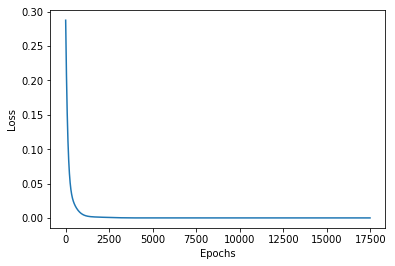

In [164]:
# Plot error vs epoch
plt.plot(regr.loss_curve_)
plt.ylabel('Loss')
plt.xlabel('Epochs');

In [165]:
# MLP weights -> WB-RAW RGB to XYZ 3x3 matrix conversion
regr.coefs_

[array([[ 0.79443793,  0.35856019,  0.06022069],
        [ 0.2781231 ,  0.99655999, -0.26346605],
        [ 0.12676705, -0.11509048,  1.21852841]])]

In [13]:
# MLP biases -> nearly 0's
regr.intercepts_

[array([-0.01059187, -0.00989786, -0.00368542])]

In [168]:
# Prediction
Y_pred = regr.predict(X)

# Clip to 0..1 range
# Y_pred[Y_pred < 0] = 0.0
# Y_pred[Y_pred > 1] = 1.0

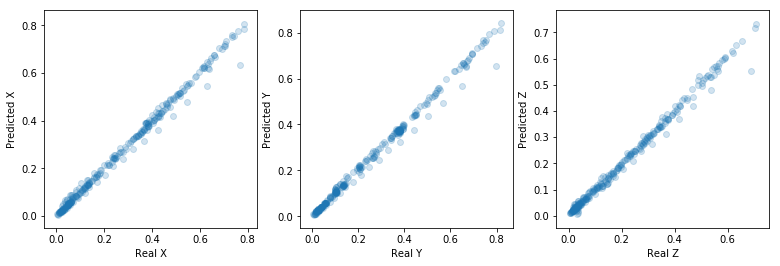

In [170]:
plt.subplots(figsize=(13, 4))

plt.subplot(131)
plt.scatter(Y_XYZ[:, 0], Y_pred[:, 0], alpha=0.2)
plt.ylabel('Predicted X')
plt.xlabel('Real X')

plt.subplot(132)
plt.scatter(Y_XYZ[:, 1], Y_pred[:, 1], alpha=0.2)
plt.ylabel('Predicted Y')
plt.xlabel('Real Y')

plt.subplot(133)
plt.scatter(Y_XYZ[:, 2], Y_pred[:, 2], alpha=0.2)
plt.ylabel('Predicted Z')
plt.xlabel('Real Z');

### Dense NN

In [171]:
# Load MLP (once trained and saved)
with open('mlp_(200, 200)_relu_identity.pkl', 'rb') as f:
    regr = pickle.load(f)

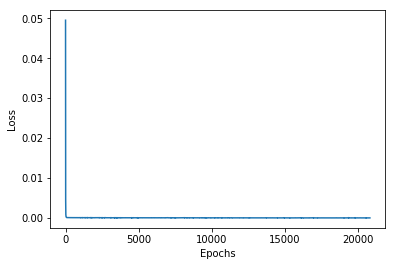

In [172]:
# Plot error vs epoch
plt.plot(regr.loss_curve_)
plt.ylabel('Loss')
plt.xlabel('Epochs');

In [173]:
# MLP weights
regr.coefs_

[array([[-4.31382451e-02,  2.17947329e-01,  7.97690181e-02,
          7.50752526e-02, -1.18274878e-01, -1.31874712e-01,
         -1.51948952e-01,  1.18425283e-01,  1.25905779e-01,
         -7.26079211e-04, -1.64842684e-01,  1.38649467e-01,
          4.10733993e-02, -9.89095943e-02, -9.65047498e-02,
         -7.70427893e-02, -6.73095337e-02,  8.51227505e-03,
         -1.64260607e-01, -1.79026678e-01,  2.53324245e-02,
         -1.23956775e-01, -7.14691821e-02, -4.59502712e-02,
          2.66563435e-02,  9.80551743e-02, -1.47154427e-01,
         -1.28053110e-02,  3.17759134e-02, -1.55948922e-01,
         -6.05190611e-02, -1.10948646e-01, -3.38013798e-01,
          2.16298317e-01,  1.60103362e-01, -1.81958413e-02,
         -1.38354202e-01, -1.38336804e-01,  5.49871966e-02,
         -2.05780236e-02, -1.29958734e-01, -4.05576448e-02,
         -1.60096295e-01,  1.32374945e-01, -8.29413210e-02,
         -7.31586759e-03, -3.16503718e-02, -1.75267906e-01,
         -5.46639785e-02, -1.16880508e-0

In [174]:
# MLP biases
regr.intercepts_

[array([-1.13833683e-01, -4.28700520e-02, -1.11057023e-01, -2.78734692e-01,
        -1.30440924e-01, -2.77989581e-02, -1.00974494e-01,  3.22226515e-02,
        -1.43727691e-04,  9.02744701e-02, -1.58403353e-01,  4.90523817e-02,
        -9.12185896e-03, -1.43808373e-01, -4.54126984e-03,  3.34791444e-02,
        -1.50919373e-01, -7.67186021e-02,  7.14739320e-03,  5.71916207e-04,
        -2.85045227e-01, -9.99376057e-02, -4.45369956e-02, -5.32163152e-03,
         5.27243585e-02, -4.50728591e-02, -1.55907229e-01,  4.18011552e-03,
        -1.59307289e-01, -8.51223170e-02,  1.31148680e-02,  2.79390103e-02,
        -6.90462353e-03,  1.19673433e-03, -1.35070350e-01, -2.63172667e-02,
         9.51853830e-02, -8.85491875e-02, -1.01768933e-01, -4.21947303e-02,
        -1.65019177e-01, -4.89575673e-02, -9.92159923e-02, -6.76887176e-02,
        -1.30741351e-01, -1.83755143e-02, -2.50015279e-04,  6.43476099e-03,
        -1.43374294e-04, -9.40155838e-03, -1.42033722e-01,  1.36096807e-02,
        -4.1

In [175]:
# Prediction
Y_pred2 = regr.predict(X)

# Clip to 0..1 range
# Y_pred[Y_pred < 0] = 0.0
# Y_pred[Y_pred > 1] = 1.0

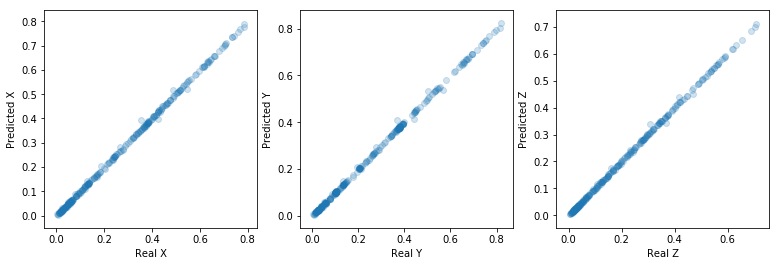

In [177]:
plt.subplots(figsize=(13, 4))

plt.subplot(131)
plt.scatter(Y_XYZ[:, 0], Y_pred2[:, 0], alpha=0.2)
plt.ylabel('Predicted X')
plt.xlabel('Real X')

plt.subplot(132)
plt.scatter(Y_XYZ[:, 1], Y_pred2[:, 1], alpha=0.2)
plt.ylabel('Predicted Y')
plt.xlabel('Real Y')

plt.subplot(133)
plt.scatter(Y_XYZ[:, 2], Y_pred2[:, 2], alpha=0.2)
plt.ylabel('Predicted Z')
plt.xlabel('Real Z');

## Neural network Lab prediction

### Matrix-like NN (no hidden layers)

In [120]:
# Load MLP (once trained and saved)
with open('MLP_Lab_()_logistic_identity.pkl', 'rb') as f:
    regr = pickle.load(f)

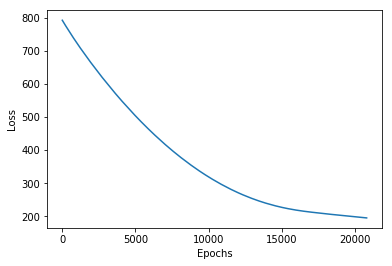

In [121]:
# Plot error vs epoch
plt.plot(regr.loss_curve_)
plt.ylabel('Loss')
plt.xlabel('Epochs');

In [122]:
# MLP weights -> WB-RAW RGB to Lab 3x3 matrix conversion
regr.coefs_

[array([[ 38.09629598,  40.21089205,  38.42999317],
        [ 38.16011382, -37.49353633,  24.66386552],
        [ 35.99047445, -17.78703235, -40.84770754]])]

In [123]:
# MLP biases -> nearly 0's
regr.intercepts_

[array([26.97413433,  7.15629134, -2.49719611])]

In [124]:
# Prediction
Y_pred = regr.predict(X)

# Clip to 0..1 range
# Y_pred[Y_pred < 0] = 0.0
# Y_pred[Y_pred > 1] = 1.0

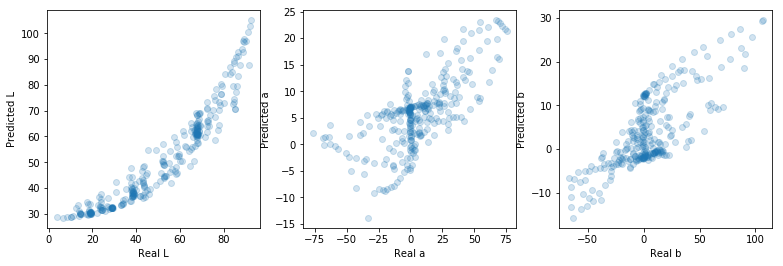

In [125]:
# The result is terrible, as expected since RGB to Lab is a highly non-linear transformation
plt.subplots(figsize=(13, 4))

plt.subplot(131)
plt.scatter(Y_Lab[:, 0], Y_pred[:, 0], alpha=0.2)
plt.ylabel('Predicted L')
plt.xlabel('Real L')

plt.subplot(132)
plt.scatter(Y_Lab[:, 1], Y_pred[:, 1], alpha=0.2)
plt.ylabel('Predicted a')
plt.xlabel('Real a')

plt.subplot(133)
plt.scatter(Y_Lab[:, 2], Y_pred[:, 2], alpha=0.2)
plt.ylabel('Predicted b')
plt.xlabel('Real b');

### Dense NN

In [188]:
# Load MLP (once trained and saved)
with open('MLP_Lab_(200, 200)_logistic_identity.pkl', 'rb') as f:
    regr = pickle.load(f)

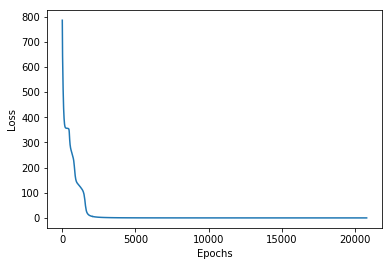

In [189]:
# Plot error vs epoch
plt.plot(regr.loss_curve_)
plt.ylabel('Loss')
plt.xlabel('Epochs');

In [153]:
# MLP weights -> WB-RAW RGB to Lab 3x3 matrix conversion
regr.coefs_

[array([[-3.24816922,  8.11061217,  0.77745848, -1.14659846, -3.34953211,
          0.66936061,  1.14331613,  5.85236017, -1.73685269,  6.79280375,
         -0.63908258,  0.53013406,  0.10064963, -0.16948977, -4.00863561,
          0.72228308,  1.04711149,  0.39109039, -1.10317925, -0.78173828,
         -0.22115386, -0.70150179, -2.75011506, -3.2793981 , -2.70995902,
         -2.95332581, -0.45610977,  0.11696549,  0.98349933, -3.42133265,
          5.34153725, -1.7385534 , -0.18057334,  1.42077052,  7.7140409 ,
          4.19649896,  0.93321309, -1.27715106,  0.68213662,  0.95496981,
         -1.47497967,  0.6767047 , -0.86107779, -0.34961395, -2.91597039,
          0.01930513, -1.10693143,  0.38794931,  0.08308852, -2.40001941,
          7.80677204,  3.02789858,  4.66542802,  6.5550495 ,  1.47406375,
          1.10770895, -3.67786291,  0.01458622, -0.30363237, -0.74987857,
          0.45950808, -3.54893014,  5.89005281,  3.59524354, -0.56312392,
         -3.6592747 , -0.14478988, -0.

In [154]:
# MLP biases
regr.intercepts_

[array([ 0.75657281, -0.5460355 , -0.23939636, -0.07202671,  0.07351131,
         0.02092583, -0.08539441, -0.1924373 , -0.43176662, -0.28265775,
        -0.01985024, -0.07321923, -0.16746145, -0.12584968, -0.13154272,
         0.09727135, -0.16840507, -0.17829685, -0.08192082, -0.12704676,
        -0.2036463 , -0.20666441,  0.71898817, -0.30976565,  0.79884299,
        -0.39354513, -0.05596598, -0.06217315, -0.08803625,  0.73409979,
        -0.0833893 , -0.11163216,  0.00531407, -0.20801238, -0.41745498,
        -0.21093179, -0.03015059, -0.6837778 , -0.34450479, -0.03402146,
         0.34394893, -0.44178739,  0.35268343, -0.32182653, -0.50530067,
        -0.29759488, -0.09698697, -0.43672847,  0.08012483,  0.05792986,
        -0.5431867 , -0.48674448, -0.49037354, -0.47335969, -0.17115894,
        -0.19114667, -0.39647628,  0.01097743,  0.12975264,  0.45197395,
         0.10900993, -0.29134175, -0.43424108, -0.53641448, -0.35675435,
        -0.25162074,  0.11770537, -0.24207141, -0.2

In [190]:
# Prediction
Y_pred = regr.predict(X)

# Clip to 0..1 range
# Y_pred[Y_pred < 0] = 0.0
# Y_pred[Y_pred > 1] = 1.0

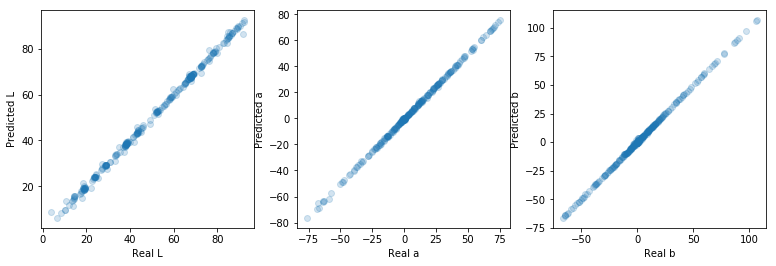

In [191]:
plt.subplots(figsize=(13, 4))

plt.subplot(131)
plt.scatter(Y_Lab[:, 0], Y_pred[:, 0], alpha=0.2)
plt.ylabel('Predicted L')
plt.xlabel('Real L')

plt.subplot(132)
plt.scatter(Y_Lab[:, 1], Y_pred[:, 1], alpha=0.2)
plt.ylabel('Predicted a')
plt.xlabel('Real a')

plt.subplot(133)
plt.scatter(Y_Lab[:, 2], Y_pred[:, 2], alpha=0.2)
plt.ylabel('Predicted b')
plt.xlabel('Real b');

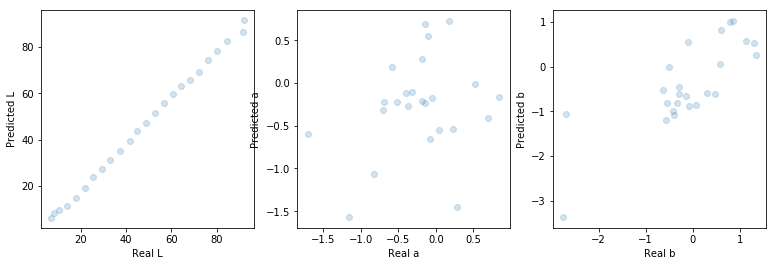

In [203]:
# Gray patches (24 patches)
plt.subplots(figsize=(13, 4))

plt.subplot(131)
plt.scatter(Y_Lab[(288-24):, 0], Y_pred[(288-24):, 0], alpha=0.2)
plt.ylabel('Predicted L')
plt.xlabel('Real L')

plt.subplot(132)
plt.scatter(Y_Lab[(288-24):, 1], Y_pred[(288-24):, 1], alpha=0.2)
plt.ylabel('Predicted a')
plt.xlabel('Real a')

plt.subplot(133)
plt.scatter(Y_Lab[(288-24):, 2], Y_pred[(288-24):, 2], alpha=0.2)
plt.ylabel('Predicted b')
plt.xlabel('Real b');

## Conversion functions

### XYZ (D50) to Lab conversion

In [46]:
def XYZ_to_Lab(XYZ):  # XYZ is a Nx3 array in the 0..1 range
    """XYZ (D50) to Lab conversion
    Formulae from www.brucelindbloom.com
    """
    
    Xr = 0.96422  # D50/2° 1931 reference white
    Yr = 1.0
    Zr = 0.82521
    
    e = 0.008856
    k = 903.3

    xr = XYZ[:, 0] / Xr
    yr = XYZ[:, 1] / Yr
    zr = XYZ[:, 2] / Zr
    
    # Most usual cases (xr > e, yr > e, zr > e)
    fx = xr ** (1 / 3)
    fy = yr ** (1 / 3)
    fz = zr ** (1 / 3)
    
    # Least usual cases
    indx = tuple([xr <= e])  # not using tuple() works but is deprecated
    indy = tuple([yr <= e])
    indz = tuple([zr <= e])
        
    fx[indx] = (k * xr[indx] + 16) / 116
    fy[indy] = (k * yr[indy] + 16) / 116
    fz[indz] = (k * zr[indz] + 16) / 116
        
    L = 116 * fy - 16
    a = 500 * (fx - fy)
    b = 200 * (fy - fz)
        
    return np.column_stack((L, a, b))  # output is a Nx3 array in the Lab range

In [47]:
# Test 1
XYZ_to_Lab(np.array([[0.5, 0.7, 0.2]]))

array([[ 86.9968642 , -42.25249828,  52.88499815]])

### Lab to XYZ (D50) conversion

In [45]:
def Lab_to_XYZ(Lab):  # Lab is a Nx3 array in the Lab range
    """Lab to XYZ (D50) conversion
    Formulae from www.brucelindbloom.com
    """
    
    Xr = 0.96422  # D50/2° 1931 reference white
    Yr = 1.0
    Zr = 0.82521
    
    e = 0.008856
    k = 903.3
    
    L = Lab[:, 0]
    a = Lab[:, 1]
    b = Lab[:, 2]
    
    fy = (L + 16) / 116
    fx = a / 500 + fy
    fz = fy - b / 200
    
    # Most usual cases (fx^3 > e, L > ke, fz^3 > e)
    xr = fx ** 3
    yr = ((L + 16) / 116)  ** 3
    zr = fz ** 3
    
    # Least usual cases
    indx = tuple([fx ** 3 <= e])  # not using tuple() works but is deprecated
    indy = tuple([L <= k * e])
    indz = tuple([fz ** 3 <= e])
    
    xr[indx] = (116 * fx[indx] - 16) / k
    yr[indy] = L[indy] / k
    zr[indz] = (116 * fz[indz] - 16) / k
    
    X = xr * Xr
    Y = yr * Yr
    Z = zr * Zr
    
    return np.column_stack((X, Y, Z))  # output is a Nx3 array in the 0..1 range

In [53]:
# Test 1
Lab_to_XYZ(np.array([[86.9968642, -42.25249828, 52.88499815]]))

array([[0.5, 0.7, 0.2]])

In [149]:
# Test 2: return ticket
Lab = XYZ_to_Lab(Y_XYZ)
Y_XYZ_bis = Lab_to_XYZ(Lab)
np.max(Y_XYZ_bis - Y_XYZ)

2.7755575615628914e-16

### XYZ (D50) to sRGB (D65) conversion

In [49]:
def XYZ_to_sRGB(XYZ):  # XYZ is a Nx3 array in the 0..1 range
    """XYZ (D50) to sRGB (D65) conversion using D50 to D65 Bradford adaption
    Formulae from www.brucelindbloom.com
    """
    
    X = XYZ[:, 0]
    Y = XYZ[:, 1]
    Z = XYZ[:, 2]
    
    r = 3.1338561 * X - 1.6168667 * Y - 0.4906146 * Z
    g =-0.9787684 * X + 1.9161415 * Y + 0.0334540 * Z
    b = 0.0719453 * X - 0.2289914 * Y + 1.4052427 * Z
    
    # Clip to 0..1 range
    r[r < 0] = 0.0
    r[r > 1] = 1.0
    g[g < 0] = 0.0
    g[g > 1] = 1.0
    b[b < 0] = 0.0
    b[b > 1] = 1.0
    
    # Most usual cases (R, G, B > 0.0031308)
    R = 1.055 * r**(1 / 2.4) - 0.055
    G = 1.055 * g**(1 / 2.4) - 0.055
    B = 1.055 * b**(1 / 2.4) - 0.055
    
    # Least usual cases
    indr = tuple([R <= 0.0031308])  # not using tuple() works but is deprecated
    indg = tuple([G <= 0.0031308])
    indb = tuple([B <= 0.0031308])
    
    R[indr] = 12.92 * R[indr]
    G[indg] = 12.92 * R[indg]
    B[indb] = 12.92 * R[indb]
    
    return np.column_stack((R, G, B))  # output is a Nx3 array in the 0..1 range

In [54]:
# Test 1
XYZ_to_sRGB(np.array([[0.5, 0.7, 0.2]])) * 255

array([[156.96508483, 238.44320903, 110.26498658]])

### XYZ (D50) to ProPhoto RGB (D50) conversion

In [51]:
def XYZ_to_ProPhotoRGB(XYZ):  # XYZ is a Nx3 array in the 0..1 range
    """XYZ (D50) to ProPhoto RGB (D50) conversion (no adaption needed)
    Formulae from www.brucelindbloom.com
    """
    
    X = XYZ[:, 0]
    Y = XYZ[:, 1]
    Z = XYZ[:, 2]
    
    r = 1.3459433 * X - 0.2556075 * Y - 0.0511118 * Z
    g =-0.5445989 * X + 1.5081673 * Y + 0.0205351 * Z
    b = 0.0000000 * X + 0.0000000 * Y + 1.2118128 * Z
    
    # Clip to 0..1 range
    r[r < 0] = 0.0
    r[r > 1] = 1.0
    g[g < 0] = 0.0
    g[g > 1] = 1.0
    b[b < 0] = 0.0
    b[b > 1] = 1.0
    
    return np.column_stack((r, g, b)) ** (1 / 1.8)  # output is a Nx3 array in the 0..1 range

In [52]:
XYZ_to_ProPhotoRGB(np.array([[0.5, 0.7, 0.2]])) * 255

array([[170.35957108, 223.31051101, 116.03168168]])

### Delta E calculation

In [55]:
def DeltaE(Lab1, Lab2):  # Lab1 and Lab2 are Nx3 arrays in the Lab range
    """Delta E calculation
       ΔE Quality:
         <1 = Excellent (imperceptible)
        1-2 = Good
        2-4 = Normal
        4-5 = Sufficient
         >5 = Bad
    """
    
    return np.sqrt((Lab1[:, 0] - Lab2[:, 0]) ** 2 +
                   (Lab1[:, 1] - Lab2[:, 1]) ** 2 +
                   (Lab1[:, 2] - Lab2[:, 2]) ** 2)  # ouput is a Nx1 array in the Lab range

## MLP models comparison

### MLP XYZ (200, 200) relu identity

In [179]:
# Delta E performance
Y_lab = XYZ_to_Lab(Y_XYZ)
Y_pred_lab = XYZ_to_Lab(Y_pred)
Y_pred2_lab = XYZ_to_Lab(Y_pred2)
    
print("() NN:")
print("ΔE_max =", np.max(DeltaE(Y_lab, Y_pred_lab)), "and ΔE_mean =", np.mean(DeltaE(Y_lab, Y_pred_lab)), "\n")

print("(200, 200) NN:")
print("ΔE_max =", np.max(DeltaE(Y_lab, Y_pred2_lab)), "and ΔE_mean =", np.mean(DeltaE(Y_lab, Y_pred2_lab)))

() NN:
ΔE_max = 29.579874621089253 and ΔE_mean = 3.4460693382616014 

(200, 200) NN:
ΔE_max = 7.035319348235826 and ΔE_mean = 1.035222151090219


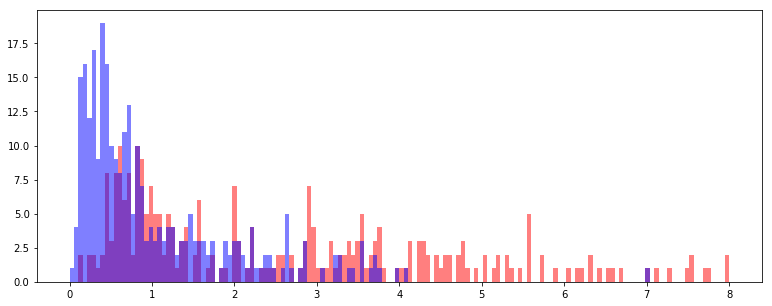

In [181]:
plt.subplots(figsize=(13, 5))
plt.hist(DeltaE(Y_lab, Y_pred_lab ), bins=150, range=[0, 8], color='r', alpha=0.5)
plt.hist(DeltaE(Y_lab, Y_pred2_lab), bins=150, range=[0, 8], color='b', alpha=0.5);

### MLP Lab (200, 200) logistic identity

In [157]:
# Delta E performance
print("(200, 200) NN:")
print("ΔE_max =", np.max(DeltaE(Y_Lab, Y_pred)), "and ΔE_mean =", np.mean(DeltaE(Y_Lab, Y_pred)))

(200, 200) NN:
ΔE_max = 5.659828256166601 and ΔE_mean = 0.8287066247766278


In [204]:
# Delta E performance - gray patches
print("(200, 200) NN:")
print("ΔE_max =", np.max(DeltaE(Y_Lab[(288-24):, ], Y_pred[(288-24):, ])),
      "and ΔE_mean =", np.mean(DeltaE(Y_Lab[(288-24):, ], Y_pred[(288-24):, ])))

(200, 200) NN:
ΔE_max = 5.180711323974614 and ΔE_mean = 2.1270746160940592


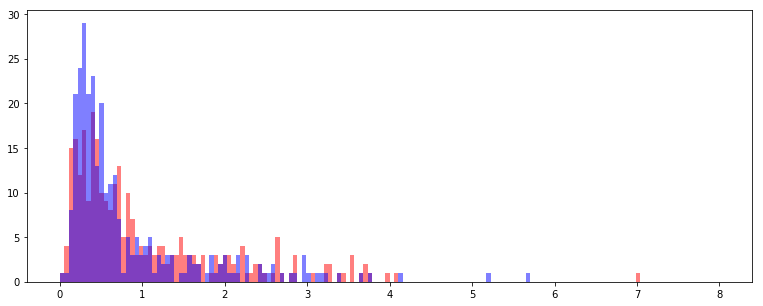

In [194]:
plt.subplots(figsize=(13, 5))
plt.hist(DeltaE(Y_lab, Y_pred2_lab), bins=150, range=[0, 8], color='r', alpha=0.5)
plt.hist(DeltaE(Y_Lab, Y_pred), bins=150, range=[0, 8], color='b', alpha=0.5);